<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/CHFUSD/CHFUSD_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "USDCHF"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [6]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-24 11:51:41,951 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-24 11:51:41,953 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for USDCHF
2019-08-24 11:55:49,081 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-24 12:04:17,952 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-24 12:08:10,124 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-24 12:12:03,276 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-24 12:16:21,823 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-24 12:20:24,555 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-24 12:24:31,691 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-24 12:27:55,855 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-30

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-24 12:39:41,174 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_436__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_USDCHF__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-USDCHF__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-USDCHF to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close       Volume
Date                                                                
2018-01-01 22:00:00  0.97348  0.97423  0.97287  0.97336  1054.739990
2018-01-01 23:00:00  0.97337  0.97481  0.97315  0.97481  5068.129883
2018-01-02 00:00:00  0.97481  0.97481  0.97405  0.97407  1947.170044
2018-01-02 01:00:00  0.97407  0.97427  0.97355  0.97427  2419.600098
2018-01-02 02:00:00  0.97424  0.97448  0.97383  0.97390  1760.739990
...                      ...      ...      ...      ...          ...
2018-12-31 17:00:00  0.98326  0.98362  0.98271  0.98272  6557.359863
2018-12-31 18:00:00  0.98278  0.98395  0.98278  0.98387  4982.830078
2018-12-31 19:00:00  0.98387  0.98387  0.98286  0.98297  1903.670044
2018-12-31 20:00:00  0.98297  0.98304  0.98255  0.98285  1960.369995
2018-12-31 21:00:00  0.98292  0.98295  0.98082  0.98099  2597.600098

[6213 rows x 5 columns]

Open         High          Low        Close        Volume
count  6213.000000  6213.000000  6213.000000  6213.000000   6213.000000
mean      0.978397     0.978987     0.977797     0.978399   4186.974609
std       0.021900     0.021849     0.021954     0.021902   2588.500000
min       0.919300     0.919660     0.918720     0.919290     39.470001
25%       0.962400     0.962930     0.961910     0.962400   2002.719971
50%       0.987760     0.988390     0.987250     0.987760   3903.679932
75%       0.994950     0.995500     0.994340     0.994960   5808.970215
max       1.011020     1.012810     1.010700     1.011020  27827.939453

25

In [7]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [8]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close       Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2018-01-04 00:00:00  0.97710  0.97754  0.97709  0.97725  1541.000000    4          3          4             31     0             0               1               0                 1      1        1     1        3             3           1  0.976680  0.962772  0.976590  0.977353  0.976788  0.976190    0.976680    0.977195  0.976590  0.976805  0.977183  0.976810  0.976947  0.976805  0.977103  0.975487                0.977476                 0.976805                0.976134                0.977812                 0.976805                0.975798                0.978148                 0.976805                0.975462                0.978483                 0.976805                0.975127  0.976788  0.977112  0.975736                0.977459                 0.976788                0.976116                0.977795                 0.976788                0.975781                0.978130                 0.976788                0.975445                0.978466                 0.976788   
2018-01-04 01:00:00  0.97725  0.97799  0.97718  0.97788  2007.750000    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  0.977280  0.966399  0.976830  0.977659  0.977030  0.976460    0.976995    0.977195  0.976830  0.976977  0.977576  0.976952  0.977186  0.976977  0.977565  0.975690                0.977906                 0.976977                0.976049                0.978371                 0.976977                0.975584                0.978835                 0.976977                0.975120                0.979300                 0.976977                0.974655  0.977030  0.977645  0.975931                0.977959                 0.977030                0.976101                0.978424                 0.977030                0.975637                0.978888                 0.977030                0.975172                0.979353                 0.977030   
2018-01-04 02:00:00  0.97788  0.97791  0.977

Open         High          Low        Close        Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  6163.000000  6163.000000  6163.000000  6163.000000   6163.000000  6163.000000  6163.000000  6163.000000    6163.000000  6163.000000   6163.000000     6163.000000     6163.000000       6163.000000  6163.000000  6163.000000  6163.000000  6163.000000   6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000             6163.000000              6163.000000             6163.000000             6163.000000              6163.000000             6163.000000             6163.000000              6163.000000             6163.000000             6163.000000              6163.000000             6163.000000  6163.000000  6163.000000  6163.000000             6163.000000              6163.000000             6163.000000             6163.000000              6163.000000             6163.000000             6163.000000   
mean      0.978436     0.979027     0.977835     0.978439   4193.271484    15.896966     2.051436   183.817946      30.440532    11.489048      0.034237        0.972416        0.003894          0.995132     6.547461     2.519714    26.646601     2.051436      2.029044    26.646601     0.978431     0.978395    -0.009902     0.978440     0.978435     0.978448     0.978431     0.978399     0.978374     0.978436     0.978439     0.978436     0.978437     0.978436     0.978439     0.978426                0.979996                 0.978436                0.976875                0.980776                 0.978436                0.976095                0.981556                 0.978436                0.975315                0.982337                 0.978436                0.974535     0.978435     0.978438     0.978427                0.979996                 0.978435                0.976875                0.980776                 0.978435                0.976095                0.981556   
std       0.021984     0.021932     0.022038     0.021986   2593.048584     8.724363     1.509716   104.043084       0.843764     6.925861      0.181851        0.163791        0.062287          0.069605     3.410726     1.113077    14.862751     1.509716      1.457490    14.862751     0.021977     0.021945     0.978706     0.021993     0.021957     0.021952     0.021960     0.021951     0.021972     0.021966     0.021990     0.021970     0.021969     0.021966     0.021978     0.021931                0.021849                 0.021966                0.022129                0.021808                 0.021966                0.022228                0.021779                 0.021966                0.022338                0.021761                 0.021966                0.022458     0.021957     0.021977     0.021936                0.021839                 0.021957                0.022120                0.021798                 0.021957                0.022219                0.021769   
min       0.919300     0.919660     0.

36

In [9]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [10]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-04 00:00:00  0.630179  0.621364  0.634595  0.631854  0.054034    4          3          4             31     0             0               1               0                 1      1        1     1        3             3           1  0.627260  0.464199  0.983775  0.634240  0.626375  0.623833    0.626672    0.625220  0.615049  0.628138  0.632589  0.628781  0.629140  0.628138  0.632354  0.609698                0.624135                 0.628138                0.636146                0.614722                 0.628138                0.642014                0.596399                 0.628138                0.647883                0.579005                 0.628138                0.653791  0.626375  0.631054  0.613037                0.621316                 0.626375                0.632643                0.613687                 0.626375                0.638413                0.601052                 0.626375                0.644662                0.583310                 0.626375   
2018-01-04 01:00:00  0.631814  0.626194  0.635573  0.638723  0.070831    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  0.633916  0.505591  0.983893  0.637586  0.629066  0.626864    0.630154    0.625220  0.617600  0.630045  0.636877  0.630348  0.631775  0.630045  0.637415  0.611992                0.628896                 0.630045                0.635223                0.620839                 0.630045                0.639731                0.603731                 0.630045                0.644286                0.587489                 0.630045                0.648932  0.629066  0.636901  0.615228                0.626861                 0.629066                0.632481                0.620601                 0.629066                0.636867                0.609241                 0.629066                0.641780                0.592645                 0.629066   
2018-01-04 02:00:00  0.638683  0.625335  

140265

In [11]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp30yqktqb
  JVM stdout: /tmp/tmp30yqktqb/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp30yqktqb/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 5 days
H2O cluster name:           H2O_from_python_unknownUser_grtrb4
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_125434_mod...  0.749404  0.708352              0.315634  0.472221  0.222993
1  DeepLearning_grid_1_AutoML_20190824_125434_mod...  0.747029  0.611102              0.344742  0.458769  0.210469
2  DeepLearning_grid_1_AutoML_20190824_125434_mod...  0.738074  0.621652              0.369501  0.461271  0.212771
3  DeepLearning_grid_1_AutoML_20190824_125434_mod...  0.737758  0.614191              0.364071  0.457928  0.209698
4  DeepLearning_grid_1_AutoML_20190824_125434_mod...  0.737050  0.614146              0.332135  0.461046  0.212564
5  DeepLearning_grid_1_AutoML_20190824_125434_mod...  0.734296  0.614703              0.351903  0.459005  0.210686
6  DeepLearning_grid_1_AutoML_20190824_125434_mod...  0.732359  0.677840              0.347555  0.469126  0.220079
7  DeepLearning_grid_1_AutoML_20190824_125434_mod...  0.732349  0.613982              0.379264  0.458054  0.209813
8              DeepLearning_1_AutoML_20190824_125434  0.712977  0.641748              0.328014  0.466968  0.218059
9  DeepLearning_grid_1_AutoML_20190824_125434_mod...  0.702729  0.634065              0.345386  0.471243  0.222070

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.007128
1           CDLCLOSINGMARUBOZU             0.545382           0.545382    0.003888
2               CDLEVENINGSTAR             0.495671           0.495671    0.003533
3            CDLSTALLEDPATTERN             0.490233           0.490233    0.003495
4                    CORREL_12             0.488255           0.488255    0.003480
...                        ...                  ...                ...         ...
1033    BBANDS_lowerband_8_3_4             0.102703           0.102703    0.000732
1034                  MEDPRICE             0.102362           0.102362    0.000730
1035   BBANDS_upperband_14_1_2             0.101757           0.101757    0.000725
1036  BBANDS_middleband_20_3_5             0.100012           0.100012    0.000713
1037                CDL3INSIDE             0.087171           0.087171    0.000621

[1038 rows x 4 columns]

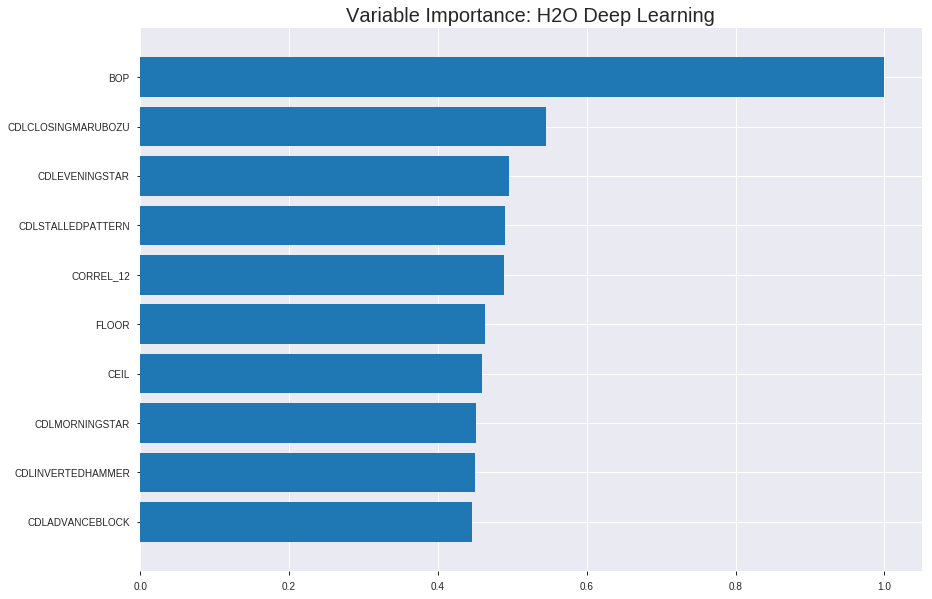

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_125434_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20363204527333054
RMSE: 0.45125607505420967
LogLoss: 0.6072920229878593
Mean Per-Class Error: 0.2989628593952067
AUC: 0.7678348789411278
pr_auc: 0.7476053936120265
Gini: 0.5356697578822556
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2505452675803102: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1106  1061  0.4896   (1061.0/2167.0)
1      317   1829  0.1477   (317.0/2146.0)
Total  1423  2890  0.3195   (1378.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.250545     0.72637   288
max f2                       0.03791      0.83993   382
max f0point5                 0.517143     0.7068    179
max accuracy                 0.388799     0.700904  234
max precision                0.998522     1         0
max recall                   0.00385777   1         398
max specificity              0.998522     1         0
max absolute_mcc             0.388799     0.402628  234
max min_per_class_accuracy   0.414494     0.698509  224
max mean_per_class_accuracy  0.388799     0.701037  234

Gains/Lift Table: Avg response rate: 49.76 %, avg score: 43.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.986121           1.69005   1.69005            0.840909         0.993104   0.840909                    0.993104            0.0172414       0.0172414                  69.0047   69.0047
    2        0.0201716                   0.973011           1.82283   1.75567            0.906977         0.978886   0.873563                    0.986076            0.0181733       0.0354147                  82.2829   75.5675
    3        0.0301414                   0.956543           1.77609   1.76243            0.883721         0.96583    0.876923                    0.97938             0.0177074       0.0531221                  77.609    76.2427
    4        0.0401113                   0.940933           1.82283   1.77744            0.906977         0.949648   0.884393                    0.97199             0.0181733       0.0712954                  82.2829   77.744
    5        0.0500812                   0.923939           1.72935   1.76787            0.860465         0.932366   0.87963                     0.964102            0.0172414       0.0885368                  72.935    76.7867
    6        0.100162                    0.852087           1.73995   1.75391            0.865741         0.887319   0.872685                    0.92571             0.0871389       0.175676                   73.9953   75.391
    7        0.150012                    0.789197           1.55174   1.68673            0.772093         0.821005   0.839258                    0.890916            0.0773532       0.253029                   55.1741   68.6729
    8        0.200093                    0.725399           1.41429   1.61854            0.703704         0.757136   0.80533                     0.857433            0.0708295       0.323858                   41.4294   61.8541
    9        0.300023                    0.614999           1.43156   1.55626            0.712297         0.669383   0.774343                    0.794798            0.143057        0.466915                   43.1564   55.6264
    10       0.399954                    0.512362           1.26836   1.48433            0.63109          0.564781   0.738551                    0.737327            0.126747        0.593663                   26.8357   48.4329
    11       0.500116                    0.411502           1.06537   1.40042            0.530093         0.461906   0.696801                    0.682166            0.10671         0.700373                   6.53725   40.0421
    12       0.600046                    0.319321           0.946604  1.32484            0.470998         0.365832   0.659196                    0.629484            0.0945946       0.794967                   -5.33956  32.4843
    13       0.699977                    0.219407           0.741429  1.24155            0.36891          0.268734   0.617754                    0.577983            0.0740913       0.869059                   -25.8571  24.1554
    14       0.799907                    0.143426           0.648168  1.16742            0.322506         0.180563   0.58087                     0.528334            0.0647717       0.93383                    -35.1832  16.7423
    15       0.899838                    0.0672758          0.405688  1.08283            0.201856         0.103675   0.538779                    0.481174            0.0405405       0.974371                   -59.4312  8.28296
    16       1                           0.00040879         0.255875  1                  0.127315         0.0311897  0.497565                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2372404493907148
RMSE: 0.48707335113996414
LogLoss: 0.7248675803198082
Mean Per-Class Error: 0.324535472972973
AUC: 0.7286568306587837
pr_auc: 0.7035762693760865
Gini: 0.45731366131756745
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08156814280674192: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      180  412   0.6959   (412.0/592.0)
1      41   599   0.0641   (41.0/640.0)
Total  221  1011  0.3677   (453.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0815681    0.725621  349
max f2                       0.0158325    0.851377  388
max f0point5                 0.47311      0.693374  182
max accuracy                 0.304296     0.67776   251
max precision                0.97255      0.806452  9
max recall                   0.000171178  1         399
max specificity              0.999561     0.996622  0
max absolute_mcc             0.302557     0.353762  252
max min_per_class_accuracy   0.362646     0.665625  225
max mean_per_class_accuracy  0.304296     0.675465  251

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 40.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.991179           1.48077   1.48077            0.769231         0.996984   0.769231                    0.996984            0.015625        0.015625                   48.0769   48.0769
    2        0.0202922                   0.976932           1.60417   1.54               0.833333         0.98392    0.8                         0.990713            0.015625        0.03125                    60.4167   54
    3        0.0300325                   0.965019           1.28333   1.45676            0.666667         0.970107   0.756757                    0.98403             0.0125          0.04375                    28.3333   45.6757
    4        0.0405844                   0.952466           1.62885   1.5015             0.846154         0.959633   0.78                        0.977687            0.0171875       0.0609375                  62.8846   50.15
    5        0.0503247                   0.942318           1.28333   1.45927            0.666667         0.947875   0.758065                    0.971917            0.0125          0.0734375                  28.3333   45.9274
    6        0.100649                    0.866589           1.49032   1.4748             0.774194         0.904835   0.766129                    0.938376            0.075           0.148438                   49.0323   47.4798
    7        0.150162                    0.789352           1.35697   1.43595            0.704918         0.827696   0.745946                    0.901881            0.0671875       0.215625                   35.6967   43.5946
    8        0.200487                    0.732331           1.39718   1.42621            0.725806         0.76036    0.740891                    0.866358            0.0703125       0.285938                   39.7177   42.6215
    9        0.300325                    0.600595           1.48679   1.44635            0.772358         0.663749   0.751351                    0.799004            0.148438        0.434375                   48.6789   44.6351
    10       0.400162                    0.469563           1.31463   1.41349            0.682927         0.530935   0.73428                     0.732123            0.13125         0.565625                   31.4634   41.3489
    11       0.5                         0.36506            0.954675  1.32188            0.495935         0.416936   0.686688                    0.669188            0.0953125       0.660937                   -4.53252  32.1875
    12       0.599838                    0.269882           1.00163   1.26857            0.520325         0.3175     0.658999                    0.610652            0.1             0.760938                   0.162602  26.8572
    13       0.699675                    0.166089           0.845122  1.20815            0.439024         0.212249   0.62761                     0.553804            0.084375        0.845313                   -15.4878  20.815
    14       0.799513                    0.0954075          0.704268  1.14523            0.365854         0.129391   0.594924                    0.500806            0.0703125       0.915625                   -29.5732  14.5228
    15       0.899351                    0.0410403          0.579065  1.08238            0.300813         0.068006   0.562274                    0.45276             0.0578125       0.973437                   -42.0935  8.23782
    16       1                           7.34859e-05        0.263911  1                  0.137097         0.0203887  0.519481                    0.40924


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 13:12:00  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 13:12:02  17 min 22.883 sec  410 obs/sec       0.201948  1             871        0.672169         6.94049             -0.807286      0.575662        0.335562           1.10187          0.417111                         0.687071           4.37436               -0.891138        0.626043          0.537435             1.33269            0.405032
    2019-08-24 13:12:37  17 min 56.987 sec  531 obs/sec       4.07118   20            17559      0.500607         0.996049            -0.00245421    0.748445        0.69366            1.82708          0.342453                         0.514307           1.02641               -0.0596566       0.725289          0.69573              1.18462            0.367695
    2019-08-24 13:13:10  18 min 30.318 sec  543 obs/sec       7.95456   39            34308      0.454065         0.604569            0.175279       0.758168        0.739765           1.87275          0.331788                         0.479571           0.687548              0.0786499        0.73664           0.714375             1.48077            0.340909
    2019-08-24 13:13:43  19 min  3.822 sec  545 obs/sec       11.8027   58            50905      0.47861          0.677319            0.0837092      0.739382        0.727963           1.91843          0.364711                         0.480433           0.695107              0.075333         0.731084          0.709402             1.48077            0.340097
    2019-08-24 13:14:17  19 min 36.950 sec  555 obs/sec       15.8767   78            68476      0.451256         0.607292            0.185453       0.767835        0.747605           1.69005          0.319499                         0.487073           0.724868              0.0495955        0.728657          0.703576             1.48077            0.367695

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.007128352080169144
CDLCLOSINGMARUBOZU        0.5453818440437317     0.5453818440437317   0.003887673802475619
CDLEVENINGSTAR            0.49567073583602905    0.49567073583602905  0.003533315520875728
CDLSTALLEDPATTERN         0.4902329742908478     0.4902329742908478   0.0034945532420536714
CORREL_12                 0.488254576921463      0.488254576921463    0.0034804505290502163
---                       ---                    ---                  ---
BBANDS_lowerband_8_3_4    0.10270314663648605    0.10270314663648605  0.000732104188966112
MEDPRICE                  0.10236154496669769    0.10236154496669769  0.0007296691319926869
BBANDS_upperband_14_1_2   0.1017569974064827     0.1017569974064827   0.0007253597041342671
BBANDS_middleband_20_3_5  0.10001160949468613    0.10001160949468613  0.00071291796458251
CDL3INSIDE                0.08717139065265656    0.08717139065265656  0.0006213883638901015


See the whole table with table.as_data_frame()


('accuracy', 0.6920583468395461)

('F1', 0.7005988023952096)

('auc', 0.7494037065180683)

('logloss', 0.7083521768257361)

('mean_per_class_error', 0.3117084599797366)

('rmse', 0.4722210662272563)

('mse', 0.2229927353888068)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


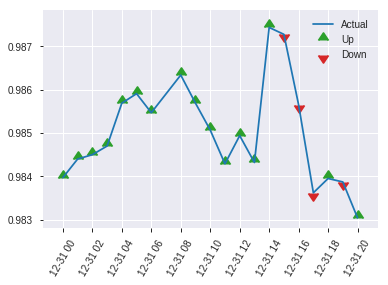


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2229927353888068
RMSE: 0.4722210662272563
LogLoss: 0.7083521768257361
Mean Per-Class Error: 0.3117084599797366
AUC: 0.7494037065180683
pr_auc: 0.7045932549698063
Gini: 0.4988074130361366
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1848689587011446: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      183  146  0.4438   (146.0/329.0)
1      54   234  0.1875   (54.0/288.0)
Total  237  380  0.3241   (200.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.184869     0.700599  274
max f2                       0.0239759    0.823045  371
max f0point5                 0.463015     0.675466  182
max accuracy                 0.463015     0.692058  182
max precision                0.997269     1         0
max recall                   0.000343952  1         399
max specificity              0.997269     1         0
max absolute_mcc             0.463015     0.379219  182
max min_per_class_accuracy   0.357811     0.680556  219
max mean_per_class_accuracy  0.294459     0.688292  237

Gains/Lift Table: Avg response rate: 46.68 %, avg score: 40.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.995925           1.83631   1.83631            0.857143         0.996793    0.857143                    0.996793            0.0208333       0.0208333                  83.631    83.631
    2        0.0210697                   0.989526           1.7853    1.81277            0.833333         0.992939    0.846154                    0.995014            0.0173611       0.0381944                  78.5301   81.2767
    3        0.0307942                   0.982865           2.14236   1.91685            1                0.986       0.894737                    0.992168            0.0208333       0.0590278                  114.236   91.6849
    4        0.0405186                   0.972446           1.7853    1.88528            0.833333         0.978344    0.88                        0.98885             0.0173611       0.0763889                  78.5301   88.5278
    5        0.0502431                   0.966307           2.14236   1.93504            1                0.968905    0.903226                    0.98499             0.0208333       0.0972222                  114.236   93.5036
    6        0.100486                    0.921313           1.79682   1.86593            0.83871          0.944674    0.870968                    0.964832            0.0902778       0.1875                     79.6819   86.5927
    7        0.150729                    0.866893           1.52039   1.75075            0.709677         0.892009    0.817204                    0.940557            0.0763889       0.263889                   52.0385   75.0747
    8        0.200972                    0.787947           1.38217   1.6586             0.645161         0.823154    0.774194                    0.911207            0.0694444       0.333333                   38.2168   65.8602
    9        0.299838                    0.620292           1.29946   1.54018            0.606557         0.698734    0.718919                    0.841148            0.128472        0.461806                   29.9465   54.0184
    10       0.400324                    0.473965           1.34761   1.49185            0.629032         0.535683    0.696356                    0.764473            0.135417        0.597222                   34.7614   49.1847
    11       0.50081                     0.333807           0.932964  1.37971            0.435484         0.400915    0.644013                    0.691526            0.09375         0.690972                   -6.70363  37.9708
    12       0.599676                    0.194042           1.0185    1.32016            0.47541          0.259875    0.616216                    0.620362            0.100694        0.791667                   1.84995   32.0158
    13       0.700162                    0.115472           0.691084  1.22987            0.322581         0.155134    0.574074                    0.553593            0.0694444       0.861111                   -30.8916  22.9874
    14       0.799028                    0.0628104          0.667293  1.16026            0.311475         0.0841722   0.541582                    0.49551             0.0659722       0.927083                   -33.2707  16.0265
    15       0.899514                    0.0209742          0.449205  1.08083            0.209677         0.042211    0.504505                    0.444872            0.0451389       0.972222                   -55.0795  8.08308
    16       1                           0.000160974        0.276434  1                  0.129032         0.00869217  0.466775  

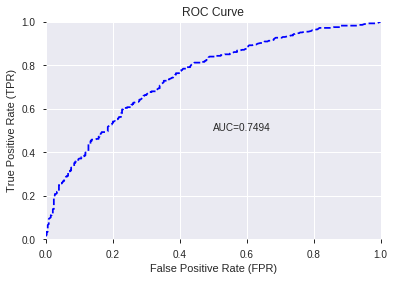

This function is available for GLM models only


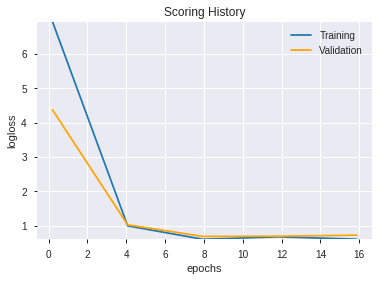

--2019-08-24 13:54:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.212
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.212|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  62.6MB/s    in 5.9s    

2019-08-24 13:54:54 (60.0 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_125434_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_125434_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a4a9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [13]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_135549_model_8  0.755483  0.596369              0.351048  0.452363  0.204633
1  DeepLearning_grid_1_AutoML_20190824_135549_model_9  0.753203  0.593935              0.344093  0.450450  0.202905
2  DeepLearning_grid_1_AutoML_20190824_135549_model_7  0.752237  0.674888              0.286743  0.473523  0.224224
3  DeepLearning_grid_1_AutoML_20190824_135549_model_6  0.750554  0.592029              0.332146  0.449827  0.202345
4  DeepLearning_grid_1_AutoML_20190824_135549_model_4  0.747668  0.617887              0.300215  0.454605  0.206666
5  DeepLearning_grid_1_AutoML_20190824_135549_model_5  0.743256  0.601525              0.314326  0.454209  0.206306
6               DeepLearning_1_AutoML_20190824_135549  0.742649  0.624013              0.331713  0.461092  0.212606
7  DeepLearning_grid_1_AutoML_20190824_135549_model_3  0.731995  0.669704              0.335613  0.463609  0.214934
8  DeepLearning_grid_1_AutoML_20190824_135549_model_2  0.729209  0.718431              0.318885  0.464973  0.216200
9  DeepLearning_grid_1_AutoML_20190824_135549_model_1  0.719689  0.973952              0.332800  0.483832  0.234093

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.044595
1    CDLCLOSINGMARUBOZU             0.861116           0.861116    0.038402
2                SAREXT             0.657451           0.657451    0.029319
3                   DIV             0.596985           0.596985    0.026623
4          HT_TRENDMODE             0.582572           0.582572    0.025980
5                   SUB             0.555392           0.555392    0.024768
6                TRANGE             0.536889           0.536889    0.023943
7          STOCHF_fastk             0.517167           0.517167    0.023063
8          CDLENGULFING             0.509764           0.509764    0.022733
9          CDLSHORTLINE             0.502171           0.502171    0.022395
10          CDLLONGLINE             0.496449           0.496449    0.022139
11    CDLSTALLEDPATTERN             0.481105           0.481105    0.021455
12        days_in_month             0.468494           0.468494    0.020893
13              WILLR_8             0.465249           0.465249    0.020748
14    CDLGRAVESTONEDOJI             0.449894           0.449894    0.020063
15       STOCHRSI_fastk             0.433908           0.433908    0.019350
16          CDLPIERCING             0.431594           0.431594    0.019247
17       CDLEVENINGSTAR             0.428241           0.428241    0.019098
18                FLOOR             0.424608           0.424608    0.018936
19        CDLHANGINGMAN             0.424310           0.424310    0.018922
20            CDLONNECK             0.422313           0.422313    0.018833
21   CDLSEPARATINGLINES             0.420499           0.420499    0.018752
22       CDLMORNINGSTAR             0.419129           0.419129    0.018691
23   CDLMORNINGDOJISTAR             0.417242           0.417242    0.018607
24    CDLDARKCLOUDCOVER             0.409278           0.409278    0.018252
25    CDLINVERTEDHAMMER             0.408224           0.408224    0.018205
26   CDLEVENINGDOJISTAR             0.406859           0.406859    0.018144
27     CDLDRAGONFLYDOJI             0.403083           0.403083    0.017976
28            CORREL_12             0.402722           0.402722    0.017960
29      CDLADVANCEBLOCK             0.402498           0.402498    0.017950
30                 CEIL             0.401085           0.401085    0.017887
31     is_quarter_start             0.400800           0.400800    0.017874
32    CDL3WHITESOLDIERS             0.396893           0.396893    0.017700
33             CORREL_8             0.396794           0.396794    0.017695
34            CORREL_20             0.396532           0.396532    0.017684
35            CDLTAKURI             0.396008           0.396008    0.017660
36     CDLSTICKSANDWICH             0.393214           0.393214    0.017536
37            CORREL_14             0.389918           0.389918    0.017389
38       is_month_start             0.385400           0.385400    0.017187
39  CDLGAPSIDESIDEWHITE             0.384221           0.384221    0.017135
40            CDL2CROWS             0.383203           0.383203    0.017089
41      CDLHOMINGPIGEON             0.380506           0.380506    0.016969
42   CDLIDENTICAL3CROWS             0.374093           0.374093    0.016683
43      CDLSHOOTINGSTAR             0.362068           0.362068    0.016147
44         CDLTHRUSTING             0.360524           0.360524    0.016078
45            CDLHAMMER             0.354609           0.354609    0.015814
46      CDLLADDERBOTTOM             0.344765           0.344765    0.015375
47       CDLMATCHINGLOW             0.340815           0.340815    0.015199
48        CDLHIKKAKEMOD             0.328584           0.328584    0.014653
49         is_month_end             0.318580           0.318580    0.014207

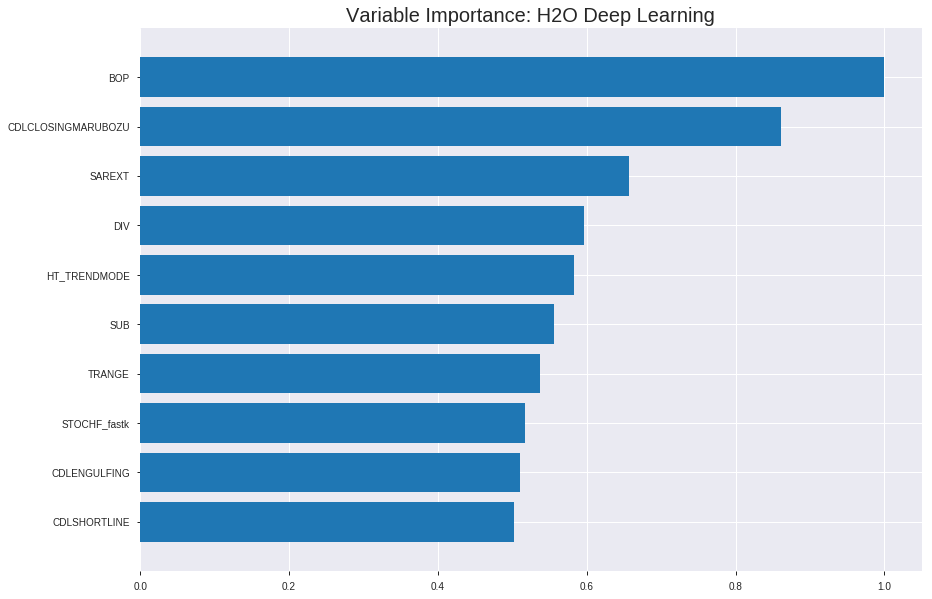

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_135549_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1974015981066466
RMSE: 0.4442989962926392
LogLoss: 0.5766318978355206
Mean Per-Class Error: 0.2960495503380153
AUC: 0.7755733830038049
pr_auc: 0.765299865723008
Gini: 0.5511467660076097
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4652248035388989: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1239  928   0.4282   (928.0/2167.0)
1      380   1766  0.1771   (380.0/2146.0)
Total  1619  2694  0.3033   (1308.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.465225     0.729752  214
max f2                       0.198578     0.846946  334
max f0point5                 0.534046     0.707366  166
max accuracy                 0.504266     0.703687  190
max precision                0.961526     1         0
max recall                   0.0695993    1         385
max specificity              0.961526     1         0
max absolute_mcc             0.49719      0.410226  195
max min_per_class_accuracy   0.516484     0.701305  181
max mean_per_class_accuracy  0.49719      0.70395   195

Gains/Lift Table: Avg response rate: 49.76 %, avg score: 48.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.880048           1.91843   1.91843            0.954545         0.918984  0.954545                    0.918984            0.0195713       0.0195713                  91.8432   91.8432
    2        0.0201716                   0.868674           1.91631   1.91738            0.953488         0.874217  0.954023                    0.896858            0.0191053       0.0386766                  91.6307   91.7382
    3        0.0301414                   0.856804           1.77609   1.87065            0.883721         0.862839  0.930769                    0.885605            0.0177074       0.056384                   77.609    87.0647
    4        0.0401113                   0.843572           1.72935   1.83553            0.860465         0.849958  0.913295                    0.876745            0.0172414       0.0736253                  72.935    83.5527
    5        0.0500812                   0.825896           1.91631   1.85161            0.953488         0.834895  0.921296                    0.868414            0.0191053       0.0927307                  91.6307   85.1608
    6        0.100162                    0.710438           1.71204   1.78182            0.851852         0.772168  0.886574                    0.820291            0.0857409       0.178472                   71.204    78.1824
    7        0.150012                    0.644213           1.54239   1.70226            0.767442         0.669565  0.846986                    0.770204            0.0768872       0.255359                   54.2394   70.226
    8        0.200093                    0.60755            1.55386   1.66512            0.773148         0.625667  0.828505                    0.734028            0.0778192       0.333178                   55.3862   66.5118
    9        0.300023                    0.562785           1.40359   1.57801            0.698376         0.581741  0.785162                    0.683305            0.140261        0.473439                   40.3586   57.8008
    10       0.399954                    0.537242           1.2124    1.48666            0.603248         0.549085  0.73971                     0.649769            0.121156        0.594595                   21.24     48.6659
    11       0.500116                    0.515373           1.07933   1.40508            0.537037         0.526751  0.699119                    0.625131            0.108108        0.702703                   7.93293   40.508
    12       0.600046                    0.474155           0.96992   1.33261            0.482599         0.496324  0.66306                     0.60368             0.0969245       0.799627                   -3.00802  33.2609
    13       0.699977                    0.424955           0.718114  1.24488            0.357309         0.451696  0.61941                     0.581983            0.0717614       0.871389                   -28.1886  24.4882
    14       0.799907                    0.323993           0.66682   1.17267            0.331787         0.37811   0.583478                    0.556513            0.0666356       0.938024                   -33.318   17.2666
    15       0.899838                    0.182866           0.456981  1.09319            0.227378         0.25538   0.543932                    0.523071            0.0456664       0.983691                   -54.3019  9.31867
    16       1                           0.0140611          0.16283   1                  0.0810185        0.111371  0.497565                    0.481834           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20743732024845227
RMSE: 0.45545287379536015
LogLoss: 0.6026882427937449
Mean Per-Class Error: 0.3171663851351352
AUC: 0.7431323902027027
pr_auc: 0.7378350739463007
Gini: 0.48626478040540544
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38889515553455123: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      260  332  0.5608   (332.0/592.0)
1      82   558  0.1281   (82.0/640.0)
Total  342  890  0.336    (414.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388895     0.729412  261
max f2                       0.0943367    0.852713  374
max f0point5                 0.533667     0.698214  171
max accuracy                 0.488771     0.685877  208
max precision                0.950357     1         0
max recall                   0.0107458    1         399
max specificity              0.950357     1         0
max absolute_mcc             0.488771     0.370816  208
max min_per_class_accuracy   0.517226     0.670312  186
max mean_per_class_accuracy  0.488771     0.682834  208

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 48.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.888746           1.33269   1.33269            0.692308         0.91068   0.692308                    0.91068             0.0140625       0.0140625                  33.2692   33.2692
    2        0.0202922                   0.870611           1.925     1.617              1                0.880543  0.84                        0.896214            0.01875         0.0328125                  92.5      61.7
    3        0.0300325                   0.861148           1.76458   1.66486            0.916667         0.866635  0.864865                    0.886621            0.0171875       0.05                       76.4583   66.4865
    4        0.0405844                   0.846516           1.48077   1.617              0.769231         0.852396  0.84                        0.877722            0.015625        0.065625                   48.0769   61.7
    5        0.0503247                   0.832983           1.925     1.67661            1                0.840343  0.870968                    0.870488            0.01875         0.084375                   92.5      67.6613
    6        0.100649                    0.733115           1.64556   1.66109            0.854839         0.782527  0.862903                    0.826507            0.0828125       0.167187                   64.5565   66.1089
    7        0.150162                    0.665964           1.51475   1.61284            0.786885         0.6961    0.837838                    0.783508            0.075           0.242188                   51.4754   61.2838
    8        0.200487                    0.621636           1.33508   1.54312            0.693548         0.642196  0.801619                    0.748037            0.0671875       0.309375                   33.5081   54.3117
    9        0.300325                    0.576508           1.34593   1.47757            0.699187         0.598943  0.767568                    0.698473            0.134375        0.44375                    34.5935   47.7568
    10       0.400162                    0.543391           1.23638   1.41739            0.642276         0.560225  0.736308                    0.663981            0.123438        0.567187                   23.6382   41.7394
    11       0.5                         0.517821           0.939024  1.32188            0.487805         0.53054   0.686688                    0.637337            0.09375         0.660937                   -6.09756  32.1875
    12       0.599838                    0.480785           1.04858   1.27639            0.544715         0.501526  0.663058                    0.614732            0.104688        0.765625                   4.85772   27.6387
    13       0.699675                    0.411434           0.845122  1.21485            0.439024         0.448745  0.63109                     0.591047            0.084375        0.85                       -15.4878  21.4849
    14       0.799513                    0.294054           0.704268  1.15109            0.365854         0.355805  0.59797                     0.561672            0.0703125       0.920312                   -29.5732  15.1091
    15       0.899351                    0.17026            0.532114  1.08238            0.276423         0.232558  0.562274                    0.525137            0.053125        0.973437                   -46.7886  8.23782
    16       1                           0.0107458          0.263911  1                  0.137097         0.101386  0.519481                    0.482486            0.0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 14:08:33  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 14:08:35  3 min 29.831 sec  539 obs/sec       0.268954  1             1160       0.500959         0.724062            -0.0038618     0.747519        0.736033           1.91843          0.345699                         0.510232           0.741586              -0.0429295       0.732319          0.71731              1.48077            0.350649
    2019-08-24 14:09:07  4 min  2.907 sec  1047 obs/sec      7.54857   28            32557      0.444299         0.576632            0.210375       0.775573        0.7653             1.91843          0.303269                         0.455453           0.602688              0.168989         0.743132          0.737835             1.33269            0.336039
    2019-08-24 14:09:49  4 min 43.998 sec  1219 obs/sec      19.5319   72            84241      0.439783         0.567143            0.226346       0.784705        0.77282            1.91843          0.313935                         0.456246           0.607348              0.166094         0.743296          0.730705             1.48077            0.3125
    2019-08-24 14:10:21  5 min 15.271 sec  1276 obs/sec      28.8036   106           124230     0.441192         0.570075            0.22138        0.791968        0.779451           1.87275          0.296082                         0.458683           0.611219              0.15716          0.740026          0.729487             1.48077            0.321429
    2019-08-24 14:10:52  5 min 46.564 sec  1327 obs/sec      38.6262   142           166595     0.430624         0.547541            0.258234       0.801503        0.790025           1.91843          0.284257                         0.458929           0.616487              0.156257         0.737277          0.725736             1.48077            0.319805
    2019-08-24 14:11:23  6 min 17.640 sec  1361 obs/sec      48.3487   178           208528     0.422467         0.529835            0.286069       0.810908        0.801191           1.87275          0.278229                         0.462516           0.634167              0.143015         0.7287            0.712724             1.33269            0.323052
    2019-08-24 14:11:57  6 min 51.964 sec  1396 obs/sec      59.6984   220           257479     0.423077         0.531843            0.284005       0.817675        0.813789           1.87275          0.280315                         0.462079           0.625064              0.144633         0.725843          0.706865             1.33269            0.345779
    2019-08-24 14:12:01  6 min 55.159 sec  1396 obs/sec      59.6984   220           257479     0.444299         0.576632            0.210375       0.775573        0.7653             1.91843          0.303269                         0.455453           0.602688              0.168989         0.743132          0.737835             1.33269            0.336039

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.04459543191244118
CDLCLOSINGMARUBOZU  0.8611156344413757     0.8611156344413757   0.038401823644468966
SAREXT              0.6574509739875793     0.6574509739875793   0.029319310146231237
DIV                 0.5969854593276978     0.5969854593276978   0.02662282440416577
HT_TRENDMODE        0.5825720429420471     0.5825720429420471   0.025980051875113826
---                 ---                    ---                  ---
CDLHAMMER           0.354608952999115      0.354608952999115    0.01581393941901409
CDLLADDERBOTTOM     0.3447650969028473     0.3447650969028473   0.015374948404717113
CDLMATCHINGLOW      0.3408147990703583     0.3408147990703583   0.015198783166694485
CDLHIKKAKEMOD       0.3285842537879944     0.3285842537879944   0.014653356717302798
is_month_end        0.31858041882514954    0.31858041882514954  0.014207231376353952


See the whole table with table.as_data_frame()


('accuracy', 0.7034035656401945)

('F1', 0.7007874015748032)

('auc', 0.7554827338736914)

('logloss', 0.5963694755068119)

('mean_per_class_error', 0.29888551165146904)

('rmse', 0.45236341067845337)

('mse', 0.20463265532064304)

deeplearning prediction progress: |███████████████████████████████████████| 100%


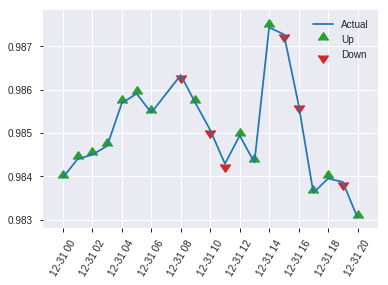


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20463265532064304
RMSE: 0.45236341067845337
LogLoss: 0.5963694755068119
Mean Per-Class Error: 0.29888551165146904
AUC: 0.7554827338736914
pr_auc: 0.7211839920268798
Gini: 0.5109654677473827
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3565497595984217: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      122  207  0.6292   (207.0/329.0)
1      21   267  0.0729   (21.0/288.0)
Total  143  474  0.3695   (228.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35655      0.700787  281
max f2                       0.289787     0.826866  314
max f0point5                 0.534609     0.68769   162
max accuracy                 0.534609     0.703404  162
max precision                0.904165     1         0
max recall                   0.0361224    1         398
max specificity              0.904165     1         0
max absolute_mcc             0.52787      0.403188  169
max min_per_class_accuracy   0.521172     0.694444  175
max mean_per_class_accuracy  0.52787      0.701114  169

Gains/Lift Table: Avg response rate: 46.68 %, avg score: 48.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.877295           2.14236   2.14236            1                0.883733  1                           0.883733            0.0243056       0.0243056                  114.236   114.236
    2        0.0210697                   0.872247           2.14236   2.14236            1                0.874444  1                           0.879446            0.0208333       0.0451389                  114.236   114.236
    3        0.0307942                   0.860622           1.42824   1.91685            0.666667         0.868067  0.894737                    0.875852            0.0138889       0.0590278                  42.8241   91.6849
    4        0.0405186                   0.844299           2.14236   1.97097            1                0.848888  0.92                        0.869381            0.0208333       0.0798611                  114.236   97.0972
    5        0.0502431                   0.829427           0.71412   1.72771            0.333333         0.838329  0.806452                    0.863371            0.00694444      0.0868056                  -28.588   72.7711
    6        0.100486                    0.728969           1.93504   1.83137            0.903226         0.782595  0.854839                    0.822983            0.0972222       0.184028                   93.5036   83.1373
    7        0.150729                    0.644579           1.58949   1.75075            0.741935         0.675297  0.817204                    0.773754            0.0798611       0.263889                   58.9494   75.0747
    8        0.200972                    0.604766           1.38217   1.6586             0.645161         0.623779  0.774194                    0.73626             0.0694444       0.333333                   38.2168   65.8602
    9        0.299838                    0.558521           1.33459   1.55176            0.622951         0.578945  0.724324                    0.684389            0.131944        0.465278                   33.4586   55.1764
    10       0.400324                    0.538175           1.38217   1.50919            0.645161         0.547944  0.704453                    0.650139            0.138889        0.604167                   38.2168   50.9194
    11       0.50081                     0.513868           1.03663   1.41437            0.483871         0.527141  0.660194                    0.62546             0.104167        0.708333                   3.66263   41.4374
    12       0.599676                    0.478554           0.772655  1.30858            0.360656         0.495346  0.610811                    0.604009            0.0763889       0.784722                   -22.7345  30.8577
    13       0.700162                    0.416703           0.794747  1.23483            0.370968         0.450039  0.576389                    0.581911            0.0798611       0.864583                   -20.5253  23.4833
    14       0.799028                    0.334563           0.737534  1.1733             0.344262         0.375057  0.547667                    0.556317            0.0729167       0.9375                     -26.2466  17.3301
    15       0.899514                    0.222921           0.310988  1.07697            0.145161         0.281507  0.502703                    0.525617            0.03125         0.96875                    -68.9012  7.69707
    16       1                           0.0331048          0.310988  1                  0.145161         0.131907  0.466775                    0.486055         

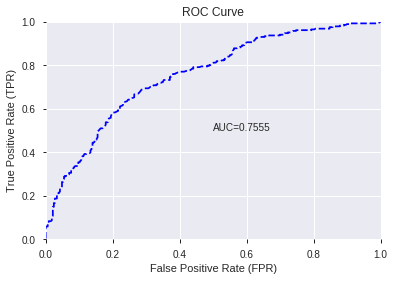

This function is available for GLM models only


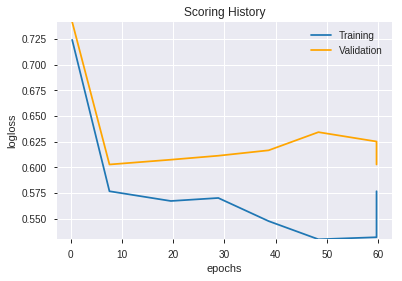

--2019-08-24 14:17:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.76
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.76|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_135549_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_135549_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a4a9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SAREXT',
 'DIV',
 'HT_TRENDMODE',
 'SUB',
 'TRANGE',
 'STOCHF_fastk',
 'CDLENGULFING',
 'CDLSHORTLINE',
 'CDLLONGLINE',
 'CDLSTALLEDPATTERN',
 'days_in_month',
 'WILLR_8',
 'CDLGRAVESTONEDOJI',
 'STOCHRSI_fastk',
 'CDLPIERCING',
 'CDLEVENINGSTAR',
 'FLOOR',
 'CDLHANGINGMAN',
 'CDLONNECK',
 'CDLSEPARATINGLINES',
 'CDLMORNINGSTAR',
 'CDLMORNINGDOJISTAR',
 'CDLDARKCLOUDCOVER',
 'CDLINVERTEDHAMMER',
 'CDLEVENINGDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CORREL_12',
 'CDLADVANCEBLOCK',
 'CEIL',
 'is_quarter_start',
 'CDL3WHITESOLDIERS',
 'CORREL_8',
 'CORREL_20',
 'CDLTAKURI',
 'CDLSTICKSANDWICH',
 'CORREL_14',
 'is_month_start',
 'CDLGAPSIDESIDEWHITE',
 'CDL2CROWS',
 'CDLHOMINGPIGEON',
 'CDLIDENTICAL3CROWS',
 'CDLSHOOTINGSTAR',
 'CDLTHRUSTING',
 'CDLHAMMER',
 'CDLLADDERBOTTOM',
 'CDLMATCHINGLOW',
 'CDLHIKKAKEMOD',
 'is_month_end']

In [14]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190824_141833_model_1  0.742602  0.604978               0.34995  0.454598  0.20666

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.519675           1.000000    0.176968
1    CDLCLOSINGMARUBOZU             0.206788           0.397919    0.070419
2          STOCHF_fastk             0.175203           0.337139    0.059663
3                   SUB             0.114656           0.220631    0.039045
4                TRANGE             0.113834           0.219048    0.038764
5               WILLR_8             0.106094           0.204154    0.036129
6                   DIV             0.102156           0.196577    0.034788
7                SAREXT             0.097237           0.187112    0.033113
8          CDLENGULFING             0.094311           0.181481    0.032116
9     CDLGRAVESTONEDOJI             0.092717           0.178413    0.031573
10    CDLSTALLEDPATTERN             0.078859           0.151747    0.026854
11         CDLSHORTLINE             0.062915           0.121066    0.021425
12    CDLDARKCLOUDCOVER             0.058927           0.113393    0.020067
13          CDLLONGLINE             0.058756           0.113063    0.020009
14            CDLTAKURI             0.058639           0.112838    0.019969
15     CDLSTICKSANDWICH             0.058481           0.112534    0.019915
16        CDLHANGINGMAN             0.057882           0.111381    0.019711
17       CDLEVENINGSTAR             0.056192           0.108130    0.019136
18   CDLSEPARATINGLINES             0.052887           0.101769    0.018010
19            CDLHAMMER             0.046325           0.089143    0.015775
20     CDLDRAGONFLYDOJI             0.046176           0.088855    0.015724
21          CDLPIERCING             0.045822           0.088175    0.015604
22      CDLADVANCEBLOCK             0.044341           0.085324    0.015100
23        days_in_month             0.042030           0.080878    0.014313
24         is_month_end             0.041053           0.078998    0.013980
25   CDLIDENTICAL3CROWS             0.039004           0.075054    0.013282
26         HT_TRENDMODE             0.037806           0.072749    0.012874
27            CDLONNECK             0.034785           0.066936    0.011845
28  CDLGAPSIDESIDEWHITE             0.034544           0.066472    0.011763
29    CDLINVERTEDHAMMER             0.033127           0.063746    0.011281
30            CDL2CROWS             0.032359           0.062268    0.011019
31       is_month_start             0.031502           0.060619    0.010728
32      CDLSHOOTINGSTAR             0.027130           0.052205    0.009239
33            CORREL_14             0.026556           0.051101    0.009043
34     is_quarter_start             0.024721           0.047570    0.008418
35      CDLLADDERBOTTOM             0.024160           0.046490    0.008227
36      CDLHOMINGPIGEON             0.021943           0.042225    0.007472
37    CDL3WHITESOLDIERS             0.021913           0.042168    0.007462
38       CDLMORNINGSTAR             0.016696           0.032127    0.005686
39   CDLEVENINGDOJISTAR             0.013986           0.026912    0.004763
40        CDLHIKKAKEMOD             0.012792           0.024614    0.004356
41            CORREL_20             0.012656           0.024354    0.004310
42         CDLTHRUSTING             0.010316           0.019851    0.003513
43       CDLMATCHINGLOW             0.010291           0.019803    0.003504
44   CDLMORNINGDOJISTAR             0.009933           0.019113    0.003382
45       STOCHRSI_fastk             0.009674           0.018615    0.003294
46            CORREL_12             0.008159           0.015700    0.002778
47                 CEIL             0.006659           0.012813    0.002268
48             CORREL_8             0.003869           0.007446    0.001318
49                FLOOR             0.000008           0.000015    0.000003

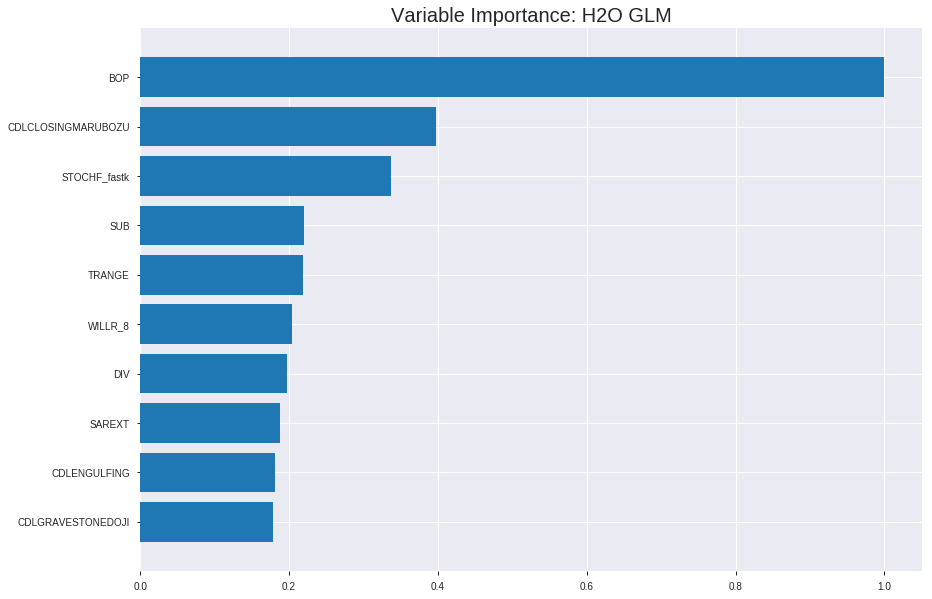

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_141833_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19470872839817926
RMSE: 0.44125811992322506
LogLoss: 0.5718881348328204
Null degrees of freedom: 4312
Residual degrees of freedom: 4262
Null deviance: 5978.985330091486
Residual deviance: 4933.107051067909
AIC: 5035.107051067909
AUC: 0.7723866555478669
pr_auc: 0.7621095590057552
Gini: 0.5447733110957338
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3992381096509065: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1141  1026  0.4735   (1026.0/2167.0)
1      330   1816  0.1538   (330.0/2146.0)
Total  1471  2842  0.3144   (1356.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.399238     0.728148  245
max f2                       0.173091     0.842109  348
max f0point5                 0.58322      0.706411  152
max accuracy                 0.455006     0.702991  218
max precision                0.965371     1         0
max recall                   0.0739224    1         388
max specificity              0.965371     1         0
max absolute_mcc             0.455006     0.41166   218
max min_per_class_accuracy   0.507029     0.698975  192
max mean_per_class_accuracy  0.455006     0.703371  218

Gains/Lift Table: Avg response rate: 49.76 %, avg score: 49.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.897373           1.91843   1.91843            0.954545         0.919226  0.954545                    0.919226            0.0195713       0.0195713                  91.8432   91.8432
    2        0.0201716                   0.878073           1.77609   1.84808            0.883721         0.887204  0.91954                     0.903399            0.0177074       0.0372787                  77.609    84.8079
    3        0.0301414                   0.860824           1.82283   1.83973            0.906977         0.869364  0.915385                    0.892141            0.0181733       0.055452                   82.2829   83.9727
    4        0.0401113                   0.848431           1.68261   1.80068            0.837209         0.854429  0.895954                    0.882768            0.0167754       0.0722274                  68.2611   80.0675
    5        0.0500812                   0.831518           1.86957   1.81439            0.930233         0.839434  0.902778                    0.874141            0.0186393       0.0908667                  86.9568   81.439
    6        0.100162                    0.777349           1.77717   1.79578            0.884259         0.802214  0.893519                    0.838178            0.0890028       0.17987                    77.7172   79.5781
    7        0.150012                    0.736525           1.62652   1.73954            0.809302         0.756306  0.865533                    0.810971            0.0810811       0.260951                   62.6524   73.9536
    8        0.200093                    0.704832           1.39568   1.65347            0.694444         0.721282  0.822711                    0.788523            0.0698975       0.330848                   39.5684   65.3474
    9        0.300023                    0.639281           1.35696   1.55471            0.675174         0.671396  0.77357                     0.749511            0.135601        0.466449                   35.6955   55.4711
    10       0.399954                    0.573637           1.27302   1.48433            0.633411         0.606743  0.738551                    0.71384             0.127213        0.593663                   27.302    48.4329
    11       0.500116                    0.505371           1.07002   1.40135            0.532407         0.540161  0.697265                    0.679056            0.107176        0.700839                   7.00248   40.1353
    12       0.600046                    0.438134           0.960594  1.32795            0.477958         0.472743  0.660742                    0.644697            0.0959925       0.796831                   -3.94064  32.795
    13       0.699977                    0.366138           0.755418  1.24621            0.37587          0.403782  0.620073                    0.610303            0.0754893       0.872321                   -24.4582  24.6214
    14       0.799907                    0.290881           0.592211  1.16451            0.294664         0.330032  0.57942                     0.57529             0.0591799       0.9315                     -40.7789  16.4511
    15       0.899838                    0.193037           0.452318  1.08542            0.225058         0.246521  0.540067                    0.538779            0.0452004       0.976701                   -54.7682  8.54189
    16       1                           0.0178596          0.232614  1                  0.115741         0.127316  0.497565                    0.497566           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20651368660728797
RMSE: 0.45443776978513567
LogLoss: 0.6012556931844808
Null degrees of freedom: 1231
Residual degrees of freedom: 1181
Null deviance: 1708.411288237215
Residual deviance: 1481.4940280065607
AIC: 1583.4940280065607
AUC: 0.7402185388513514
pr_auc: 0.7263712670609269
Gini: 0.4804370777027027
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38236714396403154: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      278  314  0.5304   (314.0/592.0)
1      98   542  0.1531   (98.0/640.0)
Total  376  856  0.3344   (412.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.382367     0.724599  263
max f2                       0.190831     0.854782  351
max f0point5                 0.59873      0.701788  151
max accuracy                 0.480852     0.681006  212
max precision                0.958991     1         0
max recall                   0.0246175    1         398
max specificity              0.958991     1         0
max absolute_mcc             0.59873      0.366351  151
max min_per_class_accuracy   0.521185     0.678125  191
max mean_per_class_accuracy  0.517645     0.680089  193

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 50.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.887676           1.48077   1.48077            0.769231         0.919192  0.769231                    0.919192            0.015625        0.015625                   48.0769   48.0769
    2        0.0202922                   0.872916           1.44375   1.463              0.75             0.880562  0.76                        0.90065             0.0140625       0.0296875                  44.375    46.3
    3        0.0300325                   0.860975           1.60417   1.50878            0.833333         0.867341  0.783784                    0.889847            0.015625        0.0453125                  60.4167   50.8784
    4        0.0405844                   0.845784           1.77692   1.5785             0.923077         0.852683  0.82                        0.880184            0.01875         0.0640625                  77.6923   57.85
    5        0.0503247                   0.828085           1.60417   1.58347            0.833333         0.833164  0.822581                    0.871083            0.015625        0.0796875                  60.4167   58.3468
    6        0.100649                    0.789576           1.49032   1.5369             0.774194         0.809393  0.798387                    0.840238            0.075           0.154688                   49.0323   53.6895
    7        0.150162                    0.756785           1.54631   1.54               0.803279         0.773788  0.8                         0.818328            0.0765625       0.23125                    54.6311   54
    8        0.200487                    0.718967           1.49032   1.52753            0.774194         0.73767   0.793522                    0.798082            0.075           0.30625                    49.0323   52.753
    9        0.300325                    0.656072           1.31463   1.45676            0.682927         0.685404  0.756757                    0.760624            0.13125         0.4375                     31.4634   45.6757
    10       0.400162                    0.589851           1.34593   1.42911            0.699187         0.623605  0.742394                    0.726439            0.134375        0.571875                   34.5935   42.9108
    11       0.5                         0.524458           0.970325  1.3375             0.504065         0.557034  0.694805                    0.692613            0.096875        0.66875                    -2.96748  33.75
    12       0.599838                    0.452886           0.954675  1.27378            0.495935         0.489622  0.661705                    0.658827            0.0953125       0.764062                   -4.53252  27.3782
    13       0.699675                    0.376755           0.845122  1.21262            0.439024         0.415725  0.62993                     0.624138            0.084375        0.848437                   -15.4878  21.2616
    14       0.799513                    0.288031           0.641667  1.14132            0.333333         0.336625  0.592893                    0.588235            0.0640625       0.9125                     -35.8333  14.132
    15       0.899351                    0.212265           0.641667  1.08585            0.333333         0.250279  0.564079                    0.550719            0.0640625       0.976562                   -35.8333  8.58529
    16       1                           0.0105128          0.232863  1                  0.120968         0.142366  0.519481                    0.509618            0.0234375  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 14:18:34  0.000 sec   2            21        49            1.36989           1.37223
    2019-08-24 14:18:34  0.037 sec   4            13        50            1.36092           1.36434
    2019-08-24 14:18:34  0.074 sec   6            8.2       50            1.34786           1.35291
    2019-08-24 14:18:34  0.104 sec   8            5.1       50            1.32979           1.3372
    2019-08-24 14:18:34  0.142 sec   10           3.2       50            1.30655           1.31722
    2019-08-24 14:18:34  0.192 sec   12           2         51            1.27929           1.29417
    2019-08-24 14:18:34  0.234 sec   14           1.2       51            1.25059           1.27053
    2019-08-24 14:18:34  0.277 sec   16           0.76      51            1.2234            1.24901
    2019-08-24 14:18:34  0.325 sec   18           0.47      51            1.20001           1.23158
    2019-08-24 14:18:34  0.368 sec   20           0.29      51            1.18136           1.21892
    2019-08-24 14:18:34  0.398 sec   22           0.18      51            1.16722           1.21062
    2019-08-24 14:18:34  0.438 sec   24           0.11      51            1.15681           1.20575
    2019-08-24 14:18:34  0.477 sec   26           0.07      51            1.14923           1.20331
    2019-08-24 14:18:34  0.507 sec   28           0.043     51            1.14378           1.20251
    2019-08-24 14:18:34  0.531 sec   30           0.027     51            1.14001           1.20283
    2019-08-24 14:18:34  0.555 sec   32           0.017     51            1.13756           1.20395
    2019-08-24 14:18:34  0.589 sec   34           0.01      51            1.1361            1.20555
    2019-08-24 14:18:34  0.628 sec   36           0.0065    51            1.13528           1.2074
    2019-08-24 14:18:34  0.651 sec   37           0.004     51            1.13484           1.20913

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7017828200972447)

('F1', 0.6905089408528199)

('auc', 0.7426017392772712)

('logloss', 0.6049775513943297)

('mean_per_class_error', 0.30191974839581226)

('rmse', 0.4545984554309156)

('mse', 0.20665975568017417)

glm prediction progress: |████████████████████████████████████████████████| 100%


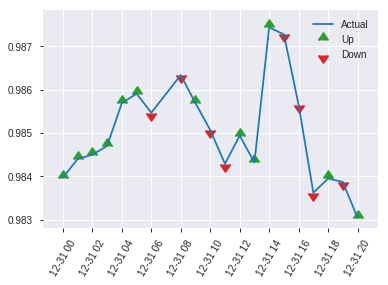


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20665975568017417
RMSE: 0.4545984554309156
LogLoss: 0.6049775513943297
Null degrees of freedom: 616
Residual degrees of freedom: 566
Null deviance: 854.9589870947052
Residual deviance: 746.542298420603
AIC: 848.542298420603
AUC: 0.7426017392772712
pr_auc: 0.6972860398372043
Gini: 0.4852034785545425
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3555483557891306: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      141  188  0.5714   (188.0/329.0)
1      37   251  0.1285   (37.0/288.0)
Total  178  439  0.3647   (225.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.355548     0.690509  276
max f2                       0.214987     0.820106  345
max f0point5                 0.546477     0.684172  174
max accuracy                 0.546477     0.701783  174
max precision                0.854675     0.884615  20
max recall                   0.0301227    1         399
max specificity              0.954336     0.99696   0
max absolute_mcc             0.546477     0.39909   174
max min_per_class_accuracy   0.498739     0.677812  197
max mean_per_class_accuracy  0.546477     0.69808   174

Gains/Lift Table: Avg response rate: 46.68 %, avg score: 49.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.906967           1.53026   1.53026            0.714286         0.917029  0.714286                    0.917029            0.0173611       0.0173611                  53.0258   53.0258
    2        0.0210697                   0.880186           2.14236   1.81277            1                0.894279  0.846154                    0.906529            0.0208333       0.0381944                  114.236   81.2767
    3        0.0307942                   0.867216           1.7853    1.80409            0.833333         0.870501  0.842105                    0.895152            0.0173611       0.0555556                  78.5301   80.4094
    4        0.0405186                   0.855507           2.14236   1.88528            1                0.861575  0.88                        0.887093            0.0208333       0.0763889                  114.236   88.5278
    5        0.0502431                   0.838844           1.42824   1.79682            0.666667         0.848014  0.83871                     0.87953             0.0138889       0.0902778                  42.8241   79.6819
    6        0.100486                    0.788763           1.6586    1.72771            0.774194         0.815266  0.806452                    0.847398            0.0833333       0.173611                   65.8602   72.7711
    7        0.150729                    0.755643           1.6586    1.70467            0.774194         0.773987  0.795699                    0.822927            0.0833333       0.256944                   65.8602   70.4674
    8        0.200972                    0.710698           1.6586    1.69316            0.774194         0.731829  0.790323                    0.800153            0.0833333       0.340278                   65.8602   69.3156
    9        0.299838                    0.632916           1.1941    1.5286             0.557377         0.671644  0.713514                    0.75778             0.118056        0.458333                   19.4103   52.8604
    10       0.400324                    0.566899           1.41672   1.50052            0.66129          0.600553  0.700405                    0.718314            0.142361        0.600694                   41.6723   50.052
    11       0.50081                     0.491623           0.863855  1.37278            0.403226         0.527974  0.640777                    0.680123            0.0868056       0.6875                     -13.6145  37.2775
    12       0.599676                    0.436845           0.878017  1.29121            0.409836         0.464704  0.602703                    0.644608            0.0868056       0.774306                   -12.1983  29.1207
    13       0.700162                    0.365251           0.829301  1.22491            0.387097         0.401123  0.571759                    0.609663            0.0833333       0.857639                   -17.0699  22.4915
    14       0.799028                    0.275198           0.561931  1.14288            0.262295         0.318782  0.533469                    0.573672            0.0555556       0.913194                   -43.8069  14.2882
    15       0.899514                    0.203847           0.552867  1.07697            0.258065         0.240307  0.502703                    0.536431            0.0555556       0.96875                    -44.7133  7.69707
    16       1                           0.0301227          0.310988  1                  0.145161         0.129259  0.466775                    0.495516          

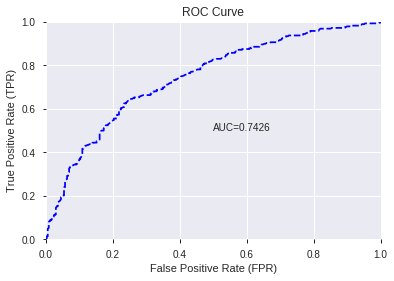

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


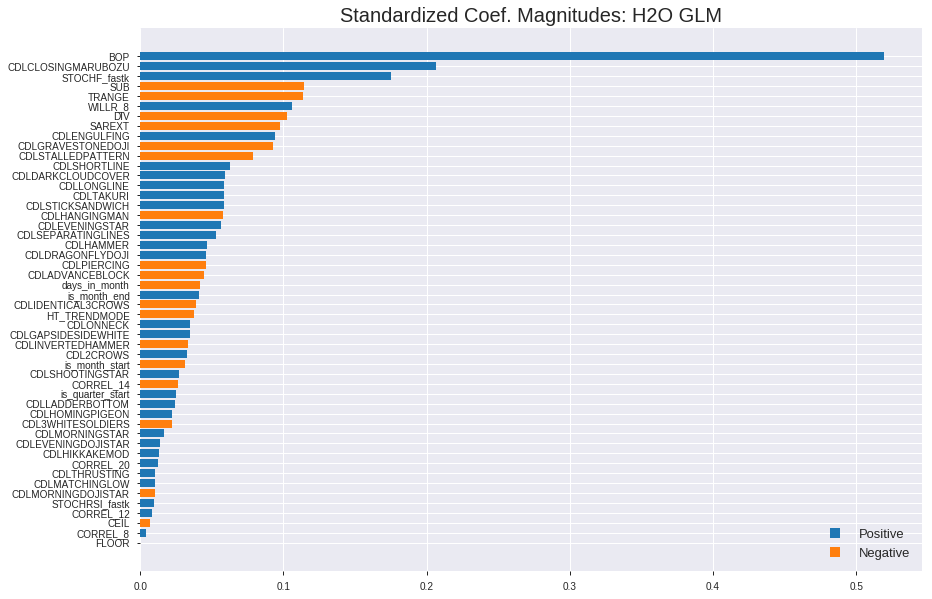

'log_likelihood'
--2019-08-24 14:18:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.124
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.124|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_141833_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_141833_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a4a9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'SUB',
 'TRANGE',
 'WILLR_8',
 'DIV',
 'SAREXT',
 'CDLENGULFING',
 'CDLGRAVESTONEDOJI',
 'CDLSTALLEDPATTERN',
 'CDLSHORTLINE',
 'CDLDARKCLOUDCOVER',
 'CDLLONGLINE',
 'CDLTAKURI',
 'CDLSTICKSANDWICH',
 'CDLHANGINGMAN',
 'CDLEVENINGSTAR',
 'CDLSEPARATINGLINES',
 'CDLHAMMER',
 'CDLDRAGONFLYDOJI',
 'CDLPIERCING',
 'CDLADVANCEBLOCK',
 'days_in_month',
 'is_month_end',
 'CDLIDENTICAL3CROWS',
 'HT_TRENDMODE',
 'CDLONNECK',
 'CDLGAPSIDESIDEWHITE',
 'CDLINVERTEDHAMMER',
 'CDL2CROWS',
 'is_month_start',
 'CDLSHOOTINGSTAR',
 'CORREL_14',
 'is_quarter_start',
 'CDLLADDERBOTTOM',
 'CDLHOMINGPIGEON',
 'CDL3WHITESOLDIERS',
 'CDLMORNINGSTAR',
 'CDLEVENINGDOJISTAR',
 'CDLHIKKAKEMOD',
 'CORREL_20',
 'CDLTHRUSTING',
 'CDLMATCHINGLOW',
 'CDLMORNINGDOJISTAR',
 'STOCHRSI_fastk',
 'CORREL_12',
 'CEIL',
 'CORREL_8',
 'FLOOR']

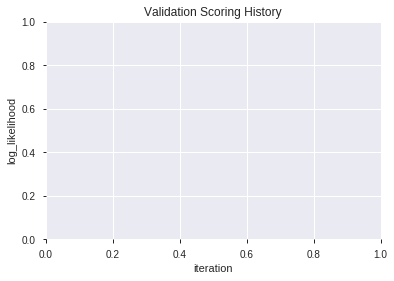

In [15]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_141941_model_3  0.763794  0.581638              0.303698  0.444747  0.197800
1               XGBoost_3_AutoML_20190824_141941  0.761572  0.582965              0.307603  0.446025  0.198939
2               XGBoost_2_AutoML_20190824_141941  0.761393  0.581770              0.302827  0.445644  0.198599
3  XGBoost_grid_1_AutoML_20190824_141941_model_6  0.759430  0.585959              0.315640  0.447172  0.199963
4  XGBoost_grid_1_AutoML_20190824_141941_model_2  0.759303  0.584850              0.312817  0.446906  0.199725
5  XGBoost_grid_1_AutoML_20190824_141941_model_1  0.759298  0.587053              0.311946  0.447106  0.199903
6  XGBoost_grid_1_AutoML_20190824_141941_model_7  0.758939  0.587360              0.291952  0.447353  0.200125
7               XGBoost_1_AutoML_20190824_141941  0.757878  0.587943              0.321719  0.447577  0.200325
8  XGBoost_grid_1_AutoML_20190824_141941_model_4  0.753076  0.588288              0.316943  0.448798  0.201420
9  XGBoost_grid_1_AutoML_20190824_141941_model_5  0.746902  0.603286              0.336478  0.453811  0.205945

variable  relative_importance  scaled_importance  percentage
0                  BOP          3928.775879           1.000000    0.333910
1         STOCHF_fastk          1522.675903           0.387570    0.129414
2               TRANGE          1280.815430           0.326009    0.108858
3       STOCHRSI_fastk           810.854187           0.206389    0.068915
4              WILLR_8           767.287231           0.195299    0.065212
5               SAREXT           705.954407           0.179688    0.060000
6                  DIV           581.304443           0.147961    0.049406
7                  SUB           549.824890           0.139948    0.046730
8   CDLCLOSINGMARUBOZU           376.273834           0.095774    0.031980
9         CDLSHORTLINE           255.469193           0.065025    0.021713
10   CDLGRAVESTONEDOJI           180.437607           0.045927    0.015336
11         CDLLONGLINE           162.007233           0.041236    0.013769
12       days_in_month           139.556992           0.035522    0.011861
13        CDLENGULFING           110.620171           0.028156    0.009402
14        HT_TRENDMODE            71.802727           0.018276    0.006103
15           CORREL_20            62.936348           0.016019    0.005349
16    CDLDRAGONFLYDOJI            61.761406           0.015720    0.005249
17           CDLTAKURI            55.097939           0.014024    0.004683
18           CDLHAMMER            50.918289           0.012960    0.004328
19        is_month_end            31.805267           0.008095    0.002703
20       CDLHANGINGMAN            15.621960           0.003976    0.001328
21           CORREL_14            11.573159           0.002946    0.000984
22      is_month_start             7.556190           0.001923    0.000642
23                CEIL             7.020280           0.001787    0.000597
24     CDLADVANCEBLOCK             4.633682           0.001179    0.000394
25     CDLSHOOTINGSTAR             4.442083           0.001131    0.000378
26      CDLMATCHINGLOW             4.180546           0.001064    0.000355
27           CORREL_12             3.742681           0.000953    0.000318
28               FLOOR             1.017985           0.000259    0.000087

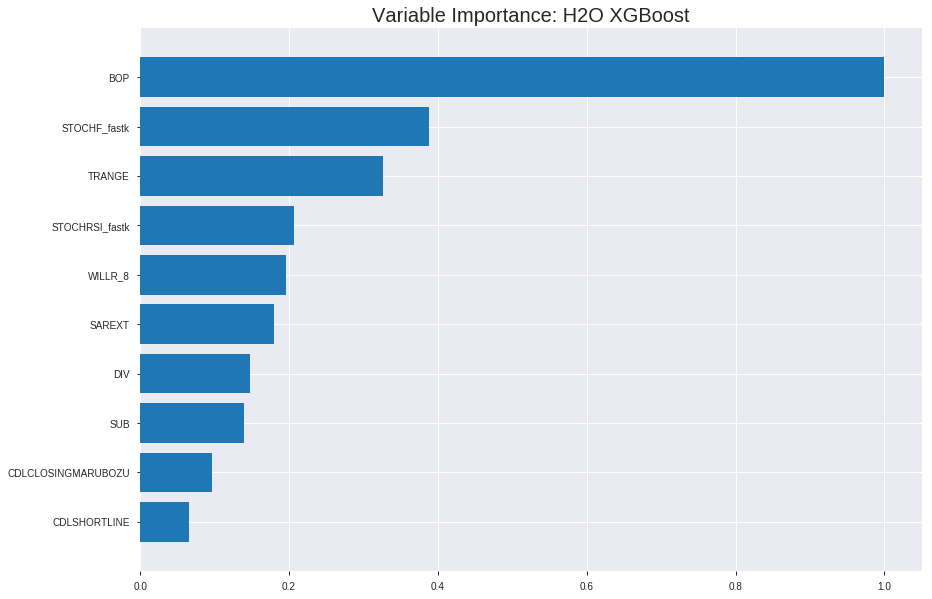

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_141941_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1725562504054147
RMSE: 0.4153989051567357
LogLoss: 0.5182349263884157
Mean Per-Class Error: 0.2541869678662957
AUC: 0.8273460115749631
pr_auc: 0.8293053641042809
Gini: 0.6546920231499262
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3769110788901647: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1247  920   0.4246   (920.0/2167.0)
1      277   1869  0.1291   (277.0/2146.0)
Total  1524  2789  0.2775   (1197.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.376911     0.757447  251
max f2                       0.248148     0.858669  317
max f0point5                 0.563731     0.755346  167
max accuracy                 0.524171     0.745885  187
max precision                0.958781     1         0
max recall                   0.113459     1         374
max specificity              0.958781     1         0
max absolute_mcc             0.524171     0.491868  187
max min_per_class_accuracy   0.512122     0.742311  193
max mean_per_class_accuracy  0.524171     0.745813  187

Gains/Lift Table: Avg response rate: 49.76 %, avg score: 49.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.924099           2.00979   2.00979            1                0.936294  1                           0.936294            0.0205033       0.0205033                  100.979   100.979
    2        0.0201716                   0.912835           2.00979   2.00979            1                0.918364  1                           0.927432            0.0200373       0.0405405                  100.979   100.979
    3        0.0301414                   0.896918           1.96305   1.99433            0.976744         0.904337  0.992308                    0.919793            0.0195713       0.0601118                  96.3046   99.4326
    4        0.0401113                   0.881524           1.91631   1.97493            0.953488         0.888064  0.982659                    0.911907            0.0191053       0.0792171                  91.6307   97.4934
    5        0.0500812                   0.870586           1.96305   1.97257            0.976744         0.87627   0.981481                    0.904812            0.0195713       0.0987884                  96.3046   97.2567
    6        0.100162                    0.811047           1.86091   1.91674            0.925926         0.838387  0.953704                    0.8716              0.0931966       0.191985                   86.0913   91.674
    7        0.150012                    0.760968           1.81348   1.88243            0.902326         0.788384  0.936631                    0.843947            0.0904007       0.282386                   81.3481   88.2427
    8        0.200093                    0.720214           1.64691   1.82348            0.819444         0.739402  0.9073                      0.81778             0.082479        0.364865                   64.6908   82.3479
    9        0.300023                    0.640752           1.44555   1.6976             0.719258         0.6804    0.844668                    0.772022            0.144455        0.50932                    44.5553   69.7601
    10       0.399954                    0.578327           1.22639   1.57987            0.610209         0.610721  0.786087                    0.73172             0.122554        0.631873                   22.6389   57.9866
    11       0.500116                    0.509549           1.1212    1.48801            0.55787          0.545935  0.74038                     0.694512            0.112302        0.744175                   12.12     48.8005
    12       0.600046                    0.425004           0.890647  1.38852            0.443155         0.469385  0.690881                    0.657019            0.0890028       0.833178                   -10.9353  38.8523
    13       0.699977                    0.340027           0.718114  1.29281            0.357309         0.376717  0.643259                    0.617003            0.0717614       0.904939                   -28.1886  29.2813
    14       0.799907                    0.271391           0.522264  1.19655            0.259861         0.306731  0.595362                    0.578241            0.0521901       0.95713                    -47.7736  19.6551
    15       0.899838                    0.187348           0.326415  1.09992            0.162413         0.232359  0.547282                    0.53983             0.0326188       0.989748                   -67.3585  9.99188
    16       1                           0.0392763          0.10235   1                  0.0509259        0.121345  0.497565                    0.497913          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2004591926853319
RMSE: 0.44772669418444544
LogLoss: 0.5862300857562317
Mean Per-Class Error: 0.30158361486486485
AUC: 0.7557485219594594
pr_auc: 0.7486046217842025
Gini: 0.5114970439189188
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.394713431596756: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      318  274  0.4628   (274.0/592.0)
1      112  528  0.175    (112.0/640.0)
Total  430  802  0.3133   (386.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394713     0.732316  253
max f2                       0.208799     0.854258  343
max f0point5                 0.621958     0.720541  146
max accuracy                 0.515214     0.696429  199
max precision                0.944407     1         0
max recall                   0.0586341    1         394
max specificity              0.944407     1         0
max absolute_mcc             0.589211     0.399833  164
max min_per_class_accuracy   0.538598     0.695312  188
max mean_per_class_accuracy  0.589211     0.698416  164

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 51.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.919124           1.62885   1.62885            0.846154         0.929104  0.846154                    0.929104            0.0171875       0.0171875                  62.8846   62.8846
    2        0.0202922                   0.905287           1.925     1.771              1                0.911378  0.92                        0.920596            0.01875         0.0359375                  92.5      77.1
    3        0.0300325                   0.893412           1.76458   1.76892            0.916667         0.899823  0.918919                    0.913859            0.0171875       0.053125                   76.4583   76.8919
    4        0.0405844                   0.875228           1.77692   1.771              0.923077         0.885387  0.92                        0.906456            0.01875         0.071875                   77.6923   77.1
    5        0.0503247                   0.863427           1.925     1.80081            1                0.869054  0.935484                    0.899217            0.01875         0.090625                   92.5      80.0806
    6        0.100649                    0.818516           1.33508   1.56794            0.693548         0.839851  0.814516                    0.869534            0.0671875       0.157812                   33.5081   56.7944
    7        0.150162                    0.776686           1.51475   1.55041            0.786885         0.799109  0.805405                    0.846313            0.075           0.232813                   51.4754   55.0405
    8        0.200487                    0.733608           1.42823   1.51974            0.741935         0.756205  0.789474                    0.823694            0.071875        0.304688                   42.8226   51.9737
    9        0.300325                    0.67195            1.45549   1.49838            0.756098         0.702054  0.778378                    0.783257            0.145313        0.45                       45.5488   49.8378
    10       0.400162                    0.608257           1.29898   1.44863            0.674797         0.639035  0.752535                    0.747275            0.129688        0.579688                   29.8984   44.8631
    11       0.5                         0.543257           1.06423   1.37188            0.552846         0.577534  0.712662                    0.713382            0.10625         0.685937                   6.42276   37.1875
    12       0.599838                    0.456808           0.939024  1.29983            0.487805         0.501329  0.675237                    0.678087            0.09375         0.779687                   -6.09756  29.9831
    13       0.699675                    0.348116           0.719919  1.21708            0.373984         0.399484  0.632251                    0.638333            0.071875        0.851562                   -28.0081  21.7082
    14       0.799513                    0.282364           0.672967  1.14914            0.349593         0.313852  0.596954                    0.597814            0.0671875       0.91875                    -32.7033  14.9137
    15       0.899351                    0.20462            0.594715  1.08759            0.308943         0.246256  0.564982                    0.558787            0.059375        0.978125                   -40.5285  8.75903
    16       1                           0.0464873          0.217339  1                  0.112903         0.129195  0.519481                    0.515549            0.0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 14:20:01  3.051 sec   0                  0.5              0.693147            0.5             0                  1                0.502435                         0.5                0.693147              0.5               0                    1                  0.480519
    2019-08-24 14:20:01  3.151 sec   5                  0.477412         0.648676            0.791129        0.789811           2.00979          0.295618                         0.481304           0.656197              0.742672          0.739737             1.77692            0.315747
    2019-08-24 14:20:01  3.243 sec   10                 0.462227         0.618937            0.795372        0.79679            1.96411          0.29214                          0.469501           0.632845              0.747679          0.744042             1.77692            0.311688
    2019-08-24 14:20:01  3.361 sec   15                 0.450834         0.596351            0.801914        0.802226           2.00979          0.286575                         0.461861           0.617438              0.75033           0.743186             1.62885            0.330357
    2019-08-24 14:20:01  3.486 sec   20                 0.442255         0.578803            0.80549         0.805141           2.00979          0.284721                         0.45634            0.605866              0.751669          0.744303             1.62885            0.32224
    2019-08-24 14:20:01  3.616 sec   25                 0.436619         0.566731            0.808068        0.808588           2.00979          0.283561                         0.453477           0.599521              0.75161           0.743021             1.62885            0.32224
    2019-08-24 14:20:02  3.733 sec   30                 0.432249         0.557087            0.810559        0.812043           2.00979          0.283329                         0.45165            0.595295              0.752043          0.744909             1.62885            0.313312
    2019-08-24 14:20:02  3.850 sec   35                 0.429118         0.549871            0.812121        0.813463           2.00979          0.290517                         0.45016            0.591727              0.752616          0.745978             1.77692            0.318182
    2019-08-24 14:20:02  3.985 sec   40                 0.426117         0.542925            0.814765        0.815799           2.00979          0.28959                          0.450002           0.591028              0.751427          0.745604             1.77692            0.314935
    2019-08-24 14:20:02  4.137 sec   45                 0.423505         0.53696             0.817299        0.818631           2.00979          0.286344                         0.449263           0.589324              0.752085          0.747136             1.62885            0.314123
    2019-08-24 14:20:02  4.266 sec   50                 0.421056         0.531368            0.819896        0.820139           2.00979          0.282634                         0.448337           0.587376              0.753557          0.748969             1.77692            0.318994
    2019-08-24 14:20:02  4.407 sec   55                 0.419644         0.52791             0.821326        0.821891           2.00979          0.27962                          0.448025           0.586673              0.754351          0.7

Variable Importances: 


variable         relative_importance    scaled_importance      percentage
---------------  ---------------------  ---------------------  ----------------------
BOP              3928.77587890625       1.0                    0.3339101295218973
STOCHF_fastk     1522.6759033203125     0.38757006005245004    0.1294135689509231
TRANGE           1280.8154296875        0.3260087796212168     0.10885763382859617
STOCHRSI_fastk   810.8541870117188      0.20638850675224982    0.0689152130214747
WILLR_8          767.2872314453125      0.19529931334716938    0.06521241901529093
---              ---                    ---                    ---
CDLADVANCEBLOCK  4.6336822509765625     0.0011794213754607338  0.00039382074424098787
CDLSHOOTINGSTAR  4.44208288192749       0.0011306531649660154  0.00037753654475814526
CDLMATCHINGLOW   4.180545806884766      0.0010640835557279504  0.0003553082779152409
CORREL_12        3.7426810264587402     0.0009526328662709776  0.00031809376376335836
FLOOR            1.0179853439331055     0.0002591100575114779  8.651947286408383e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7034035656401945)

('F1', 0.7132243684992572)

('auc', 0.7637939040864573)

('logloss', 0.581638049163932)

('mean_per_class_error', 0.3034553360351233)

('rmse', 0.44474681140889016)

('mse', 0.1977997262583749)

xgboost prediction progress: |████████████████████████████████████████████| 100%


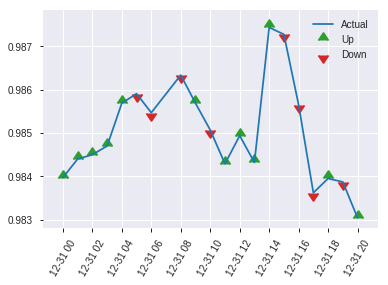


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1977997262583749
RMSE: 0.44474681140889016
LogLoss: 0.581638049163932
Mean Per-Class Error: 0.3034553360351233
AUC: 0.7637939040864573
pr_auc: 0.7269311587232183
Gini: 0.5275878081729146
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38464727997779846: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      184  145  0.4407   (145.0/329.0)
1      48   240  0.1667   (48.0/288.0)
Total  232  385  0.3128   (193.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.384647     0.713224  246
max f2                       0.240166     0.823778  323
max f0point5                 0.60321      0.694444  144
max accuracy                 0.60321      0.703404  144
max precision                0.95262      1         0
max recall                   0.0402165    1         399
max specificity              0.95262      1         0
max absolute_mcc             0.60321      0.404792  144
max min_per_class_accuracy   0.517772     0.693009  191
max mean_per_class_accuracy  0.491779     0.696545  200

Gains/Lift Table: Avg response rate: 46.68 %, avg score: 48.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.93306            1.83631   1.83631            0.857143         0.940048  0.857143                    0.940048            0.0208333       0.0208333                  83.631    83.631
    2        0.0210697                   0.916372           2.14236   1.97756            1                0.924189  0.923077                    0.932728            0.0208333       0.0416667                  114.236   97.7564
    3        0.0307942                   0.90752            1.7853    1.91685            0.833333         0.910929  0.894737                    0.925844            0.0173611       0.0590278                  78.5301   91.6849
    4        0.0405186                   0.889947           1.7853    1.88528            0.833333         0.900512  0.88                        0.919764            0.0173611       0.0763889                  78.5301   88.5278
    5        0.0502431                   0.872564           1.7853    1.86593            0.833333         0.881778  0.870968                    0.912412            0.0173611       0.09375                    78.5301   86.5927
    6        0.100486                    0.808256           1.72771   1.79682            0.806452         0.844999  0.83871                     0.878706            0.0868056       0.180556                   72.7711   79.6819
    7        0.150729                    0.75687            1.86593   1.81986            0.870968         0.779241  0.849462                    0.845551            0.09375         0.274306                   86.5927   81.9855
    8        0.200972                    0.704443           1.38217   1.71043            0.645161         0.733194  0.798387                    0.817462            0.0694444       0.34375                    38.2168   71.0433
    9        0.299838                    0.638377           1.33459   1.58651            0.622951         0.67055   0.740541                    0.769021            0.131944        0.475694                   33.4586   58.6505
    10       0.400324                    0.579493           1.2094    1.49185            0.564516         0.609361  0.696356                    0.728944            0.121528        0.597222                   20.9397   49.1847
    11       0.50081                     0.501398           1.10573   1.41437            0.516129         0.543597  0.660194                    0.691755            0.111111        0.708333                   10.5735   41.4374
    12       0.599676                    0.399932           0.983379  1.34332            0.459016         0.448498  0.627027                    0.65165             0.0972222       0.805556                   -1.66211  34.3318
    13       0.700162                    0.32351            0.587422  1.23483            0.274194         0.360057  0.576389                    0.609801            0.0590278       0.864583                   -41.2578  23.4833
    14       0.799028                    0.253108           0.667293  1.16461            0.311475         0.290832  0.543611                    0.570334            0.0659722       0.930556                   -33.2707  16.461
    15       0.899514                    0.178151           0.345542  1.07311            0.16129          0.216163  0.500901                    0.530769            0.0347222       0.965278                   -65.4458  7.31106
    16       1                           0.0402165          0.345542  1                  0.16129          0.114112  0.466775                    0.488901           

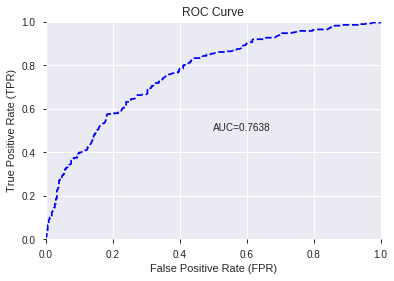

This function is available for GLM models only


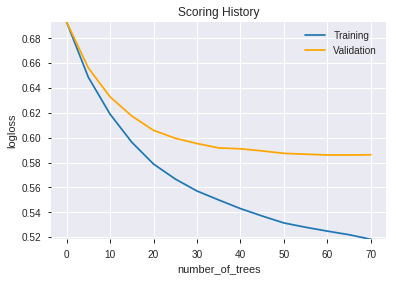

--2019-08-24 14:20:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_141941_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_141941_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a4a9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'STOCHRSI_fastk',
 'WILLR_8',
 'SAREXT',
 'DIV',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'CDLSHORTLINE',
 'CDLGRAVESTONEDOJI',
 'CDLLONGLINE',
 'days_in_month',
 'CDLENGULFING',
 'HT_TRENDMODE',
 'CORREL_20',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLHAMMER',
 'is_month_end',
 'CDLHANGINGMAN',
 'CORREL_14',
 'is_month_start',
 'CEIL',
 'CDLADVANCEBLOCK',
 'CDLSHOOTINGSTAR',
 'CDLMATCHINGLOW',
 'CORREL_12',
 'FLOOR']

In [16]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_142120_model_1  0.751462  0.594655              0.329539  0.450759  0.203184

variable  relative_importance  scaled_importance    percentage
0                         BOP             0.402999           1.000000  4.160388e-02
1          CDLCLOSINGMARUBOZU             0.192299           0.477170  1.985214e-02
2                STOCHF_fastk             0.174709           0.433523  1.803625e-02
3                     WILLR_8             0.143866           0.356989  1.485213e-02
4                         SUB             0.126831           0.314719  1.309353e-02
...                       ...                  ...                ...           ...
1033  BBANDS_upperband_24_3_3             0.000008           0.000019  7.831029e-07
1034  BBANDS_lowerband_20_6_2             0.000007           0.000017  7.273417e-07
1035                MAVP_30_7             0.000003           0.000008  3.533759e-07
1036                  MA_12_7             0.000003           0.000007  2.714851e-07
1037                MAVP_12_7             0.000002           0.000006  2.462544e-07

[1038 rows x 4 columns]

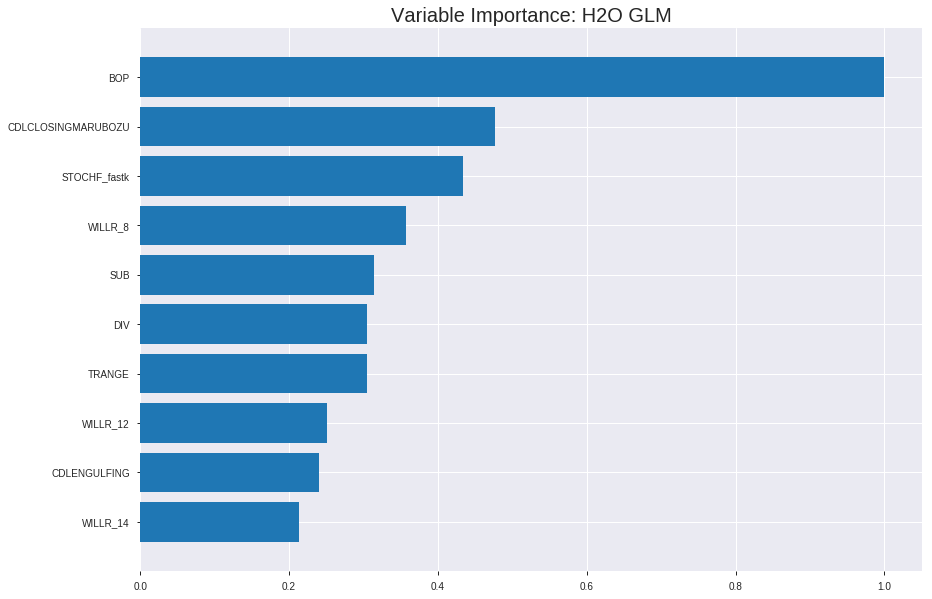

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_142120_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1864860325086041
RMSE: 0.4318402858796341
LogLoss: 0.551914742024692
Null degrees of freedom: 4312
Residual degrees of freedom: 3274
Null deviance: 5978.985330091486
Residual deviance: 4760.816564704994
AIC: 6838.816564704994
AUC: 0.7929128187748878
pr_auc: 0.7879496831431176
Gini: 0.5858256375497757
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3872089843530779: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1155  1012  0.467    (1012.0/2167.0)
1      297   1849  0.1384   (297.0/2146.0)
Total  1452  2861  0.3035   (1309.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.387209     0.738566  245
max f2                       0.200801     0.846042  332
max f0point5                 0.581466     0.729053  153
max accuracy                 0.53275      0.71783   179
max precision                0.960265     1         0
max recall                   0.0605946    1         385
max specificity              0.960265     1         0
max absolute_mcc             0.581466     0.437556  153
max min_per_class_accuracy   0.513196     0.71389   187
max mean_per_class_accuracy  0.53275      0.71772   179

Gains/Lift Table: Avg response rate: 49.76 %, avg score: 49.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.901485           2.00979   2.00979            1                0.924716  1                           0.924716            0.0205033       0.0205033                  100.979   100.979
    2        0.0201716                   0.882496           1.91631   1.96358            0.953488         0.89247   0.977011                    0.908778            0.0191053       0.0396086                  91.6307   96.3584
    3        0.0301414                   0.863763           1.91631   1.94795            0.953488         0.872473  0.969231                    0.89677             0.0191053       0.0587139                  91.6307   94.7946
    4        0.0401113                   0.848667           1.82283   1.91685            0.906977         0.855542  0.953757                    0.886522            0.0181733       0.0768872                  82.2829   91.6848
    5        0.0500812                   0.835069           1.86957   1.90744            0.930233         0.841399  0.949074                    0.87754             0.0186393       0.0955266                  86.9568   90.7435
    6        0.100162                    0.788925           1.77717   1.8423             0.884259         0.809851  0.916667                    0.843695            0.0890028       0.184529                   77.7172   84.2304
    7        0.150012                    0.752264           1.57978   1.75507            0.786047         0.771923  0.873261                    0.819845            0.0787512       0.263281                   57.9785   75.5068
    8        0.200093                    0.715577           1.57247   1.70937            0.782407         0.734572  0.850521                    0.798502            0.0787512       0.342032                   57.2471   70.9366
    9        0.300023                    0.649726           1.41758   1.61218            0.705336         0.681891  0.802164                    0.759662            0.141659        0.483691                   41.7575   61.2177
    10       0.399954                    0.586295           1.28701   1.53093            0.640371         0.618304  0.761739                    0.724343            0.128611        0.612302                   28.7009   53.0932
    11       0.500116                    0.512303           1.04211   1.43303            0.518519         0.550391  0.713027                    0.689504            0.10438         0.716682                   4.21111   43.3032
    12       0.600046                    0.43379            0.923289  1.34814            0.459397         0.47398   0.670788                    0.653611            0.0922647       0.808947                   -7.6711   34.8141
    13       0.699977                    0.357967           0.764744  1.26485            0.38051          0.395237  0.629347                    0.616725            0.0764212       0.885368                   -23.5256  26.4854
    14       0.799907                    0.275321           0.578221  1.17907            0.287703         0.315588  0.586667                    0.579105            0.0577819       0.94315                    -42.1779  17.9074
    15       0.899838                    0.180015           0.387035  1.09112            0.192575         0.230563  0.542901                    0.540398            0.0386766       0.981827                   -61.2965  9.11153
    16       1                           0.0120764          0.181439  1                  0.0902778        0.112767  0.497565                    0.497566         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2027099842854834
RMSE: 0.4502332554193253
LogLoss: 0.5919243920910873
Null degrees of freedom: 1231
Residual degrees of freedom: 193
Null deviance: 1708.411288237215
Residual deviance: 1458.501702112439
AIC: 3536.501702112439
AUC: 0.7524928737331081
pr_auc: 0.73842362665859
Gini: 0.5049857474662163
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29069194344867905: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      233  359  0.6064   (359.0/592.0)
1      62   578  0.0969   (62.0/640.0)
Total  295  937  0.3417   (421.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.290692     0.733037  291
max f2                       0.148251     0.857837  358
max f0point5                 0.574603     0.712426  159
max accuracy                 0.525648     0.693182  184
max precision                0.951662     1         0
max recall                   0.0420547    1         395
max specificity              0.951662     1         0
max absolute_mcc             0.525648     0.388297  184
max min_per_class_accuracy   0.501523     0.684375  193
max mean_per_class_accuracy  0.525648     0.694172  184

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 49.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.893356           1.33269   1.33269            0.692308         0.918643  0.692308                    0.918643            0.0140625       0.0140625                  33.2692   33.2692
    2        0.0202922                   0.864024           1.925     1.617              1                0.876787  0.84                        0.898552            0.01875         0.0328125                  92.5      61.7
    3        0.0300325                   0.848387           1.60417   1.61284            0.833333         0.856116  0.837838                    0.884789            0.015625        0.0484375                  60.4167   61.2838
    4        0.0405844                   0.834892           1.33269   1.54               0.692308         0.841169  0.8                         0.873448            0.0140625       0.0625                     33.2692   54
    5        0.0503247                   0.823441           1.76458   1.58347            0.916667         0.829517  0.822581                    0.864945            0.0171875       0.0796875                  76.4583   58.3468
    6        0.100649                    0.78395            1.58347   1.58347            0.822581         0.803637  0.822581                    0.834291            0.0796875       0.159375                   58.3468   58.3468
    7        0.150162                    0.749028           1.64098   1.60243            0.852459         0.767625  0.832432                    0.812309            0.08125         0.240625                   64.0984   60.2432
    8        0.200487                    0.709126           1.33508   1.53532            0.693548         0.728914  0.797571                    0.791376            0.0671875       0.307812                   33.5081   53.5324
    9        0.300325                    0.645618           1.40854   1.49318            0.731707         0.678322  0.775676                    0.753793            0.140625        0.448437                   40.8537   49.3176
    10       0.400162                    0.584612           1.26768   1.43692            0.658537         0.614317  0.74645                     0.718995            0.126562        0.575                      26.7683   43.6917
    11       0.5                         0.507731           1.06423   1.3625             0.552846         0.547065  0.707792                    0.684665            0.10625         0.68125                    6.42276   36.25
    12       0.599838                    0.425873           0.939024  1.29202            0.487805         0.469493  0.671177                    0.648851            0.09375         0.775                      -6.09756  29.2016
    13       0.699675                    0.356439           0.78252   1.21932            0.406504         0.388153  0.633411                    0.611652            0.078125        0.853125                   -21.748   21.9316
    14       0.799513                    0.257233           0.704268  1.155              0.365854         0.302846  0.6                         0.57309             0.0703125       0.923438                   -29.5732  15.5
    15       0.899351                    0.171376           0.500813  1.08238            0.260163         0.21815   0.562274                    0.533688            0.05            0.973437                   -49.9187  8.23782
    16       1                           0.00977139         0.263911  1                  0.137097         0.119354  0.519481                    0.491986            0.0265625 


Scoring History: 


timestamp            duration          iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------------  -----------  --------  ------------  ------------------  ------------------
     2019-08-24 14:21:28  0.000 sec         2            .21E2     1023          1.3535514786474274  1.3579627137361285
     2019-08-24 14:21:32  4.801 sec         4            .15E2     1030          1.3456086662835507  1.351089708442936
     2019-08-24 14:21:37  9.559 sec         6            .11E2     1031          1.336130878095758   1.342977787840926
     2019-08-24 14:21:42  14.422 sec        8            .82E1     1031          1.3249206737726977  1.3334419250970517
     2019-08-24 14:21:47  19.145 sec        10           .6E1      1036          1.3119140561702167  1.3224706312612435
---  ---                  ---               ---          ---       ---           ---                 ---
     2019-08-24 14:23:03  1 min 35.948 sec  42           .37E-1    1039          1.0980618674247367  1.1839831349173957
     2019-08-24 14:23:08  1 min 40.677 sec  44           .27E-1    1039          1.0931595500836109  1.1847988486738688
     2019-08-24 14:23:13  1 min 45.462 sec  46           .2E-1     1039          1.089016570018624   1.186082033103298
     2019-08-24 14:23:18  1 min 50.472 sec  48           .14E-1    1039          1.0855161661518702  1.187765110271766
     2019-08-24 14:23:23  1 min 55.361 sec  50           .1E-1     1039          1.0825570119007426  1.1896531089077511


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6969205834683955)

('F1', 0.700709219858156)

('auc', 0.7514617105707531)

('logloss', 0.594655275645093)

('mean_per_class_error', 0.3015028706518068)

('rmse', 0.4507594841355146)

('mse', 0.20318411253811522)

glm prediction progress: |████████████████████████████████████████████████| 100%


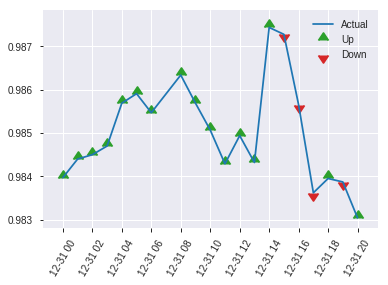


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20318411253811522
RMSE: 0.4507594841355146
LogLoss: 0.594655275645093
Null degrees of freedom: 616
Residual degrees of freedom: -422
Null deviance: 854.9589870947052
Residual deviance: 733.8046101460448
AIC: 2811.804610146045
AUC: 0.7514617105707531
pr_auc: 0.7161951686522751
Gini: 0.5029234211415061
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36775596186059173: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      159  170  0.5167   (170.0/329.0)
1      41   247  0.1424   (41.0/288.0)
Total  200  417  0.342    (211.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.367756     0.700709  258
max f2                       0.200014     0.81861   342
max f0point5                 0.576246     0.677083  149
max accuracy                 0.492151     0.696921  196
max precision                0.931392     1         0
max recall                   0.0227626    1         399
max specificity              0.931392     1         0
max absolute_mcc             0.492151     0.396205  196
max min_per_class_accuracy   0.513069     0.694444  185
max mean_per_class_accuracy  0.492151     0.698497  196

Gains/Lift Table: Avg response rate: 46.68 %, avg score: 49.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.894316           1.83631   1.83631            0.857143         0.911958  0.857143                    0.911958            0.0208333       0.0208333                  83.631    83.631
    2        0.0210697                   0.870252           2.14236   1.97756            1                0.88188   0.923077                    0.898076            0.0208333       0.0416667                  114.236   97.7564
    3        0.0307942                   0.862033           1.7853    1.91685            0.833333         0.866076  0.894737                    0.887971            0.0173611       0.0590278                  78.5301   91.6849
    4        0.0405186                   0.846191           1.7853    1.88528            0.833333         0.855319  0.88                        0.880134            0.0173611       0.0763889                  78.5301   88.5278
    5        0.0502431                   0.836618           2.14236   1.93504            1                0.840264  0.903226                    0.872417            0.0208333       0.0972222                  114.236   93.5036
    6        0.100486                    0.802574           1.79682   1.86593            0.83871          0.821108  0.870968                    0.846763            0.0902778       0.1875                     79.6819   86.5927
    7        0.150729                    0.757029           1.45128   1.72771            0.677419         0.779566  0.806452                    0.824364            0.0729167       0.260417                   45.1277   72.7711
    8        0.200972                    0.722429           1.38217   1.64133            0.645161         0.741222  0.766129                    0.803578            0.0694444       0.329861                   38.2168   64.1325
    9        0.299838                    0.643288           1.51019   1.59809            0.704918         0.682994  0.745946                    0.763818            0.149306        0.479167                   51.0189   59.8086
    10       0.400324                    0.569583           1.10573   1.4745             0.516129         0.606478  0.688259                    0.724324            0.111111        0.590278                   10.5735   47.45
    11       0.50081                     0.497049           1.17484   1.41437            0.548387         0.538861  0.660194                    0.687111            0.118056        0.708333                   17.4843   41.4374
    12       0.599676                    0.431322           0.772655  1.30858            0.360656         0.463613  0.610811                    0.650264            0.0763889       0.784722                   -22.7345  30.8577
    13       0.700162                    0.348271           0.794747  1.23483            0.370968         0.387741  0.576389                    0.612587            0.0798611       0.864583                   -20.5253  23.4833
    14       0.799028                    0.274403           0.667293  1.16461            0.311475         0.312062  0.543611                    0.575403            0.0659722       0.930556                   -33.2707  16.461
    15       0.899514                    0.17977            0.345542  1.07311            0.16129          0.226436  0.500901                    0.536419            0.0347222       0.965278                   -65.4458  7.31106
    16       1                           0.0225061          0.345542  1                  0.16129          0.113984  0.466775                    0.49397             0

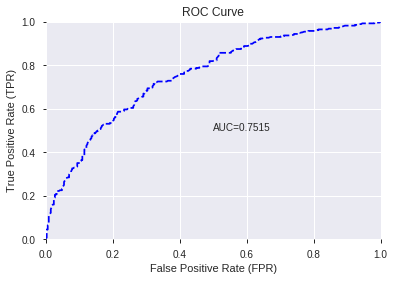

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


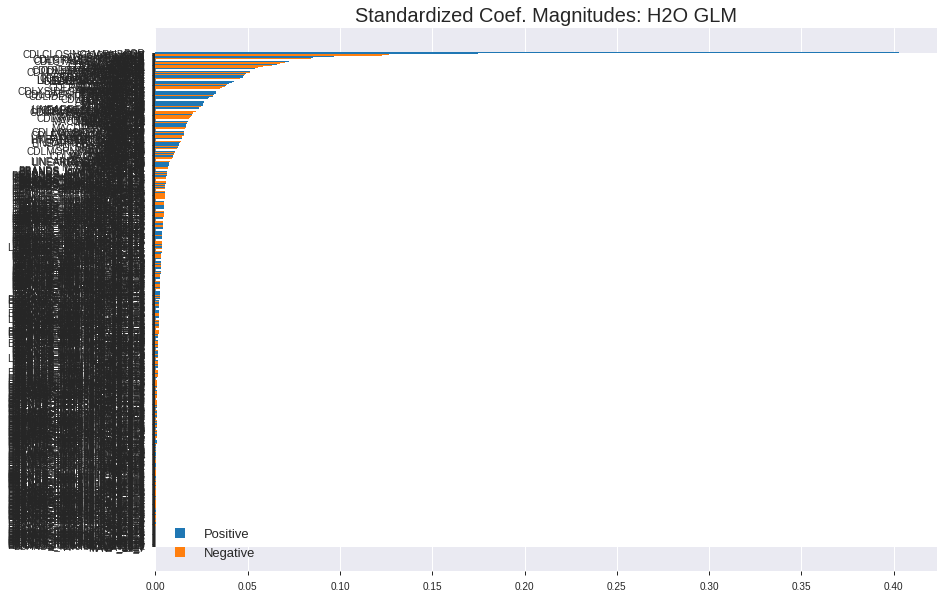

'log_likelihood'
--2019-08-24 14:23:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.21.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.21.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_142120_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_142120_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a4a9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

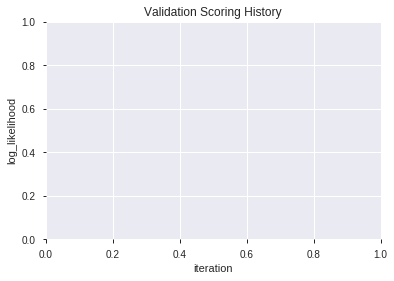

In [17]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [18]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [19]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [20]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_142445_model_6  0.762902  0.576924              0.312817  0.443996  0.197133
1               XGBoost_1_AutoML_20190824_142445  0.761055  0.581526              0.303703  0.446398  0.199271
2  XGBoost_grid_1_AutoML_20190824_142445_model_3  0.760480  0.578919              0.316948  0.445204  0.198206
3  XGBoost_grid_1_AutoML_20190824_142445_model_7  0.757245  0.583838              0.323682  0.447607  0.200352
4  XGBoost_grid_1_AutoML_20190824_142445_model_1  0.756575  0.584148              0.328895  0.447221  0.200006
5               XGBoost_3_AutoML_20190824_142445  0.756074  0.584547              0.320859  0.447723  0.200456
6  XGBoost_grid_1_AutoML_20190824_142445_model_2  0.751863  0.587174              0.313687  0.449141  0.201728
7  XGBoost_grid_1_AutoML_20190824_142445_model_4  0.750739  0.588283              0.320204  0.449801  0.202321
8               XGBoost_2_AutoML_20190824_142445  0.744707  0.596544              0.315851  0.453321  0.205500
9  XGBoost_grid_1_AutoML_20190824_142445_model_5  0.733420  0.617491              0.357122  0.461789  0.213249

variable  relative_importance  scaled_importance  percentage
0                        BOP          4316.240234           1.000000    0.218844
1                     TRANGE           946.486023           0.219285    0.047989
2               STOCHF_fastk           838.122314           0.194179    0.042495
3             STOCHRSI_fastk           800.907349           0.185557    0.040608
4                       hour           520.985718           0.120704    0.026415
..                       ...                  ...                ...         ...
299  BBANDS_upperband_14_5_5             3.485027           0.000807    0.000177
300  BBANDS_lowerband_20_0_2             3.423633           0.000793    0.000174
301  BBANDS_upperband_12_1_4             2.888676           0.000669    0.000146
302  BBANDS_lowerband_12_7_5             2.298422           0.000533    0.000117
303                    Close             2.285161           0.000529    0.000116

[304 rows x 4 columns]

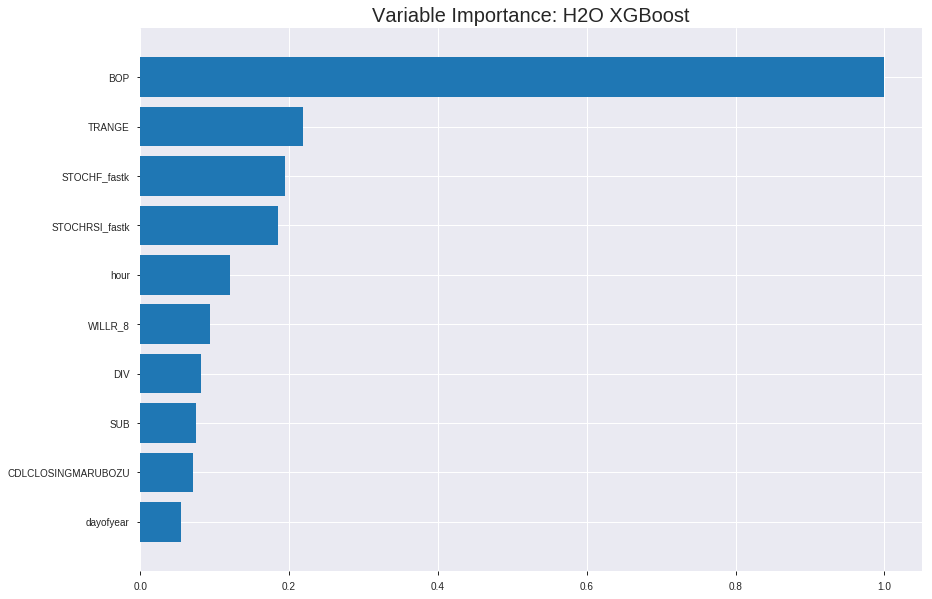

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_142445_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1470863602463618
RMSE: 0.38351839622938794
LogLoss: 0.46087436221135863
Mean Per-Class Error: 0.20378809740791182
AUC: 0.8914437566634311
pr_auc: 0.8962658739250053
Gini: 0.7828875133268622
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44602715637948775: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1554  613   0.2829   (613.0/2167.0)
1      297   1849  0.1384   (297.0/2146.0)
Total  1851  2462  0.211    (910.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.446027     0.802517  222
max f2                       0.303025     0.883301  288
max f0point5                 0.610292     0.825742  144
max accuracy                 0.509106     0.796198  194
max precision                0.954982     1         0
max recall                   0.143129     1         364
max specificity              0.954982     1         0
max absolute_mcc             0.558889     0.594004  171
max min_per_class_accuracy   0.510715     0.79557   193
max mean_per_class_accuracy  0.50707      0.796212  195

Gains/Lift Table: Avg response rate: 49.76 %, avg score: 49.75 %



group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ----------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.923976           2.00979     2.00979            1                0.93783   1                           0.93783             0.0205033       0.0205033                  100.979   100.979
    2        0.0201716                   0.908657           2.00979     2.00979            1                0.914335  1                           0.926217            0.0200373       0.0405405                  100.979   100.979
    3        0.0301414                   0.893993           2.00979     2.00979            1                0.901865  1                           0.918162            0.0200373       0.0605778                  100.979   100.979
    4        0.0401113                   0.879876           2.00979     2.00979            1                0.885956  1                           0.910157            0.0200373       0.0806151                  100.979   100.979
    5        0.0500812                   0.866448           2.00979     2.00979            1                0.873617  1                           0.902883            0.0200373       0.100652                   100.979   100.979
    6        0.100162                    0.809541           2.00979     2.00979            1                0.83874   1                           0.870812            0.100652        0.201305                   100.979   100.979
    7        0.150012                    0.762592           1.90696     1.97562            0.948837         0.785821  0.982998                    0.842569            0.0950606       0.296365                   90.6959   97.5616
    8        0.200093                    0.72085            1.89813     1.95622            0.944444         0.739884  0.973349                    0.816868            0.0950606       0.391426                   89.8131   95.6222
    9        0.300023                    0.655184           1.62275     1.84515            0.807425         0.686806  0.918083                    0.773548            0.162162        0.553588                   62.275    84.5151
    10       0.399954                    0.59116            1.37094     1.72667            0.682135         0.623308  0.85913                     0.73601             0.136999        0.690587                   37.0944   72.6668
    11       0.500116                    0.508455           1.07002     1.59516            0.532407         0.551585  0.793695                    0.699073            0.107176        0.797763                   7.00248   59.5157
    12       0.600046                    0.420028           0.867332    1.47395            0.431555         0.463419  0.733385                    0.659828            0.0866729       0.884436                   -13.2668  47.3946
    13       0.699977                    0.33674            0.615526    1.3514             0.306265         0.376688  0.672408                    0.619406            0.0615098       0.945946                   -38.4474  35.1396
    14       0.799907                    0.261222           0.415014    1.23442            0.206497         0.297818  0.614203                    0.579231            0.0414725       0.987418                   -58.4986  23.4416
    15       0.899838                    0.179128           0.116577    1.11028            0.0580046        0.220984  0.552435                    0.539446            0.0116496       0.999068                   -88.3423  11.0276
    16       1                           0.0433505          0.00930456  1                  0.00462963       0.121014  0.497565 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2005386863596939
RMSE: 0.44781546016154233
LogLoss: 0.5881663650008903
Mean Per-Class Error: 0.2991976351351351
AUC: 0.7607078758445946
pr_auc: 0.7444779965675355
Gini: 0.5214157516891893
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3209061995148659: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      271  321  0.5422   (321.0/592.0)
1      78   562  0.1219   (78.0/640.0)
Total  349  883  0.3239   (399.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.320906     0.738017  284
max f2                       0.151305     0.852012  362
max f0point5                 0.568221     0.719357  162
max accuracy                 0.49368      0.700487  202
max precision                0.876771     0.88      15
max recall                   0.0561351    1         397
max specificity              0.942222     0.998311  0
max absolute_mcc             0.519171     0.401658  189
max min_per_class_accuracy   0.497024     0.699324  200
max mean_per_class_accuracy  0.519171     0.700802  189

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 48.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.911115           1.62885   1.62885            0.846154         0.924364  0.846154                    0.924364            0.0171875       0.0171875                  62.8846   62.8846
    2        0.0202922                   0.874829           1.76458   1.694              0.916667         0.895007  0.88                        0.910273            0.0171875       0.034375                   76.4583   69.4
    3        0.0300325                   0.860314           1.44375   1.61284            0.75             0.868286  0.837838                    0.896655            0.0140625       0.0484375                  44.375    61.2838
    4        0.0405844                   0.850354           1.77692   1.6555             0.923077         0.85502   0.86                        0.88583             0.01875         0.0671875                  77.6923   65.55
    5        0.0503247                   0.830956           1.44375   1.61452            0.75             0.841413  0.83871                     0.877233            0.0140625       0.08125                    44.375    61.4516
    6        0.100649                    0.778385           1.49032   1.55242            0.774194         0.803301  0.806452                    0.840267            0.075           0.15625                    49.0323   55.2419
    7        0.150162                    0.733166           1.45164   1.51919            0.754098         0.755454  0.789189                    0.812302            0.071875        0.228125                   45.1639   51.9189
    8        0.200487                    0.693397           1.67661   1.5587             0.870968         0.71468   0.809717                    0.787797            0.084375        0.3125                     67.6613   55.8704
    9        0.300325                    0.623249           1.53374   1.55041            0.796748         0.657873  0.805405                    0.744606            0.153125        0.465625                   53.374    55.0405
    10       0.400162                    0.574942           1.22073   1.46815            0.634146         0.599636  0.762677                    0.708437            0.121875        0.5875                     22.0732   46.8154
    11       0.5                         0.503041           1.03293   1.38125            0.536585         0.539798  0.717532                    0.674764            0.103125        0.690625                   3.29268   38.125
    12       0.599838                    0.41192            0.939024  1.30765            0.487805         0.457673  0.679296                    0.638631            0.09375         0.784375                   -6.09756  30.7645
    13       0.699675                    0.331377           0.78252   1.23271            0.406504         0.374741  0.640371                    0.600976            0.078125        0.8625                     -21.748   23.2715
    14       0.799513                    0.255485           0.563415  1.14914            0.292683         0.29346   0.596954                    0.562576            0.05625         0.91875                    -43.6585  14.9137
    15       0.899351                    0.17549            0.547764  1.08238            0.284553         0.216736  0.562274                    0.524184            0.0546875       0.973437                   -45.2236  8.23782
    16       1                           0.0463394          0.263911  1                  0.137097         0.123907  0.519481                    0.483896            0.0


Scoring History: 


timestamp            duration          number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 14:26:30  1 min  1.865 sec  0                  0.5              0.693147            0.5             0                  1                0.502435                         0.5                0.693147              0.5               0                    1                  0.480519
    2019-08-24 14:26:31  1 min  2.991 sec  5                  0.474071         0.642285            0.811234        0.807464           2.00979          0.297936                         0.481243           0.656101              0.733955          0.710229             1.41167            0.332792
    2019-08-24 14:26:31  1 min  3.385 sec  10                 0.456102         0.607514            0.822882        0.822244           2.00979          0.28843                          0.470227           0.634361              0.739106          0.719573             1.33269            0.343344
    2019-08-24 14:26:32  1 min  3.798 sec  15                 0.442402         0.580813            0.831362        0.830618           2.00979          0.287735                         0.462258           0.618393              0.745451          0.727914             1.48077            0.329545
    2019-08-24 14:26:32  1 min  4.223 sec  20                 0.432087         0.560129            0.837497        0.837376           2.00979          0.278924                         0.456946           0.607466              0.749867          0.7363               1.62885            0.310877
    2019-08-24 14:26:33  1 min  4.610 sec  25                 0.42447          0.544544            0.842828        0.844738           2.00979          0.278924                         0.453616           0.600335              0.752303          0.741791             1.62885            0.313312
    2019-08-24 14:26:33  1 min  5.044 sec  30                 0.41744          0.529949            0.848933        0.851385           2.00979          0.268491                         0.45201            0.596496              0.752333          0.742946             1.62885            0.318994
    2019-08-24 14:26:33  1 min  5.469 sec  35                 0.41195          0.51828             0.85424         0.857699           2.00979          0.24345                          0.450858           0.593874              0.753012          0.743386             1.62885            0.313312
    2019-08-24 14:26:34  1 min  5.863 sec  40                 0.406903         0.507767            0.860063        0.863904           2.00979          0.238349                         0.44997            0.592055              0.753952          0.743762             1.62885            0.316558
    2019-08-24 14:26:34  1 min  6.254 sec  45                 0.403576         0.500387            0.863238        0.86821            2.00979          0.25713                          0.449316           0.590682              0.755337          0.743509             1.62885            0.310877
    2019-08-24 14:26:35  1 min  6.627 sec  50                 0.399404         0.491915            0.868807        0.873994           2.00979          0.23348                          0.447917           0.587832              0.758381          0.746636             1.62885            0.306818
    2019-08-24 14:26:35  1 min  7.024 sec  55                 0.39482          0.482803            0.875288        0.878858           2.00979          0.232089 

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      4316.240234375         1.0                    0.21884374672595844
TRANGE                   946.4860229492188      0.21928483391895162    0.04798911465500291
STOCHF_fastk             838.122314453125       0.19417879194448656    0.042494814363851795
STOCHRSI_fastk           800.9073486328125      0.1855567125884932     0.040607926213017675
hour                     520.9857177734375      0.12070359606591204    0.026415227206360845
---                      ---                    ---                    ---
BBANDS_upperband_14_5_5  3.485027313232422      0.0008074219978483335  0.00017669925519808805
BBANDS_lowerband_20_0_2  3.4236326217651367     0.0007931978842370634  0.000173586396881542
BBANDS_upperband_12_1_4  2.8886756896972656     0.0006692573936667247  0.00014646279555407578
BBANDS_lowerband_12_7_5  2.298421859741211      0.0005325055453207476  0.00011653550869034207
Close                    2.285160541534424      0.0005294331217560969  0.00011586312800592479


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6985413290113452)

('F1', 0.7069219440353461)

('auc', 0.7629021023302938)

('logloss', 0.5769237551772851)

('mean_per_class_error', 0.30431019925700775)

('rmse', 0.4439961062974549)

('mse', 0.19713254240730085)

xgboost prediction progress: |████████████████████████████████████████████| 100%


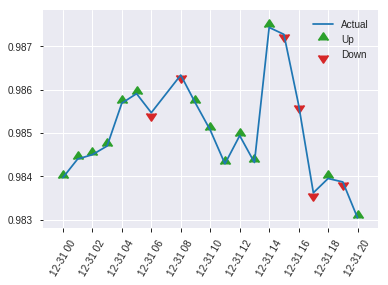


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19713254240730085
RMSE: 0.4439961062974549
LogLoss: 0.5769237551772851
Mean Per-Class Error: 0.30431019925700775
AUC: 0.7629021023302938
pr_auc: 0.7326208931844829
Gini: 0.5258042046605875
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3497837881247203: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      178  151  0.459    (151.0/329.0)
1      48   240  0.1667   (48.0/288.0)
Total  226  391  0.3225   (199.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.349784     0.706922  257
max f2                       0.125701     0.824713  375
max f0point5                 0.605876     0.690909  134
max accuracy                 0.511354     0.698541  180
max precision                0.952641     1         0
max recall                   0.0728197    1         397
max specificity              0.952641     1         0
max absolute_mcc             0.605876     0.395802  134
max min_per_class_accuracy   0.486266     0.68997   197
max mean_per_class_accuracy  0.508954     0.69569   182

Gains/Lift Table: Avg response rate: 46.68 %, avg score: 47.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.90142            2.14236   2.14236            1                0.923204  1                           0.923204            0.0243056       0.0243056                  114.236   114.236
    2        0.0210697                   0.89033            1.7853    1.97756            0.833333         0.893057  0.923077                    0.90929             0.0173611       0.0416667                  78.5301   97.7564
    3        0.0307942                   0.879451           1.7853    1.91685            0.833333         0.883717  0.894737                    0.901214            0.0173611       0.0590278                  78.5301   91.6849
    4        0.0405186                   0.868589           2.14236   1.97097            1                0.875911  0.92                        0.895142            0.0208333       0.0798611                  114.236   97.0972
    5        0.0502431                   0.850753           2.14236   2.00414            1                0.859664  0.935484                    0.888275            0.0208333       0.100694                   114.236   100.414
    6        0.100486                    0.782924           1.72771   1.86593            0.806452         0.817623  0.870968                    0.852949            0.0868056       0.1875                     72.7711   86.5927
    7        0.150729                    0.729873           1.45128   1.72771            0.677419         0.75442   0.806452                    0.820106            0.0729167       0.260417                   45.1277   72.7711
    8        0.200972                    0.692846           1.38217   1.64133            0.645161         0.71101   0.766129                    0.792832            0.0694444       0.329861                   38.2168   64.1325
    9        0.299838                    0.629541           1.54531   1.60967            0.721311         0.65842   0.751351                    0.748512            0.152778        0.482639                   54.531    60.9666
    10       0.400324                    0.550581           1.10573   1.48317            0.516129         0.587232  0.692308                    0.708029            0.111111        0.59375                    10.5735   48.3173
    11       0.50081                     0.476444           1.07118   1.40051            0.5              0.508093  0.653722                    0.667912            0.107639        0.701389                   7.11806   40.0508
    12       0.599676                    0.378719           0.948258  1.32595            0.442623         0.433229  0.618919                    0.629221            0.09375         0.795139                   -5.17418  32.5948
    13       0.700162                    0.296079           0.794747  1.24971            0.370968         0.333989  0.583333                    0.58685             0.0798611       0.875                      -20.5253  24.9711
    14       0.799028                    0.241578           0.597051  1.16896            0.278689         0.264565  0.545639                    0.546973            0.0590278       0.934028                   -40.2949  16.8956
    15       0.899514                    0.165433           0.380096  1.08083            0.177419         0.210485  0.504505                    0.509383            0.0381944       0.972222                   -61.9904  8.08308
    16       1                           0.0562128          0.276434  1                  0.129032         0.123536  0.466775                    0.470611         

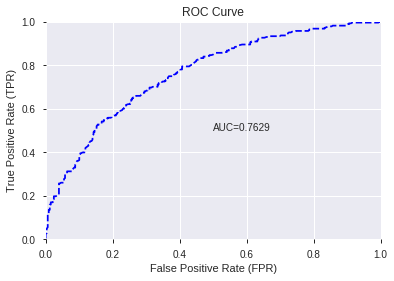

This function is available for GLM models only


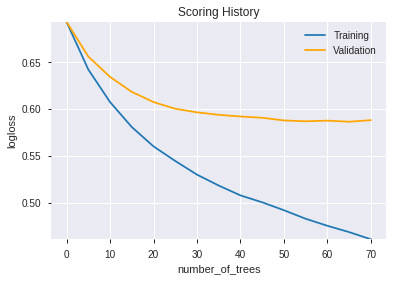

--2019-08-24 14:26:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(Sha

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_142445_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_142445_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a4a9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [21]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_142751_model_8  0.752580  0.598131              0.351048  0.452742  0.204976
1  DeepLearning_grid_1_AutoML_20190824_142751_model_6  0.749958  0.595594              0.335840  0.451057  0.203452
2               DeepLearning_1_AutoML_20190824_142751  0.749388  0.637739              0.297825  0.467582  0.218633
3  DeepLearning_grid_1_AutoML_20190824_142751_model_9  0.749161  0.594100              0.336489  0.451203  0.203584
4  DeepLearning_grid_1_AutoML_20190824_142751_model_5  0.745541  0.600197              0.320632  0.453315  0.205494
5  DeepLearning_grid_1_AutoML_20190824_142751_model_3  0.744760  0.626878              0.336051  0.456153  0.208075
6  DeepLearning_grid_1_AutoML_20190824_142751_model_2  0.733874  0.650463              0.319977  0.460921  0.212448
7  DeepLearning_grid_1_AutoML_20190824_142751_model_4  0.732354  0.641177              0.341043  0.463759  0.215073
8  DeepLearning_grid_1_AutoML_20190824_142751_model_7  0.731705  0.626182              0.338658  0.461107  0.212620
9  DeepLearning_grid_1_AutoML_20190824_142751_model_1  0.723811  0.767433              0.321714  0.473172  0.223892

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.044969
1    CDLCLOSINGMARUBOZU             0.903270           0.903270    0.040619
2          HT_TRENDMODE             0.605070           0.605070    0.027209
3                TRANGE             0.599241           0.599241    0.026947
4                SAREXT             0.582424           0.582424    0.026191
5          CDLENGULFING             0.529624           0.529624    0.023817
6                   SUB             0.518656           0.518656    0.023323
7          CDLSHORTLINE             0.515735           0.515735    0.023192
8                   DIV             0.499834           0.499834    0.022477
9        STOCHRSI_fastk             0.484967           0.484967    0.021808
10        days_in_month             0.484198           0.484198    0.021774
11         STOCHF_fastk             0.478040           0.478040    0.021497
12          CDLLONGLINE             0.475712           0.475712    0.021392
13    CDLSTALLEDPATTERN             0.462152           0.462152    0.020782
14       CDLEVENINGSTAR             0.450853           0.450853    0.020274
15          CDLPIERCING             0.440337           0.440337    0.019801
16              WILLR_8             0.438785           0.438785    0.019732
17            CORREL_20             0.423496           0.423496    0.019044
18       CDLMORNINGSTAR             0.421227           0.421227    0.018942
19                FLOOR             0.420557           0.420557    0.018912
20    CDLGRAVESTONEDOJI             0.418398           0.418398    0.018815
21     CDLDRAGONFLYDOJI             0.417214           0.417214    0.018762
22             CORREL_8             0.415421           0.415421    0.018681
23     is_quarter_start             0.414063           0.414063    0.018620
24                 CEIL             0.410271           0.410271    0.018449
25      CDLADVANCEBLOCK             0.409986           0.409986    0.018437
26            CDLTAKURI             0.409934           0.409934    0.018434
27        CDLHANGINGMAN             0.409764           0.409764    0.018427
28            CORREL_14             0.401885           0.401885    0.018072
29     CDLSTICKSANDWICH             0.401647           0.401647    0.018062
30   CDLEVENINGDOJISTAR             0.399740           0.399740    0.017976
31   CDLMORNINGDOJISTAR             0.395222           0.395222    0.017773
32            CDLONNECK             0.395004           0.395004    0.017763
33  CDLGAPSIDESIDEWHITE             0.393905           0.393905    0.017713
34            CORREL_12             0.391465           0.391465    0.017604
35    CDLDARKCLOUDCOVER             0.391244           0.391244    0.017594
36    CDL3WHITESOLDIERS             0.391046           0.391046    0.017585
37   CDLIDENTICAL3CROWS             0.384967           0.384967    0.017312
38      CDLHOMINGPIGEON             0.383268           0.383268    0.017235
39            CDL2CROWS             0.382515           0.382515    0.017201
40       is_month_start             0.370379           0.370379    0.016656
41      CDLLADDERBOTTOM             0.363971           0.363971    0.016367
42   CDLSEPARATINGLINES             0.363820           0.363820    0.016361
43         CDLTHRUSTING             0.358563           0.358563    0.016124
44            CDLHAMMER             0.352895           0.352895    0.015869
45    CDLINVERTEDHAMMER             0.345651           0.345651    0.015544
46         is_month_end             0.343264           0.343264    0.015436
47       CDLMATCHINGLOW             0.336248           0.336248    0.015121
48        CDLHIKKAKEMOD             0.328125           0.328125    0.014755
49      CDLSHOOTINGSTAR             0.323545           0.323545    0.014549

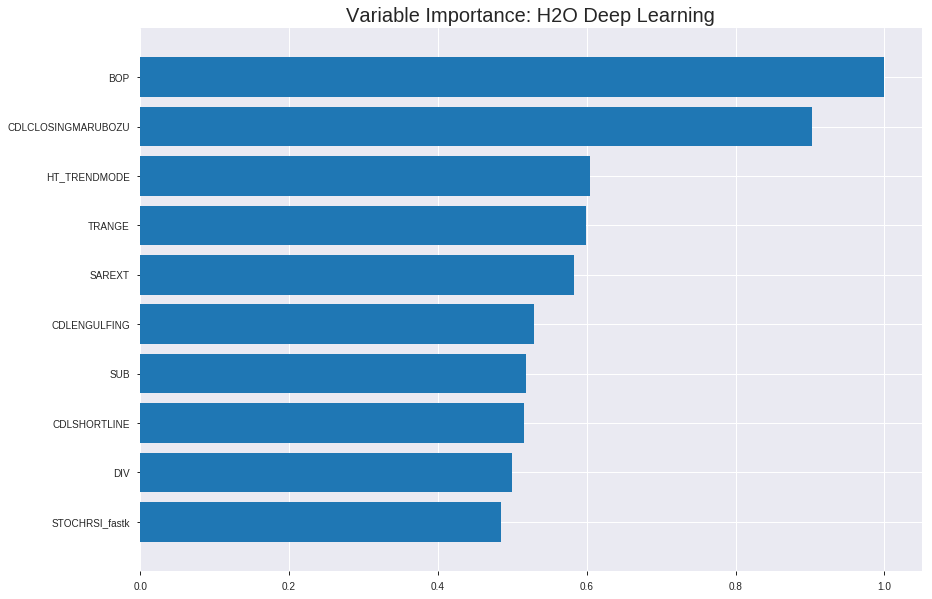

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_142751_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19549963119890768
RMSE: 0.44215340233781725
LogLoss: 0.573719203572537
Mean Per-Class Error: 0.2918146294218411
AUC: 0.7760609773562688
pr_auc: 0.7642702594433519
Gini: 0.5521219547125376
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.391366635398348: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      956   1211  0.5588   (1211.0/2167.0)
1      223   1923  0.1039   (223.0/2146.0)
Total  1179  3134  0.3325   (1434.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.391367     0.728409  267
max f2                       0.259615     0.846595  327
max f0point5                 0.519716     0.70826   191
max accuracy                 0.499291     0.708092  205
max precision                0.984561     1         0
max recall                   0.0966506    1         388
max specificity              0.984561     1         0
max absolute_mcc             0.499291     0.416642  205
max min_per_class_accuracy   0.50746      0.706897  200
max mean_per_class_accuracy  0.499291     0.708185  205

Gains/Lift Table: Avg response rate: 49.76 %, avg score: 50.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.92976            1.91843   1.91843            0.954545         0.949291  0.954545                    0.949291            0.0195713       0.0195713                  91.8432   91.8432
    2        0.0201716                   0.910863           1.86957   1.89428            0.930233         0.919301  0.942529                    0.934469            0.0186393       0.0382106                  86.9568   89.4281
    3        0.0301414                   0.901605           1.82283   1.87065            0.906977         0.906538  0.930769                    0.92523             0.0181733       0.056384                   82.2829   87.0647
    4        0.0401113                   0.89411            1.72935   1.83553            0.860465         0.897553  0.913295                    0.918351            0.0172414       0.0736253                  72.935    83.5527
    5        0.0500812                   0.884906           1.77609   1.82369            0.883721         0.88973   0.907407                    0.912653            0.0177074       0.0913327                  77.609    82.3694
    6        0.100162                    0.79167            1.73995   1.78182            0.865741         0.848001  0.886574                    0.880327            0.0871389       0.178472                   73.9953   78.1824
    7        0.150012                    0.712255           1.63587   1.73332            0.813953         0.743936  0.862442                    0.835004            0.0815471       0.260019                   63.5872   73.3324
    8        0.200093                    0.662233           1.47012   1.66745            0.731481         0.686791  0.829664                    0.797908            0.0736253       0.333644                   47.0121   66.7447
    9        0.300023                    0.585412           1.36162   1.56558            0.677494         0.61701   0.77898                     0.737655            0.136067        0.469711                   36.1618   56.5583
    10       0.399954                    0.542568           1.21706   1.4785             0.605568         0.564471  0.735652                    0.694384            0.121622        0.591333                   21.7063   47.8503
    11       0.500116                    0.506016           1.16772   1.41626            0.581019         0.524588  0.704682                    0.660378            0.116962        0.708295                   16.7723   41.6261
    12       0.600046                    0.460206           0.904637  1.33106            0.450116         0.484279  0.662287                    0.631051            0.0904007       0.798695                   -9.53633  33.1056
    13       0.699977                    0.406288           0.746092  1.24754            0.37123          0.433602  0.620735                    0.602862            0.0745573       0.873253                   -25.3908  24.7545
    14       0.799907                    0.334882           0.624852  1.16975            0.310905         0.373468  0.582029                    0.574205            0.0624418       0.935694                   -37.5148  16.9754
    15       0.899838                    0.241101           0.452318  1.09008            0.225058         0.288263  0.542386                    0.54245             0.0452004       0.980895                   -54.7682  9.00796
    16       1                           0.0114209          0.190744  1                  0.0949074        0.178462  0.497565                    0.505992         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2060616224881003
RMSE: 0.4539401089219814
LogLoss: 0.6011211140146465
Mean Per-Class Error: 0.3116131756756757
AUC: 0.7440126161317568
pr_auc: 0.7316697793072104
Gini: 0.4880252322635137
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3991260665193405: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      273  319  0.5389   (319.0/592.0)
1      89   551  0.1391   (89.0/640.0)
Total  362  870  0.3312   (408.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.399126     0.729801  264
max f2                       0.189087     0.852578  362
max f0point5                 0.49716      0.698441  213
max accuracy                 0.49716      0.689935  213
max precision                0.97572      1         0
max recall                   0.0212466    1         397
max specificity              0.97572      1         0
max absolute_mcc             0.49716      0.378168  213
max min_per_class_accuracy   0.515706     0.680743  201
max mean_per_class_accuracy  0.49716      0.688387  213

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 51.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.924651           1.48077   1.48077            0.769231         0.946548  0.769231                    0.946548            0.015625        0.015625                   48.0769   48.0769
    2        0.0202922                   0.910734           1.44375   1.463              0.75             0.918161  0.76                        0.932922            0.0140625       0.0296875                  44.375    46.3
    3        0.0300325                   0.900625           1.76458   1.56081            0.916667         0.906144  0.810811                    0.924237            0.0171875       0.046875                   76.4583   56.0811
    4        0.0405844                   0.892481           1.62885   1.5785             0.846154         0.896466  0.82                        0.917017            0.0171875       0.0640625                  62.8846   57.85
    5        0.0503247                   0.881082           1.60417   1.58347            0.833333         0.88639   0.822581                    0.911089            0.015625        0.0796875                  60.4167   58.3468
    6        0.100649                    0.812129           1.67661   1.63004            0.870968         0.84911   0.846774                    0.8801              0.084375        0.164062                   67.6613   63.004
    7        0.150162                    0.729241           1.51475   1.59203            0.786885         0.765482  0.827027                    0.842307            0.075           0.239063                   51.4754   59.2027
    8        0.200487                    0.68829            1.39718   1.54312            0.725806         0.710534  0.801619                    0.80923             0.0703125       0.309375                   39.7177   54.3117
    9        0.300325                    0.598715           1.23638   1.44115            0.642276         0.638955  0.748649                    0.752625            0.123438        0.432812                   23.6382   44.1149
    10       0.400162                    0.553961           1.31463   1.40958            0.682927         0.576894  0.732252                    0.708782            0.13125         0.564063                   31.4634   40.9584
    11       0.5                         0.518373           1.07988   1.34375            0.560976         0.536845  0.698052                    0.67445             0.107813        0.671875                   7.9878    34.375
    12       0.599838                    0.474782           0.939024  1.27639            0.487805         0.495503  0.663058                    0.644666            0.09375         0.765625                   -6.09756  27.6387
    13       0.699675                    0.400649           0.845122  1.21485            0.439024         0.438733  0.63109                     0.615281            0.084375        0.85                       -15.4878  21.4849
    14       0.799513                    0.325894           0.672967  1.14718            0.349593         0.364122  0.595939                    0.583918            0.0671875       0.917188                   -32.7033  14.7183
    15       0.899351                    0.232729           0.579065  1.08412            0.300813         0.282657  0.563177                    0.550475            0.0578125       0.975                      -42.0935  8.41155
    16       1                           0.00995094         0.248387  1                  0.129032         0.173651  0.519481                    0.512548            0.02


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 14:41:01  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 14:41:03  3 min 33.079 sec  527 obs/sec       0.258984  1             1117       0.456395         0.605234            0.166793       0.747086        0.727461           1.64437          0.350104                         0.460917           0.615429              0.14893          0.733132          0.709431             1.33269            0.374188
    2019-08-24 14:41:36  4 min  5.524 sec  1001 obs/sec      7.2984    28            31478      0.442153         0.573719            0.217983       0.776061        0.76427            1.91843          0.332483                         0.45394            0.601121              0.1745           0.744013          0.73167              1.48077            0.331169
    2019-08-24 14:42:08  4 min 37.395 sec  1140 obs/sec      15.8734   61            68462      0.443937         0.575354            0.211661       0.782368        0.771769           1.91843          0.305124                         0.455707           0.603907              0.168063         0.744106          0.732482             1.48077            0.333604
    2019-08-24 14:42:41  5 min 10.194 sec  1229 obs/sec      25.5931   98            110383     0.443029         0.576051            0.214881       0.789725        0.778301           1.91843          0.290517                         0.456214           0.605049              0.166211         0.744634          0.738268             1.48077            0.340097
    2019-08-24 14:43:12  5 min 41.670 sec  1290 obs/sec      35.2801   135           152163     0.436085         0.560231            0.239303       0.796719        0.786587           1.91843          0.285416                         0.455411           0.603677              0.16914          0.741596          0.733561             1.48077            0.348214
    2019-08-24 14:43:45  6 min 14.981 sec  1333 obs/sec      45.7997   175           197534     0.424359         0.533473            0.279659       0.80936         0.801636           1.96411          0.271737                         0.45582            0.609794              0.167649         0.741928          0.734159             1.62885            0.352273
    2019-08-24 14:43:48  6 min 18.203 sec  1333 obs/sec      45.7997   175           197534     0.442153         0.573719            0.217983       0.776061        0.76427            1.91843          0.332483                         0.45394            0.601121              0.1745           0.744013          0.73167              1.48077            0.331169

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.04496888316377121
CDLCLOSINGMARUBOZU  0.9032697081565857     0.9032697081565857   0.04061902997146723
HT_TRENDMODE        0.6050697565078735     0.6050697565078735   0.027209311186334063
TRANGE              0.5992410778999329     0.5992410778999329   0.026947202019014408
SAREXT              0.582423746585846      0.582423746585846    0.0261909454120248
---                 ---                    ---                  ---
CDLINVERTEDHAMMER   0.3456507921218872     0.3456507921218872   0.015543530086394117
is_month_end        0.34326380491256714    0.34326380491256714  0.015436189937464788
CDLMATCHINGLOW      0.33624768257141113    0.33624768257141113  0.015120682751642618
CDLHIKKAKEMOD       0.3281254768371582     0.3281254768371582   0.014755436230946885
CDLSHOOTINGSTAR     0.3235452175140381     0.3235452175140381   0.014549467084585724


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6985413290113452)

('F1', 0.7007874015748032)

('auc', 0.7525804204660588)

('logloss', 0.5981314980282618)

('mean_per_class_error', 0.3028115501519757)

('rmse', 0.4527424148790841)

('mse', 0.20497569423054474)

deeplearning prediction progress: |███████████████████████████████████████| 100%


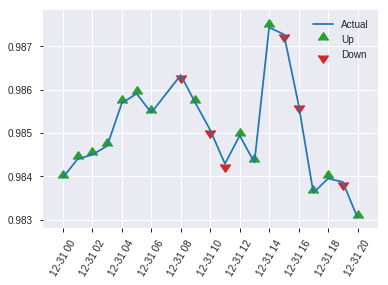


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20497569423054474
RMSE: 0.4527424148790841
LogLoss: 0.5981314980282618
Mean Per-Class Error: 0.3028115501519757
AUC: 0.7525804204660588
pr_auc: 0.7067563764258746
Gini: 0.5051608409321175
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3632134615002651: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      122  207  0.6292   (207.0/329.0)
1      21   267  0.0729   (21.0/288.0)
Total  143  474  0.3695   (228.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.363213     0.700787  294
max f2                       0.215856     0.825635  367
max f0point5                 0.543204     0.684335  164
max accuracy                 0.543204     0.698541  164
max precision                0.940673     1         0
max recall                   0.0766456    1         397
max specificity              0.940673     1         0
max absolute_mcc             0.489343     0.394752  208
max min_per_class_accuracy   0.506559     0.693009  194
max mean_per_class_accuracy  0.489343     0.697188  208

Gains/Lift Table: Avg response rate: 46.68 %, avg score: 51.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.92095            1.53026   1.53026            0.714286         0.929914  0.714286                    0.929914            0.0173611       0.0173611                  53.0258   53.0258
    2        0.0210697                   0.909198           1.7853    1.64797            0.833333         0.914222  0.769231                    0.922672            0.0173611       0.0347222                  78.5301   64.797
    3        0.0307942                   0.900387           2.14236   1.80409            1                0.904169  0.842105                    0.916829            0.0208333       0.0555556                  114.236   80.4094
    4        0.0405186                   0.895047           2.14236   1.88528            1                0.897947  0.88                        0.912297            0.0208333       0.0763889                  114.236   88.5278
    5        0.0502431                   0.885652           1.7853    1.86593            0.833333         0.891087  0.870968                    0.908192            0.0173611       0.09375                    78.5301   86.5927
    6        0.100486                    0.812251           1.79682   1.83137            0.83871          0.859316  0.854839                    0.883754            0.0902778       0.184028                   79.6819   83.1373
    7        0.150729                    0.719583           1.45128   1.70467            0.677419         0.754589  0.795699                    0.840699            0.0729167       0.256944                   45.1277   70.4674
    8        0.200972                    0.673167           1.38217   1.62405            0.645161         0.699301  0.758065                    0.80535             0.0694444       0.326389                   38.2168   62.4048
    9        0.299838                    0.585169           1.54531   1.59809            0.721311         0.623558  0.745946                    0.745407            0.152778        0.479167                   54.531    59.8086
    10       0.400324                    0.53918            1.24395   1.50919            0.580645         0.562829  0.704453                    0.699578            0.125           0.604167                   24.3952   50.9194
    11       0.50081                     0.502773           1.03663   1.41437            0.483871         0.520588  0.660194                    0.663664            0.104167        0.708333                   3.66263   41.4374
    12       0.599676                    0.453489           0.772655  1.30858            0.360656         0.480324  0.610811                    0.633438            0.0763889       0.784722                   -22.7345  30.8577
    13       0.700162                    0.4037             0.691084  1.21996            0.322581         0.429982  0.569444                    0.604238            0.0694444       0.854167                   -30.8916  21.9956
    14       0.799028                    0.34331            0.807776  1.16896            0.377049         0.372422  0.545639                    0.575555            0.0798611       0.934028                   -19.2224  16.8956
    15       0.899514                    0.276105           0.345542  1.07697            0.16129          0.309561  0.502703                    0.54584             0.0347222       0.96875                    -65.4458  7.69707
    16       1                           0.0556977          0.310988  1                  0.145161         0.191912  0.466775                    0.510275          

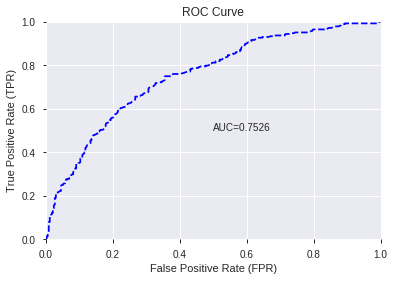

This function is available for GLM models only


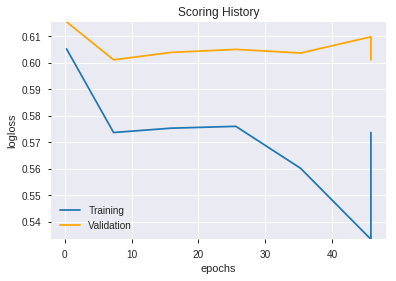

--2019-08-24 14:49:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.187.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.187.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_142751_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_142751_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a4a9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'HT_TRENDMODE',
 'TRANGE',
 'SAREXT',
 'CDLENGULFING',
 'SUB',
 'CDLSHORTLINE',
 'DIV',
 'STOCHRSI_fastk',
 'days_in_month',
 'STOCHF_fastk',
 'CDLLONGLINE',
 'CDLSTALLEDPATTERN',
 'CDLEVENINGSTAR',
 'CDLPIERCING',
 'WILLR_8',
 'CORREL_20',
 'CDLMORNINGSTAR',
 'FLOOR',
 'CDLGRAVESTONEDOJI',
 'CDLDRAGONFLYDOJI',
 'CORREL_8',
 'is_quarter_start',
 'CEIL',
 'CDLADVANCEBLOCK',
 'CDLTAKURI',
 'CDLHANGINGMAN',
 'CORREL_14',
 'CDLSTICKSANDWICH',
 'CDLEVENINGDOJISTAR',
 'CDLMORNINGDOJISTAR',
 'CDLONNECK',
 'CDLGAPSIDESIDEWHITE',
 'CORREL_12',
 'CDLDARKCLOUDCOVER',
 'CDL3WHITESOLDIERS',
 'CDLIDENTICAL3CROWS',
 'CDLHOMINGPIGEON',
 'CDL2CROWS',
 'is_month_start',
 'CDLLADDERBOTTOM',
 'CDLSEPARATINGLINES',
 'CDLTHRUSTING',
 'CDLHAMMER',
 'CDLINVERTEDHAMMER',
 'is_month_end',
 'CDLMATCHINGLOW',
 'CDLHIKKAKEMOD',
 'CDLSHOOTINGSTAR']

In [22]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190824_145027_model_1  0.742602  0.604978               0.34995  0.454598  0.20666

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.519675           1.000000    0.176968
1    CDLCLOSINGMARUBOZU             0.206788           0.397919    0.070419
2          STOCHF_fastk             0.175203           0.337139    0.059663
3                   SUB             0.114656           0.220631    0.039045
4                TRANGE             0.113834           0.219048    0.038764
5               WILLR_8             0.106094           0.204154    0.036129
6                   DIV             0.102156           0.196577    0.034788
7                SAREXT             0.097237           0.187112    0.033113
8          CDLENGULFING             0.094311           0.181481    0.032116
9     CDLGRAVESTONEDOJI             0.092717           0.178413    0.031573
10    CDLSTALLEDPATTERN             0.078859           0.151747    0.026854
11         CDLSHORTLINE             0.062915           0.121066    0.021425
12    CDLDARKCLOUDCOVER             0.058927           0.113393    0.020067
13          CDLLONGLINE             0.058756           0.113063    0.020009
14            CDLTAKURI             0.058639           0.112838    0.019969
15     CDLSTICKSANDWICH             0.058481           0.112534    0.019915
16        CDLHANGINGMAN             0.057882           0.111381    0.019711
17       CDLEVENINGSTAR             0.056192           0.108130    0.019136
18   CDLSEPARATINGLINES             0.052887           0.101769    0.018010
19            CDLHAMMER             0.046325           0.089143    0.015775
20     CDLDRAGONFLYDOJI             0.046176           0.088855    0.015724
21          CDLPIERCING             0.045822           0.088175    0.015604
22      CDLADVANCEBLOCK             0.044341           0.085324    0.015100
23        days_in_month             0.042030           0.080878    0.014313
24         is_month_end             0.041053           0.078998    0.013980
25   CDLIDENTICAL3CROWS             0.039004           0.075054    0.013282
26         HT_TRENDMODE             0.037806           0.072749    0.012874
27            CDLONNECK             0.034785           0.066936    0.011845
28  CDLGAPSIDESIDEWHITE             0.034544           0.066472    0.011763
29    CDLINVERTEDHAMMER             0.033127           0.063746    0.011281
30            CDL2CROWS             0.032359           0.062268    0.011019
31       is_month_start             0.031502           0.060619    0.010728
32      CDLSHOOTINGSTAR             0.027130           0.052205    0.009239
33            CORREL_14             0.026556           0.051101    0.009043
34     is_quarter_start             0.024721           0.047570    0.008418
35      CDLLADDERBOTTOM             0.024160           0.046490    0.008227
36      CDLHOMINGPIGEON             0.021943           0.042225    0.007472
37    CDL3WHITESOLDIERS             0.021913           0.042168    0.007462
38       CDLMORNINGSTAR             0.016696           0.032127    0.005686
39   CDLEVENINGDOJISTAR             0.013986           0.026912    0.004763
40        CDLHIKKAKEMOD             0.012792           0.024614    0.004356
41            CORREL_20             0.012656           0.024354    0.004310
42         CDLTHRUSTING             0.010316           0.019851    0.003513
43       CDLMATCHINGLOW             0.010291           0.019803    0.003504
44   CDLMORNINGDOJISTAR             0.009933           0.019113    0.003382
45       STOCHRSI_fastk             0.009674           0.018615    0.003294
46            CORREL_12             0.008159           0.015700    0.002778
47                 CEIL             0.006659           0.012813    0.002268
48             CORREL_8             0.003869           0.007446    0.001318
49                FLOOR             0.000008           0.000015    0.000003

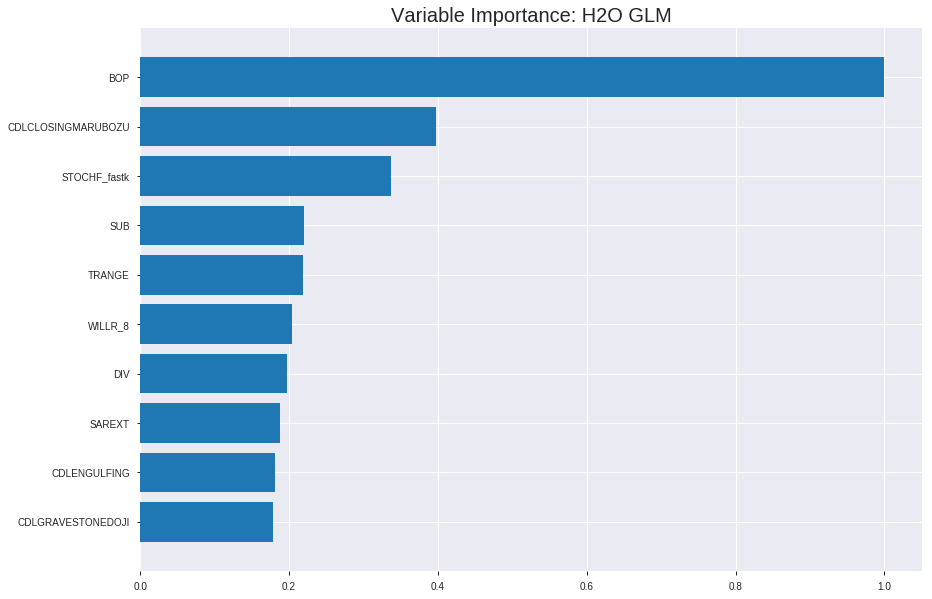

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_145027_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19470872839817926
RMSE: 0.44125811992322506
LogLoss: 0.5718881348328204
Null degrees of freedom: 4312
Residual degrees of freedom: 4262
Null deviance: 5978.985330091486
Residual deviance: 4933.107051067909
AIC: 5035.107051067909
AUC: 0.7723866555478669
pr_auc: 0.7621095590057552
Gini: 0.5447733110957338
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3992381096509065: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1141  1026  0.4735   (1026.0/2167.0)
1      330   1816  0.1538   (330.0/2146.0)
Total  1471  2842  0.3144   (1356.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.399238     0.728148  245
max f2                       0.173091     0.842109  348
max f0point5                 0.58322      0.706411  152
max accuracy                 0.455006     0.702991  218
max precision                0.965371     1         0
max recall                   0.0739224    1         388
max specificity              0.965371     1         0
max absolute_mcc             0.455006     0.41166   218
max min_per_class_accuracy   0.507029     0.698975  192
max mean_per_class_accuracy  0.455006     0.703371  218

Gains/Lift Table: Avg response rate: 49.76 %, avg score: 49.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.897373           1.91843   1.91843            0.954545         0.919226  0.954545                    0.919226            0.0195713       0.0195713                  91.8432   91.8432
    2        0.0201716                   0.878073           1.77609   1.84808            0.883721         0.887204  0.91954                     0.903399            0.0177074       0.0372787                  77.609    84.8079
    3        0.0301414                   0.860824           1.82283   1.83973            0.906977         0.869364  0.915385                    0.892141            0.0181733       0.055452                   82.2829   83.9727
    4        0.0401113                   0.848431           1.68261   1.80068            0.837209         0.854429  0.895954                    0.882768            0.0167754       0.0722274                  68.2611   80.0675
    5        0.0500812                   0.831518           1.86957   1.81439            0.930233         0.839434  0.902778                    0.874141            0.0186393       0.0908667                  86.9568   81.439
    6        0.100162                    0.777349           1.77717   1.79578            0.884259         0.802214  0.893519                    0.838178            0.0890028       0.17987                    77.7172   79.5781
    7        0.150012                    0.736525           1.62652   1.73954            0.809302         0.756306  0.865533                    0.810971            0.0810811       0.260951                   62.6524   73.9536
    8        0.200093                    0.704832           1.39568   1.65347            0.694444         0.721282  0.822711                    0.788523            0.0698975       0.330848                   39.5684   65.3474
    9        0.300023                    0.639281           1.35696   1.55471            0.675174         0.671396  0.77357                     0.749511            0.135601        0.466449                   35.6955   55.4711
    10       0.399954                    0.573637           1.27302   1.48433            0.633411         0.606743  0.738551                    0.71384             0.127213        0.593663                   27.302    48.4329
    11       0.500116                    0.505371           1.07002   1.40135            0.532407         0.540161  0.697265                    0.679056            0.107176        0.700839                   7.00248   40.1353
    12       0.600046                    0.438134           0.960594  1.32795            0.477958         0.472743  0.660742                    0.644697            0.0959925       0.796831                   -3.94064  32.795
    13       0.699977                    0.366138           0.755418  1.24621            0.37587          0.403782  0.620073                    0.610303            0.0754893       0.872321                   -24.4582  24.6214
    14       0.799907                    0.290881           0.592211  1.16451            0.294664         0.330032  0.57942                     0.57529             0.0591799       0.9315                     -40.7789  16.4511
    15       0.899838                    0.193037           0.452318  1.08542            0.225058         0.246521  0.540067                    0.538779            0.0452004       0.976701                   -54.7682  8.54189
    16       1                           0.0178596          0.232614  1                  0.115741         0.127316  0.497565                    0.497566           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20651368660728797
RMSE: 0.45443776978513567
LogLoss: 0.6012556931844808
Null degrees of freedom: 1231
Residual degrees of freedom: 1181
Null deviance: 1708.411288237215
Residual deviance: 1481.4940280065607
AIC: 1583.4940280065607
AUC: 0.7402185388513514
pr_auc: 0.7263712670609269
Gini: 0.4804370777027027
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38236714396403154: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      278  314  0.5304   (314.0/592.0)
1      98   542  0.1531   (98.0/640.0)
Total  376  856  0.3344   (412.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.382367     0.724599  263
max f2                       0.190831     0.854782  351
max f0point5                 0.59873      0.701788  151
max accuracy                 0.480852     0.681006  212
max precision                0.958991     1         0
max recall                   0.0246175    1         398
max specificity              0.958991     1         0
max absolute_mcc             0.59873      0.366351  151
max min_per_class_accuracy   0.521185     0.678125  191
max mean_per_class_accuracy  0.517645     0.680089  193

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 50.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.887676           1.48077   1.48077            0.769231         0.919192  0.769231                    0.919192            0.015625        0.015625                   48.0769   48.0769
    2        0.0202922                   0.872916           1.44375   1.463              0.75             0.880562  0.76                        0.90065             0.0140625       0.0296875                  44.375    46.3
    3        0.0300325                   0.860975           1.60417   1.50878            0.833333         0.867341  0.783784                    0.889847            0.015625        0.0453125                  60.4167   50.8784
    4        0.0405844                   0.845784           1.77692   1.5785             0.923077         0.852683  0.82                        0.880184            0.01875         0.0640625                  77.6923   57.85
    5        0.0503247                   0.828085           1.60417   1.58347            0.833333         0.833164  0.822581                    0.871083            0.015625        0.0796875                  60.4167   58.3468
    6        0.100649                    0.789576           1.49032   1.5369             0.774194         0.809393  0.798387                    0.840238            0.075           0.154688                   49.0323   53.6895
    7        0.150162                    0.756785           1.54631   1.54               0.803279         0.773788  0.8                         0.818328            0.0765625       0.23125                    54.6311   54
    8        0.200487                    0.718967           1.49032   1.52753            0.774194         0.73767   0.793522                    0.798082            0.075           0.30625                    49.0323   52.753
    9        0.300325                    0.656072           1.31463   1.45676            0.682927         0.685404  0.756757                    0.760624            0.13125         0.4375                     31.4634   45.6757
    10       0.400162                    0.589851           1.34593   1.42911            0.699187         0.623605  0.742394                    0.726439            0.134375        0.571875                   34.5935   42.9108
    11       0.5                         0.524458           0.970325  1.3375             0.504065         0.557034  0.694805                    0.692613            0.096875        0.66875                    -2.96748  33.75
    12       0.599838                    0.452886           0.954675  1.27378            0.495935         0.489622  0.661705                    0.658827            0.0953125       0.764062                   -4.53252  27.3782
    13       0.699675                    0.376755           0.845122  1.21262            0.439024         0.415725  0.62993                     0.624138            0.084375        0.848437                   -15.4878  21.2616
    14       0.799513                    0.288031           0.641667  1.14132            0.333333         0.336625  0.592893                    0.588235            0.0640625       0.9125                     -35.8333  14.132
    15       0.899351                    0.212265           0.641667  1.08585            0.333333         0.250279  0.564079                    0.550719            0.0640625       0.976562                   -35.8333  8.58529
    16       1                           0.0105128          0.232863  1                  0.120968         0.142366  0.519481                    0.509618            0.0234375  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 14:50:28  0.000 sec   2            21        49            1.36989           1.37223
    2019-08-24 14:50:28  0.016 sec   4            13        50            1.36092           1.36434
    2019-08-24 14:50:28  0.030 sec   6            8.2       50            1.34786           1.35291
    2019-08-24 14:50:28  0.045 sec   8            5.1       50            1.32979           1.3372
    2019-08-24 14:50:28  0.062 sec   10           3.2       50            1.30655           1.31722
    2019-08-24 14:50:28  0.085 sec   12           2         51            1.27929           1.29417
    2019-08-24 14:50:28  0.114 sec   14           1.2       51            1.25059           1.27053
    2019-08-24 14:50:28  0.128 sec   16           0.76      51            1.2234            1.24901
    2019-08-24 14:50:28  0.139 sec   18           0.47      51            1.20001           1.23158
    2019-08-24 14:50:28  0.152 sec   20           0.29      51            1.18136           1.21892
    2019-08-24 14:50:28  0.170 sec   22           0.18      51            1.16722           1.21062
    2019-08-24 14:50:28  0.183 sec   24           0.11      51            1.15681           1.20575
    2019-08-24 14:50:28  0.194 sec   26           0.07      51            1.14923           1.20331
    2019-08-24 14:50:28  0.209 sec   28           0.043     51            1.14378           1.20251
    2019-08-24 14:50:28  0.220 sec   30           0.027     51            1.14001           1.20283
    2019-08-24 14:50:28  0.232 sec   32           0.017     51            1.13756           1.20395
    2019-08-24 14:50:28  0.242 sec   34           0.01      51            1.1361            1.20555
    2019-08-24 14:50:28  0.257 sec   36           0.0065    51            1.13528           1.2074
    2019-08-24 14:50:28  0.264 sec   37           0.004     51            1.13484           1.20913

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7017828200972447)

('F1', 0.6905089408528199)

('auc', 0.7426017392772712)

('logloss', 0.6049775513943297)

('mean_per_class_error', 0.30191974839581226)

('rmse', 0.4545984554309156)

('mse', 0.20665975568017417)

glm prediction progress: |████████████████████████████████████████████████| 100%


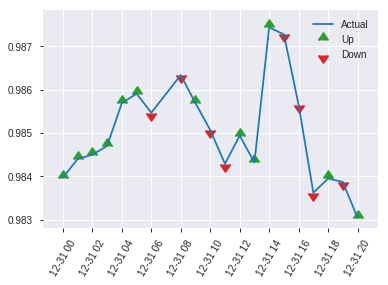


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20665975568017417
RMSE: 0.4545984554309156
LogLoss: 0.6049775513943297
Null degrees of freedom: 616
Residual degrees of freedom: 566
Null deviance: 854.9589870947052
Residual deviance: 746.542298420603
AIC: 848.542298420603
AUC: 0.7426017392772712
pr_auc: 0.6972860398372043
Gini: 0.4852034785545425
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3555483557891306: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      141  188  0.5714   (188.0/329.0)
1      37   251  0.1285   (37.0/288.0)
Total  178  439  0.3647   (225.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.355548     0.690509  276
max f2                       0.214987     0.820106  345
max f0point5                 0.546477     0.684172  174
max accuracy                 0.546477     0.701783  174
max precision                0.854675     0.884615  20
max recall                   0.0301227    1         399
max specificity              0.954336     0.99696   0
max absolute_mcc             0.546477     0.39909   174
max min_per_class_accuracy   0.498739     0.677812  197
max mean_per_class_accuracy  0.546477     0.69808   174

Gains/Lift Table: Avg response rate: 46.68 %, avg score: 49.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.906967           1.53026   1.53026            0.714286         0.917029  0.714286                    0.917029            0.0173611       0.0173611                  53.0258   53.0258
    2        0.0210697                   0.880186           2.14236   1.81277            1                0.894279  0.846154                    0.906529            0.0208333       0.0381944                  114.236   81.2767
    3        0.0307942                   0.867216           1.7853    1.80409            0.833333         0.870501  0.842105                    0.895152            0.0173611       0.0555556                  78.5301   80.4094
    4        0.0405186                   0.855507           2.14236   1.88528            1                0.861575  0.88                        0.887093            0.0208333       0.0763889                  114.236   88.5278
    5        0.0502431                   0.838844           1.42824   1.79682            0.666667         0.848014  0.83871                     0.87953             0.0138889       0.0902778                  42.8241   79.6819
    6        0.100486                    0.788763           1.6586    1.72771            0.774194         0.815266  0.806452                    0.847398            0.0833333       0.173611                   65.8602   72.7711
    7        0.150729                    0.755643           1.6586    1.70467            0.774194         0.773987  0.795699                    0.822927            0.0833333       0.256944                   65.8602   70.4674
    8        0.200972                    0.710698           1.6586    1.69316            0.774194         0.731829  0.790323                    0.800153            0.0833333       0.340278                   65.8602   69.3156
    9        0.299838                    0.632916           1.1941    1.5286             0.557377         0.671644  0.713514                    0.75778             0.118056        0.458333                   19.4103   52.8604
    10       0.400324                    0.566899           1.41672   1.50052            0.66129          0.600553  0.700405                    0.718314            0.142361        0.600694                   41.6723   50.052
    11       0.50081                     0.491623           0.863855  1.37278            0.403226         0.527974  0.640777                    0.680123            0.0868056       0.6875                     -13.6145  37.2775
    12       0.599676                    0.436845           0.878017  1.29121            0.409836         0.464704  0.602703                    0.644608            0.0868056       0.774306                   -12.1983  29.1207
    13       0.700162                    0.365251           0.829301  1.22491            0.387097         0.401123  0.571759                    0.609663            0.0833333       0.857639                   -17.0699  22.4915
    14       0.799028                    0.275198           0.561931  1.14288            0.262295         0.318782  0.533469                    0.573672            0.0555556       0.913194                   -43.8069  14.2882
    15       0.899514                    0.203847           0.552867  1.07697            0.258065         0.240307  0.502703                    0.536431            0.0555556       0.96875                    -44.7133  7.69707
    16       1                           0.0301227          0.310988  1                  0.145161         0.129259  0.466775                    0.495516          

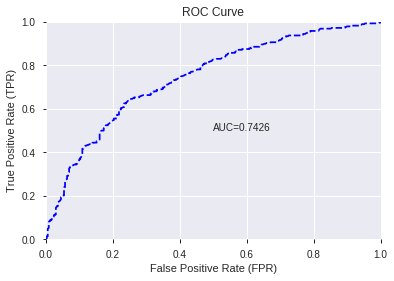

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


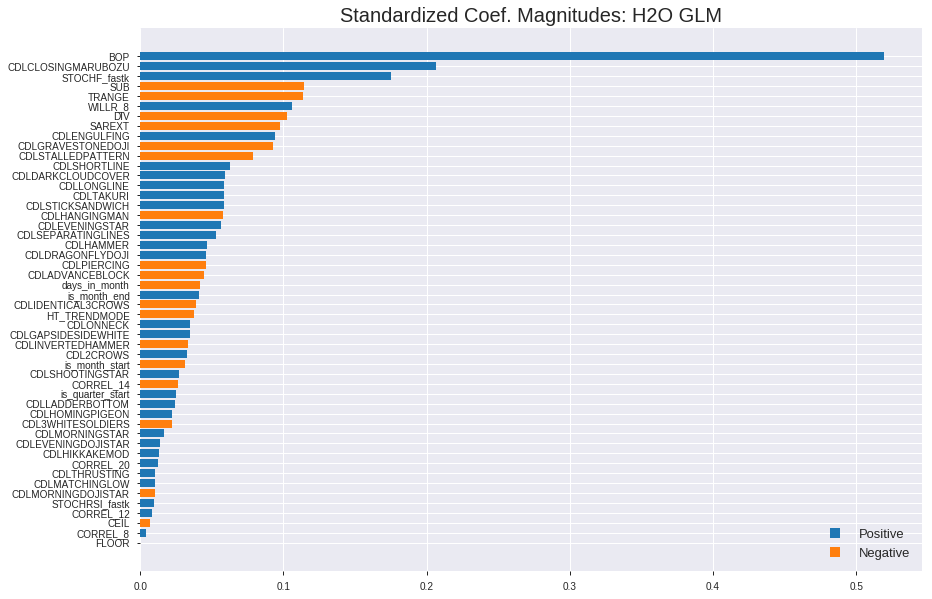

'log_likelihood'
--2019-08-24 14:50:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.138.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.138.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_145027_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_145027_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a4a9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'SUB',
 'TRANGE',
 'WILLR_8',
 'DIV',
 'SAREXT',
 'CDLENGULFING',
 'CDLGRAVESTONEDOJI',
 'CDLSTALLEDPATTERN',
 'CDLSHORTLINE',
 'CDLDARKCLOUDCOVER',
 'CDLLONGLINE',
 'CDLTAKURI',
 'CDLSTICKSANDWICH',
 'CDLHANGINGMAN',
 'CDLEVENINGSTAR',
 'CDLSEPARATINGLINES',
 'CDLHAMMER',
 'CDLDRAGONFLYDOJI',
 'CDLPIERCING',
 'CDLADVANCEBLOCK',
 'days_in_month',
 'is_month_end',
 'CDLIDENTICAL3CROWS',
 'HT_TRENDMODE',
 'CDLONNECK',
 'CDLGAPSIDESIDEWHITE',
 'CDLINVERTEDHAMMER',
 'CDL2CROWS',
 'is_month_start',
 'CDLSHOOTINGSTAR',
 'CORREL_14',
 'is_quarter_start',
 'CDLLADDERBOTTOM',
 'CDLHOMINGPIGEON',
 'CDL3WHITESOLDIERS',
 'CDLMORNINGSTAR',
 'CDLEVENINGDOJISTAR',
 'CDLHIKKAKEMOD',
 'CORREL_20',
 'CDLTHRUSTING',
 'CDLMATCHINGLOW',
 'CDLMORNINGDOJISTAR',
 'STOCHRSI_fastk',
 'CORREL_12',
 'CEIL',
 'CORREL_8',
 'FLOOR']

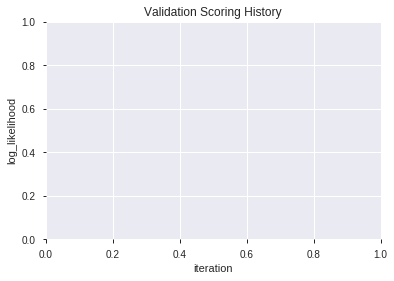

In [23]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_145134_model_3  0.763794  0.581638              0.303698  0.444747  0.197800
1               XGBoost_3_AutoML_20190824_145134  0.761572  0.582965              0.307603  0.446025  0.198939
2               XGBoost_2_AutoML_20190824_145134  0.761393  0.581770              0.302827  0.445644  0.198599
3  XGBoost_grid_1_AutoML_20190824_145134_model_6  0.759430  0.585959              0.315640  0.447172  0.199963
4  XGBoost_grid_1_AutoML_20190824_145134_model_2  0.759303  0.584850              0.312817  0.446906  0.199725
5  XGBoost_grid_1_AutoML_20190824_145134_model_1  0.759298  0.587053              0.311946  0.447106  0.199903
6  XGBoost_grid_1_AutoML_20190824_145134_model_7  0.758939  0.587360              0.291952  0.447353  0.200125
7               XGBoost_1_AutoML_20190824_145134  0.757878  0.587943              0.321719  0.447577  0.200325
8  XGBoost_grid_1_AutoML_20190824_145134_model_4  0.753076  0.588288              0.316943  0.448798  0.201420
9  XGBoost_grid_1_AutoML_20190824_145134_model_5  0.747193  0.605972              0.364288  0.454454  0.206529

variable  relative_importance  scaled_importance  percentage
0                  BOP          3928.775879           1.000000    0.333910
1         STOCHF_fastk          1522.675903           0.387570    0.129414
2               TRANGE          1280.815430           0.326009    0.108858
3       STOCHRSI_fastk           810.854187           0.206389    0.068915
4              WILLR_8           767.287231           0.195299    0.065212
5               SAREXT           705.954407           0.179688    0.060000
6                  DIV           581.304443           0.147961    0.049406
7                  SUB           549.824890           0.139948    0.046730
8   CDLCLOSINGMARUBOZU           376.273834           0.095774    0.031980
9         CDLSHORTLINE           255.469193           0.065025    0.021713
10   CDLGRAVESTONEDOJI           180.437607           0.045927    0.015336
11         CDLLONGLINE           162.007233           0.041236    0.013769
12       days_in_month           139.556992           0.035522    0.011861
13        CDLENGULFING           110.620171           0.028156    0.009402
14        HT_TRENDMODE            71.802727           0.018276    0.006103
15           CORREL_20            62.936348           0.016019    0.005349
16    CDLDRAGONFLYDOJI            61.761406           0.015720    0.005249
17           CDLTAKURI            55.097939           0.014024    0.004683
18           CDLHAMMER            50.918289           0.012960    0.004328
19        is_month_end            31.805267           0.008095    0.002703
20       CDLHANGINGMAN            15.621960           0.003976    0.001328
21           CORREL_14            11.573159           0.002946    0.000984
22      is_month_start             7.556190           0.001923    0.000642
23                CEIL             7.020280           0.001787    0.000597
24     CDLADVANCEBLOCK             4.633682           0.001179    0.000394
25     CDLSHOOTINGSTAR             4.442083           0.001131    0.000378
26      CDLMATCHINGLOW             4.180546           0.001064    0.000355
27           CORREL_12             3.742681           0.000953    0.000318
28               FLOOR             1.017985           0.000259    0.000087

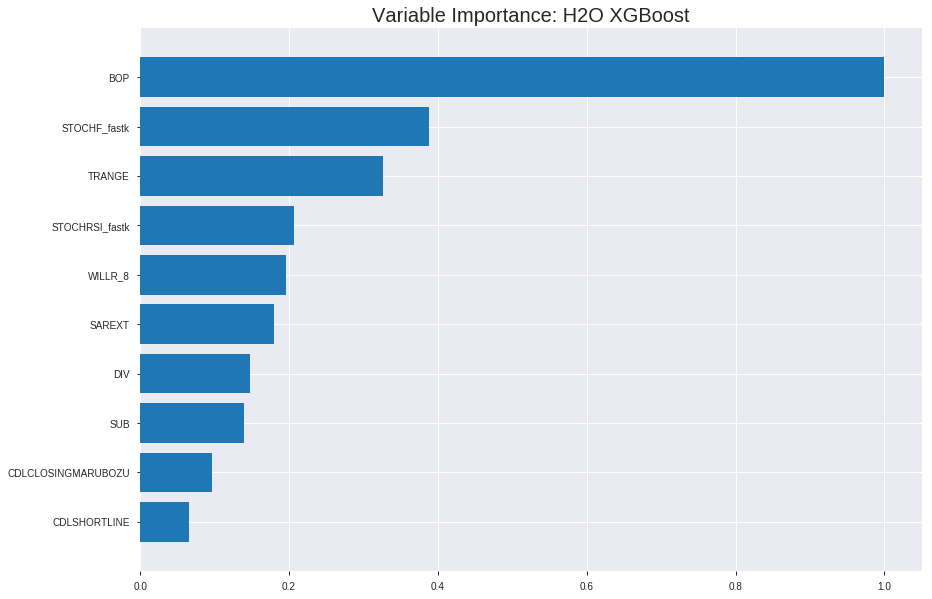

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_145134_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1725562504054147
RMSE: 0.4153989051567357
LogLoss: 0.5182349263884157
Mean Per-Class Error: 0.2541869678662957
AUC: 0.8273460115749631
pr_auc: 0.8293053641042809
Gini: 0.6546920231499262
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3769110788901647: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1247  920   0.4246   (920.0/2167.0)
1      277   1869  0.1291   (277.0/2146.0)
Total  1524  2789  0.2775   (1197.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.376911     0.757447  251
max f2                       0.248148     0.858669  317
max f0point5                 0.563731     0.755346  167
max accuracy                 0.524171     0.745885  187
max precision                0.958781     1         0
max recall                   0.113459     1         374
max specificity              0.958781     1         0
max absolute_mcc             0.524171     0.491868  187
max min_per_class_accuracy   0.512122     0.742311  193
max mean_per_class_accuracy  0.524171     0.745813  187

Gains/Lift Table: Avg response rate: 49.76 %, avg score: 49.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.924099           2.00979   2.00979            1                0.936294  1                           0.936294            0.0205033       0.0205033                  100.979   100.979
    2        0.0201716                   0.912835           2.00979   2.00979            1                0.918364  1                           0.927432            0.0200373       0.0405405                  100.979   100.979
    3        0.0301414                   0.896918           1.96305   1.99433            0.976744         0.904337  0.992308                    0.919793            0.0195713       0.0601118                  96.3046   99.4326
    4        0.0401113                   0.881524           1.91631   1.97493            0.953488         0.888064  0.982659                    0.911907            0.0191053       0.0792171                  91.6307   97.4934
    5        0.0500812                   0.870586           1.96305   1.97257            0.976744         0.87627   0.981481                    0.904812            0.0195713       0.0987884                  96.3046   97.2567
    6        0.100162                    0.811047           1.86091   1.91674            0.925926         0.838387  0.953704                    0.8716              0.0931966       0.191985                   86.0913   91.674
    7        0.150012                    0.760968           1.81348   1.88243            0.902326         0.788384  0.936631                    0.843947            0.0904007       0.282386                   81.3481   88.2427
    8        0.200093                    0.720214           1.64691   1.82348            0.819444         0.739402  0.9073                      0.81778             0.082479        0.364865                   64.6908   82.3479
    9        0.300023                    0.640752           1.44555   1.6976             0.719258         0.6804    0.844668                    0.772022            0.144455        0.50932                    44.5553   69.7601
    10       0.399954                    0.578327           1.22639   1.57987            0.610209         0.610721  0.786087                    0.73172             0.122554        0.631873                   22.6389   57.9866
    11       0.500116                    0.509549           1.1212    1.48801            0.55787          0.545935  0.74038                     0.694512            0.112302        0.744175                   12.12     48.8005
    12       0.600046                    0.425004           0.890647  1.38852            0.443155         0.469385  0.690881                    0.657019            0.0890028       0.833178                   -10.9353  38.8523
    13       0.699977                    0.340027           0.718114  1.29281            0.357309         0.376717  0.643259                    0.617003            0.0717614       0.904939                   -28.1886  29.2813
    14       0.799907                    0.271391           0.522264  1.19655            0.259861         0.306731  0.595362                    0.578241            0.0521901       0.95713                    -47.7736  19.6551
    15       0.899838                    0.187348           0.326415  1.09992            0.162413         0.232359  0.547282                    0.53983             0.0326188       0.989748                   -67.3585  9.99188
    16       1                           0.0392763          0.10235   1                  0.0509259        0.121345  0.497565                    0.497913          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2004591926853319
RMSE: 0.44772669418444544
LogLoss: 0.5862300857562317
Mean Per-Class Error: 0.30158361486486485
AUC: 0.7557485219594594
pr_auc: 0.7486046217842025
Gini: 0.5114970439189188
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.394713431596756: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      318  274  0.4628   (274.0/592.0)
1      112  528  0.175    (112.0/640.0)
Total  430  802  0.3133   (386.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394713     0.732316  253
max f2                       0.208799     0.854258  343
max f0point5                 0.621958     0.720541  146
max accuracy                 0.515214     0.696429  199
max precision                0.944407     1         0
max recall                   0.0586341    1         394
max specificity              0.944407     1         0
max absolute_mcc             0.589211     0.399833  164
max min_per_class_accuracy   0.538598     0.695312  188
max mean_per_class_accuracy  0.589211     0.698416  164

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 51.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.919124           1.62885   1.62885            0.846154         0.929104  0.846154                    0.929104            0.0171875       0.0171875                  62.8846   62.8846
    2        0.0202922                   0.905287           1.925     1.771              1                0.911378  0.92                        0.920596            0.01875         0.0359375                  92.5      77.1
    3        0.0300325                   0.893412           1.76458   1.76892            0.916667         0.899823  0.918919                    0.913859            0.0171875       0.053125                   76.4583   76.8919
    4        0.0405844                   0.875228           1.77692   1.771              0.923077         0.885387  0.92                        0.906456            0.01875         0.071875                   77.6923   77.1
    5        0.0503247                   0.863427           1.925     1.80081            1                0.869054  0.935484                    0.899217            0.01875         0.090625                   92.5      80.0806
    6        0.100649                    0.818516           1.33508   1.56794            0.693548         0.839851  0.814516                    0.869534            0.0671875       0.157812                   33.5081   56.7944
    7        0.150162                    0.776686           1.51475   1.55041            0.786885         0.799109  0.805405                    0.846313            0.075           0.232813                   51.4754   55.0405
    8        0.200487                    0.733608           1.42823   1.51974            0.741935         0.756205  0.789474                    0.823694            0.071875        0.304688                   42.8226   51.9737
    9        0.300325                    0.67195            1.45549   1.49838            0.756098         0.702054  0.778378                    0.783257            0.145313        0.45                       45.5488   49.8378
    10       0.400162                    0.608257           1.29898   1.44863            0.674797         0.639035  0.752535                    0.747275            0.129688        0.579688                   29.8984   44.8631
    11       0.5                         0.543257           1.06423   1.37188            0.552846         0.577534  0.712662                    0.713382            0.10625         0.685937                   6.42276   37.1875
    12       0.599838                    0.456808           0.939024  1.29983            0.487805         0.501329  0.675237                    0.678087            0.09375         0.779687                   -6.09756  29.9831
    13       0.699675                    0.348116           0.719919  1.21708            0.373984         0.399484  0.632251                    0.638333            0.071875        0.851562                   -28.0081  21.7082
    14       0.799513                    0.282364           0.672967  1.14914            0.349593         0.313852  0.596954                    0.597814            0.0671875       0.91875                    -32.7033  14.9137
    15       0.899351                    0.20462            0.594715  1.08759            0.308943         0.246256  0.564982                    0.558787            0.059375        0.978125                   -40.5285  8.75903
    16       1                           0.0464873          0.217339  1                  0.112903         0.129195  0.519481                    0.515549            0.0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 14:51:44  2.630 sec   0                  0.5              0.693147            0.5             0                  1                0.502435                         0.5                0.693147              0.5               0                    1                  0.480519
    2019-08-24 14:51:44  2.711 sec   5                  0.477412         0.648676            0.791129        0.789811           2.00979          0.295618                         0.481304           0.656197              0.742672          0.739737             1.77692            0.315747
    2019-08-24 14:51:44  2.776 sec   10                 0.462227         0.618937            0.795372        0.79679            1.96411          0.29214                          0.469501           0.632845              0.747679          0.744042             1.77692            0.311688
    2019-08-24 14:51:44  2.849 sec   15                 0.450834         0.596351            0.801914        0.802226           2.00979          0.286575                         0.461861           0.617438              0.75033           0.743186             1.62885            0.330357
    2019-08-24 14:51:44  2.936 sec   20                 0.442255         0.578803            0.80549         0.805141           2.00979          0.284721                         0.45634            0.605866              0.751669          0.744303             1.62885            0.32224
    2019-08-24 14:51:44  3.039 sec   25                 0.436619         0.566731            0.808068        0.808588           2.00979          0.283561                         0.453477           0.599521              0.75161           0.743021             1.62885            0.32224
    2019-08-24 14:51:44  3.131 sec   30                 0.432249         0.557087            0.810559        0.812043           2.00979          0.283329                         0.45165            0.595295              0.752043          0.744909             1.62885            0.313312
    2019-08-24 14:51:44  3.235 sec   35                 0.429118         0.549871            0.812121        0.813463           2.00979          0.290517                         0.45016            0.591727              0.752616          0.745978             1.77692            0.318182
    2019-08-24 14:51:44  3.346 sec   40                 0.426117         0.542925            0.814765        0.815799           2.00979          0.28959                          0.450002           0.591028              0.751427          0.745604             1.77692            0.314935
    2019-08-24 14:51:44  3.459 sec   45                 0.423505         0.53696             0.817299        0.818631           2.00979          0.286344                         0.449263           0.589324              0.752085          0.747136             1.62885            0.314123
    2019-08-24 14:51:45  3.592 sec   50                 0.421056         0.531368            0.819896        0.820139           2.00979          0.282634                         0.448337           0.587376              0.753557          0.748969             1.77692            0.318994
    2019-08-24 14:51:45  3.706 sec   55                 0.419644         0.52791             0.821326        0.821891           2.00979          0.27962                          0.448025           0.586673              0.754351          0.7

Variable Importances: 


variable         relative_importance    scaled_importance      percentage
---------------  ---------------------  ---------------------  ----------------------
BOP              3928.77587890625       1.0                    0.3339101295218973
STOCHF_fastk     1522.6759033203125     0.38757006005245004    0.1294135689509231
TRANGE           1280.8154296875        0.3260087796212168     0.10885763382859617
STOCHRSI_fastk   810.8541870117188      0.20638850675224982    0.0689152130214747
WILLR_8          767.2872314453125      0.19529931334716938    0.06521241901529093
---              ---                    ---                    ---
CDLADVANCEBLOCK  4.6336822509765625     0.0011794213754607338  0.00039382074424098787
CDLSHOOTINGSTAR  4.44208288192749       0.0011306531649660154  0.00037753654475814526
CDLMATCHINGLOW   4.180545806884766      0.0010640835557279504  0.0003553082779152409
CORREL_12        3.7426810264587402     0.0009526328662709776  0.00031809376376335836
FLOOR            1.0179853439331055     0.0002591100575114779  8.651947286408383e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7034035656401945)

('F1', 0.7132243684992572)

('auc', 0.7637939040864573)

('logloss', 0.581638049163932)

('mean_per_class_error', 0.3034553360351233)

('rmse', 0.44474681140889016)

('mse', 0.1977997262583749)

xgboost prediction progress: |████████████████████████████████████████████| 100%


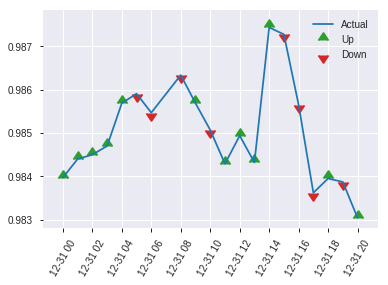


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1977997262583749
RMSE: 0.44474681140889016
LogLoss: 0.581638049163932
Mean Per-Class Error: 0.3034553360351233
AUC: 0.7637939040864573
pr_auc: 0.7269311587232183
Gini: 0.5275878081729146
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38464727997779846: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      184  145  0.4407   (145.0/329.0)
1      48   240  0.1667   (48.0/288.0)
Total  232  385  0.3128   (193.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.384647     0.713224  246
max f2                       0.240166     0.823778  323
max f0point5                 0.60321      0.694444  144
max accuracy                 0.60321      0.703404  144
max precision                0.95262      1         0
max recall                   0.0402165    1         399
max specificity              0.95262      1         0
max absolute_mcc             0.60321      0.404792  144
max min_per_class_accuracy   0.517772     0.693009  191
max mean_per_class_accuracy  0.491779     0.696545  200

Gains/Lift Table: Avg response rate: 46.68 %, avg score: 48.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.93306            1.83631   1.83631            0.857143         0.940048  0.857143                    0.940048            0.0208333       0.0208333                  83.631    83.631
    2        0.0210697                   0.916372           2.14236   1.97756            1                0.924189  0.923077                    0.932728            0.0208333       0.0416667                  114.236   97.7564
    3        0.0307942                   0.90752            1.7853    1.91685            0.833333         0.910929  0.894737                    0.925844            0.0173611       0.0590278                  78.5301   91.6849
    4        0.0405186                   0.889947           1.7853    1.88528            0.833333         0.900512  0.88                        0.919764            0.0173611       0.0763889                  78.5301   88.5278
    5        0.0502431                   0.872564           1.7853    1.86593            0.833333         0.881778  0.870968                    0.912412            0.0173611       0.09375                    78.5301   86.5927
    6        0.100486                    0.808256           1.72771   1.79682            0.806452         0.844999  0.83871                     0.878706            0.0868056       0.180556                   72.7711   79.6819
    7        0.150729                    0.75687            1.86593   1.81986            0.870968         0.779241  0.849462                    0.845551            0.09375         0.274306                   86.5927   81.9855
    8        0.200972                    0.704443           1.38217   1.71043            0.645161         0.733194  0.798387                    0.817462            0.0694444       0.34375                    38.2168   71.0433
    9        0.299838                    0.638377           1.33459   1.58651            0.622951         0.67055   0.740541                    0.769021            0.131944        0.475694                   33.4586   58.6505
    10       0.400324                    0.579493           1.2094    1.49185            0.564516         0.609361  0.696356                    0.728944            0.121528        0.597222                   20.9397   49.1847
    11       0.50081                     0.501398           1.10573   1.41437            0.516129         0.543597  0.660194                    0.691755            0.111111        0.708333                   10.5735   41.4374
    12       0.599676                    0.399932           0.983379  1.34332            0.459016         0.448498  0.627027                    0.65165             0.0972222       0.805556                   -1.66211  34.3318
    13       0.700162                    0.32351            0.587422  1.23483            0.274194         0.360057  0.576389                    0.609801            0.0590278       0.864583                   -41.2578  23.4833
    14       0.799028                    0.253108           0.667293  1.16461            0.311475         0.290832  0.543611                    0.570334            0.0659722       0.930556                   -33.2707  16.461
    15       0.899514                    0.178151           0.345542  1.07311            0.16129          0.216163  0.500901                    0.530769            0.0347222       0.965278                   -65.4458  7.31106
    16       1                           0.0402165          0.345542  1                  0.16129          0.114112  0.466775                    0.488901           

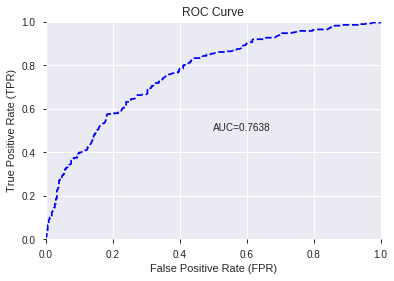

This function is available for GLM models only


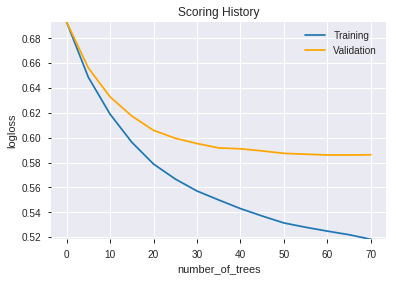

--2019-08-24 14:52:06--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.92.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.92.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_145134_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_145134_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a4a9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'STOCHRSI_fastk',
 'WILLR_8',
 'SAREXT',
 'DIV',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'CDLSHORTLINE',
 'CDLGRAVESTONEDOJI',
 'CDLLONGLINE',
 'days_in_month',
 'CDLENGULFING',
 'HT_TRENDMODE',
 'CORREL_20',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLHAMMER',
 'is_month_end',
 'CDLHANGINGMAN',
 'CORREL_14',
 'is_month_start',
 'CEIL',
 'CDLADVANCEBLOCK',
 'CDLSHOOTINGSTAR',
 'CDLMATCHINGLOW',
 'CORREL_12',
 'FLOOR']

In [24]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [26]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [27]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [28]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [30]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [31]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [32]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [34]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [35]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [36]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [38]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [39]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [40]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [42]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [43]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [44]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [46]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [47]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [48]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [49]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 893 937 939] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


120

['Volume',
 'hour',
 'BOP',
 'CCI_8',
 'CMO_8',
 'MACDFIX_hist_8',
 'MFI_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'MOM_8',
 'PLUS_DI_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'MFI_12',
 'MINUS_DI_12',
 'MINUS_DM_12',
 'MOM_12',
 'PLUS_DI_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'MFI_14',
 'MINUS_DI_14',
 'MINUS_DM_14',
 'MOM_14',
 'PLUS_DI_14',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'aroondown_20',
 'CCI_20',
 'CMO_20',
 'MFI_20',
 'MINUS_DI_20',
 'MINUS_DM_20',
 'MOM_20',
 'PLUS_DI_20',
 'ROC_20',
 'ROCP_20',
 'ROCR_20',
 'ROCR100_20',
 'RSI_20',
 'WILLR_20',
 'aroondown_24',
 'CCI_24',
 'CMO_24',
 'MFI_24',
 'MINUS_DI_24',
 'MINUS_DM_24',
 'MOM_24',
 'ROC_24',
 'ROCP_24',
 'ROCR_24',
 'ROCR100_24',
 'RSI_24',
 'WILLR_24',
 'CCI_30',
 'CMO_30',
 'MFI_30',
 'MINUS_DI_30',
 'MINUS_DM_30',
 'MOM_30',
 'ROC_30',
 'ROCP_30',
 'ROCR_30',
 'ROCR100_3

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_145305_model_9  0.750185  0.600040              0.325629  0.453614  0.205765
1  DeepLearning_grid_1_AutoML_20190824_145305_model_6  0.746728  0.601820              0.318463  0.454581  0.206644
2  DeepLearning_grid_1_AutoML_20190824_145305_model_3  0.737837  0.637698              0.319101  0.460195  0.211779
3  DeepLearning_grid_1_AutoML_20190824_145305_model_5  0.737430  0.620979              0.340383  0.463199  0.214554
4               DeepLearning_1_AutoML_20190824_145305  0.730317  0.634629              0.341903  0.465981  0.217139
5  DeepLearning_grid_1_AutoML_20190824_145305_model_4  0.724497  0.669154              0.383396  0.474222  0.224887
6  DeepLearning_grid_1_AutoML_20190824_145305_model_8  0.722961  0.623105              0.348209  0.462078  0.213516
7  DeepLearning_grid_1_AutoML_20190824_145305_model_7  0.702935  0.736297              0.395554  0.484865  0.235094
8  DeepLearning_grid_1_AutoML_20190824_145305_model_2  0.700386  0.719176              0.383612  0.493934  0.243971
9  DeepLearning_grid_1_AutoML_20190824_145305_model_1  0.699674  1.039120              0.354927  0.528490  0.279302

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.028102
1    CDLCLOSINGMARUBOZU             0.902384           0.902384    0.025359
2           CDLLONGLINE             0.691666           0.691666    0.019437
3          CDLSHORTLINE             0.626684           0.626684    0.017611
4          CDLENGULFING             0.592052           0.592052    0.016638
..                  ...                  ...                ...         ...
115              ROC_30             0.225599           0.225599    0.006340
116             ROCR_12             0.225367           0.225367    0.006333
117              MOM_14             0.222146           0.222146    0.006243
118              CMO_14             0.221885           0.221885    0.006235
119              ROC_24             0.213589           0.213589    0.006002

[120 rows x 4 columns]

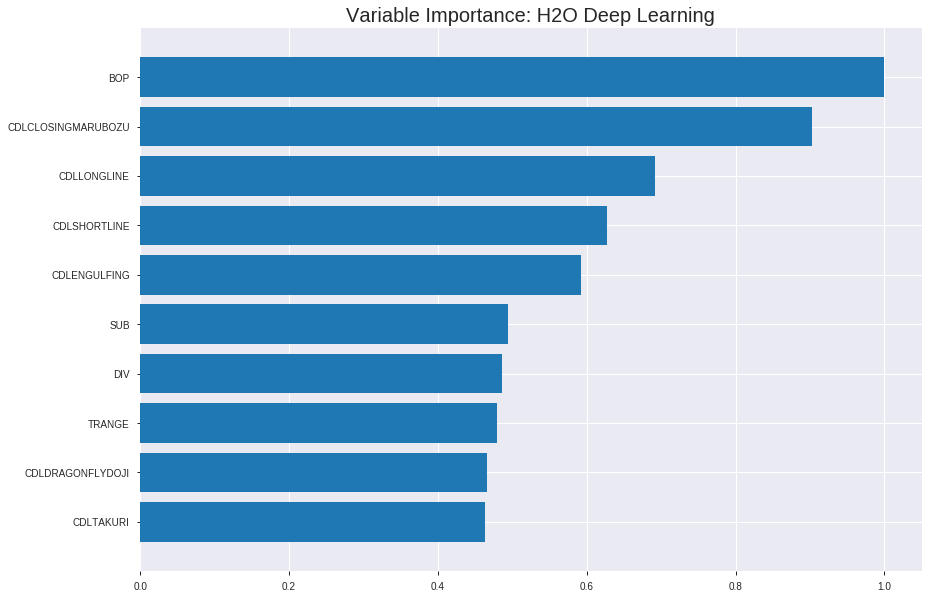

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_145305_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19237716356880596
RMSE: 0.4386082119258667
LogLoss: 0.566778988878589
Mean Per-Class Error: 0.2931873123541249
AUC: 0.7796450915215137
pr_auc: 0.7674161849338234
Gini: 0.5592901830430275
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4124061346086698: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1075  1092  0.5039   (1092.0/2167.0)
1      279   1867  0.13     (279.0/2146.0)
Total  1354  2959  0.3179   (1371.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.412406     0.73144   251
max f2                       0.218264     0.844559  336
max f0point5                 0.570118     0.715871  165
max accuracy                 0.515938     0.706933  191
max precision                0.956789     1         0
max recall                   0.0993454    1         386
max specificity              0.956789     1         0
max absolute_mcc             0.515938     0.414262  191
max min_per_class_accuracy   0.503434     0.702353  199
max mean_per_class_accuracy  0.514724     0.706813  192

Gains/Lift Table: Avg response rate: 49.76 %, avg score: 51.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.907471           1.91843   1.91843            0.954545         0.922139  0.954545                    0.922139            0.0195713       0.0195713                  91.8432   91.8432
    2        0.0201716                   0.891663           1.82283   1.87118            0.906977         0.897347  0.931034                    0.909886            0.0181733       0.0377446                  82.2829   87.118
    3        0.0301414                   0.879524           1.68261   1.80881            0.837209         0.885447  0.9                         0.901802            0.0167754       0.05452                    68.2611   80.8807
    4        0.0401113                   0.864896           1.77609   1.80068            0.883721         0.872798  0.895954                    0.894593            0.0177074       0.0722274                  77.609    80.0675
    5        0.0500812                   0.850874           1.77609   1.79578            0.883721         0.858409  0.893519                    0.88739             0.0177074       0.0899348                  77.609    79.5781
    6        0.100162                    0.797648           1.72134   1.75856            0.856481         0.822811  0.875                       0.8551              0.0862069       0.176142                   72.1344   75.8562
    7        0.150012                    0.751852           1.64522   1.7209             0.818605         0.773994  0.85626                     0.828149            0.082013        0.258155                   64.522    72.0898
    8        0.200093                    0.714381           1.58178   1.68608            0.787037         0.733361  0.838934                    0.804424            0.0792171       0.337372                   58.1776   68.6077
    9        0.300023                    0.650612           1.43156   1.60131            0.712297         0.683431  0.796754                    0.764124            0.143057        0.480429                   43.1564   60.1305
    10       0.399954                    0.567901           1.23105   1.5088             0.612529         0.608969  0.750725                    0.725358            0.12302         0.603448                   23.1052   50.8796
    11       0.500116                    0.502165           1.00955   1.40881            0.502315         0.531389  0.700974                    0.68651             0.101118        0.704567                   0.954511  40.8807
    12       0.600046                    0.467125           0.895311  1.32329            0.445476         0.486093  0.658423                    0.653133            0.0894688       0.794035                   -10.4689  32.329
    13       0.699977                    0.400736           0.84868   1.25553            0.422274         0.436615  0.62471                     0.622222            0.0848089       0.878844                   -15.132   25.5534
    14       0.799907                    0.309063           0.601537  1.17383            0.299304         0.357416  0.584058                    0.589141            0.0601118       0.938956                   -39.8463  17.3831
    15       0.899838                    0.201287           0.410351  1.08904            0.204176         0.253001  0.541871                    0.551811            0.0410065       0.979963                   -58.9649  8.90439
    16       1                           0.0312535          0.200048  1                  0.099537         0.150329  0.497565                    0.511598           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.201896462027164
RMSE: 0.44932890183824586
LogLoss: 0.5906904886454375
Mean Per-Class Error: 0.30475084459459456
AUC: 0.7528518264358108
pr_auc: 0.7381363736162471
Gini: 0.5057036528716217
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37783798945835884: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      235  357  0.603    (357.0/592.0)
1      67   573  0.1047   (67.0/640.0)
Total  302  930  0.3442   (424.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.377838     0.729936  278
max f2                       0.18312      0.851722  364
max f0point5                 0.575287     0.71198   173
max accuracy                 0.51673      0.695617  202
max precision                0.963217     1         0
max recall                   0.0883179    1         395
max specificity              0.963217     1         0
max absolute_mcc             0.51673      0.390429  202
max min_per_class_accuracy   0.524213     0.69375   199
max mean_per_class_accuracy  0.51673      0.695249  202

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 53.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.905206           1.18462   1.18462            0.615385         0.924384  0.615385                    0.924384            0.0125          0.0125                     18.4615   18.4615
    2        0.0202922                   0.889623           1.44375   1.309              0.75             0.896049  0.68                        0.910783            0.0140625       0.0265625                  44.375    30.9
    3        0.0300325                   0.87751            1.76458   1.45676            0.916667         0.884996  0.756757                    0.902419            0.0171875       0.04375                    76.4583   45.6757
    4        0.0405844                   0.861467           1.48077   1.463              0.769231         0.868957  0.76                        0.893719            0.015625        0.059375                   48.0769   46.3
    5        0.0503247                   0.853137           1.925     1.55242            1                0.857394  0.806452                    0.886689            0.01875         0.078125                   92.5      55.2419
    6        0.100649                    0.812786           1.70766   1.63004            0.887097         0.831697  0.846774                    0.859193            0.0859375       0.164062                   70.7661   63.004
    7        0.150162                    0.774298           1.7041    1.65446            0.885246         0.791526  0.859459                    0.836881            0.084375        0.248438                   70.4098   65.4459
    8        0.200487                    0.736627           1.36613   1.58209            0.709677         0.755838  0.821862                    0.816538            0.06875         0.317188                   36.6129   58.2085
    9        0.300325                    0.674767           1.31463   1.49318            0.682927         0.705089  0.775676                    0.779489            0.13125         0.448437                   31.4634   49.3176
    10       0.400162                    0.609001           1.29898   1.44473            0.674797         0.643579  0.750507                    0.74558             0.129688        0.578125                   29.8984   44.4726
    11       0.5                         0.527444           1.06423   1.36875            0.552846         0.566328  0.711039                    0.709788            0.10625         0.684375                   6.42276   36.875
    12       0.599838                    0.48279            0.829472  1.27899            0.430894         0.501474  0.664411                    0.675116            0.0828125       0.767188                   -17.0528  27.8992
    13       0.699675                    0.429431           0.829472  1.21485            0.430894         0.457975  0.63109                     0.644132            0.0828125       0.85                       -17.0528  21.4849
    14       0.799513                    0.331932           0.672967  1.14718            0.349593         0.380115  0.595939                    0.611163            0.0671875       0.917188                   -32.7033  14.7183
    15       0.899351                    0.212658           0.563415  1.08238            0.292683         0.269324  0.562274                    0.573215            0.05625         0.973437                   -43.6585  8.23782
    16       1                           0.0623501          0.263911  1                  0.137097         0.159547  0.519481                    0.53158             0.026


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 15:11:13  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 15:11:18  8 min 29.298 sec   271 obs/sec       0.258984  1             1117       0.478117         0.682297            0.0855944      0.751623        0.733341           1.69005          0.335497                         0.49498            0.735035              0.0184888        0.724776          0.70281              1.48077            0.353896
    2019-08-24 15:12:15  9 min 26.330 sec   526 obs/sec       6.77487   26            29220      0.442372         0.57504             0.217209       0.772013        0.761835           1.96411          0.331556                         0.450068           0.592321              0.188523         0.751424          0.740119             1.33269            0.351461
    2019-08-24 15:13:12  10 min 23.609 sec  617 obs/sec       15.3457   59            66186      0.438608         0.566779            0.230473       0.779645        0.767416           1.91843          0.317876                         0.449329           0.59069               0.191186         0.752852          0.738136             1.18462            0.344156
    2019-08-24 15:14:09  11 min 21.284 sec  680 obs/sec       25.0754   96            108150     0.437098         0.564545            0.235764       0.781585        0.768159           1.91843          0.309297                         0.451598           0.598492              0.182998         0.751169          0.735485             1.18462            0.357143
    2019-08-24 15:15:08  12 min 19.095 sec  720 obs/sec       35.2801   135           152163     0.436828         0.56344             0.236706       0.788311        0.774794           1.87275          0.299096                         0.449538           0.591588              0.190434         0.757017          0.742074             1.33269            0.357143
    2019-08-24 15:16:03  13 min 14.816 sec  750 obs/sec       45.5319   174           196379     0.432474         0.55488             0.251848       0.793158        0.781063           1.82708          0.291444                         0.449662           0.593408              0.189987         0.753339          0.741582             1.03654            0.368506
    2019-08-24 15:16:58  14 min 10.051 sec  774 obs/sec       55.8333   213           240809     0.430319         0.549893            0.259286       0.796328        0.783893           1.87275          0.300719                         0.451134           0.597096              0.184674         0.749476          0.736898             1.33269            0.357143
    2019-08-24 15:17:04  14 min 15.845 sec  773 obs/sec       55.8333   213           240809     0.438608         0.566779            0.230473       0.779645        0.767416           1.91843          0.317876                         0.449329           0.59069               0.191186         0.752852          0.738136             1.18462            0.344156

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.028102331538033935
CDLCLOSINGMARUBOZU  0.9023835062980652     0.9023835062980652   0.02535908046844176
CDLLONGLINE         0.6916659474372864     0.6916659474372864   0.019437425768450974
CDLSHORTLINE        0.6266837120056152     0.6266837120056152   0.017611273444267578
CDLENGULFING        0.5920524001121521     0.5920524001121521   0.016638052835840418
---                 ---                    ---                  ---
ROC_30              0.22559918463230133    0.22559918463230133  0.006339863081247062
ROCR_12             0.2253672331571579     0.2253672331571579   0.006333344703991846
MOM_14              0.2221459597349167     0.2221459597349167   0.006242819410305366
CMO_14              0.2218848615884781     0.2218848615884781   0.006235481943630182
ROC_24              0.2135889232158661     0.2135889232158661   0.006002346733063942


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6969205834683955)

('F1', 0.7011494252873564)

('auc', 0.7501846926713948)

('logloss', 0.6000398960518286)

('mean_per_class_error', 0.3008590847686592)

('rmse', 0.4536135007824867)

('mse', 0.20576520809214305)

deeplearning prediction progress: |███████████████████████████████████████| 100%


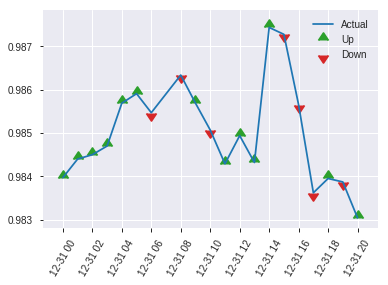


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20576520809214305
RMSE: 0.4536135007824867
LogLoss: 0.6000398960518286
Mean Per-Class Error: 0.3008590847686592
AUC: 0.7501846926713948
pr_auc: 0.7068908282315198
Gini: 0.5003693853427895
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42060056029622855: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      165  164  0.4985   (164.0/329.0)
1      44   244  0.1528   (44.0/288.0)
Total  209  408  0.3371   (208.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.420601     0.701149  257
max f2                       0.280578     0.8213    320
max f0point5                 0.522718     0.67577   187
max accuracy                 0.522718     0.696921  187
max precision                0.931958     1         0
max recall                   0.057235     1         398
max specificity              0.931958     1         0
max absolute_mcc             0.487239     0.39899   212
max min_per_class_accuracy   0.507581     0.68997   197
max mean_per_class_accuracy  0.487239     0.699141  212

Gains/Lift Table: Avg response rate: 46.68 %, avg score: 51.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.90499            1.53026   1.53026            0.714286         0.91656   0.714286                    0.91656             0.0173611       0.0173611                  53.0258   53.0258
    2        0.0210697                   0.894826           2.14236   1.81277            1                0.899726  0.846154                    0.908791            0.0208333       0.0381944                  114.236   81.2767
    3        0.0307942                   0.882283           2.14236   1.91685            1                0.889556  0.894737                    0.902716            0.0208333       0.0590278                  114.236   91.6849
    4        0.0405186                   0.864334           2.14236   1.97097            1                0.872514  0.92                        0.895468            0.0208333       0.0798611                  114.236   97.0972
    5        0.0502431                   0.851172           1.7853    1.93504            0.833333         0.859482  0.903226                    0.888503            0.0173611       0.0972222                  78.5301   93.5036
    6        0.100486                    0.811556           1.72771   1.83137            0.806452         0.832952  0.854839                    0.860727            0.0868056       0.184028                   72.7711   83.1373
    7        0.150729                    0.76809            1.52039   1.72771            0.709677         0.789598  0.806452                    0.837018            0.0763889       0.260417                   52.0385   72.7711
    8        0.200972                    0.734867           1.31306   1.62405            0.612903         0.74732   0.758065                    0.814593            0.0659722       0.326389                   31.306    62.4048
    9        0.299838                    0.659914           1.40483   1.55176            0.655738         0.697271  0.724324                    0.775909            0.138889        0.465278                   40.4827   55.1764
    10       0.400324                    0.571608           1.17484   1.45715            0.548387         0.618401  0.680162                    0.736372            0.118056        0.583333                   17.4843   45.7152
    11       0.50081                     0.501953           1.24395   1.41437            0.580645         0.532025  0.660194                    0.695371            0.125           0.708333                   24.3952   41.4374
    12       0.599676                    0.462676           0.842896  1.32016            0.393443         0.483457  0.616216                    0.660434            0.0833333       0.791667                   -15.7104  32.0158
    13       0.700162                    0.396133           0.760193  1.23979            0.354839         0.429141  0.578704                    0.627239            0.0763889       0.868056                   -23.9807  23.9792
    14       0.799028                    0.305274           0.561931  1.15592            0.262295         0.354401  0.539554                    0.59348             0.0555556       0.923611                   -43.8069  15.5919
    15       0.899514                    0.226756           0.414651  1.07311            0.193548         0.261618  0.500901                    0.556407            0.0416667       0.965278                   -58.5349  7.31106
    16       1                           0.0462568          0.345542  1                  0.16129          0.160308  0.466775                    0.516605         

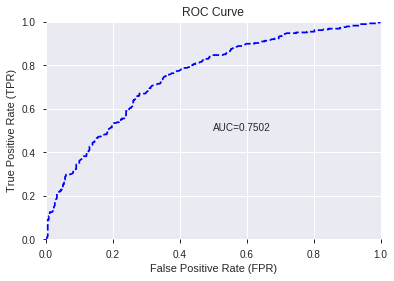

This function is available for GLM models only


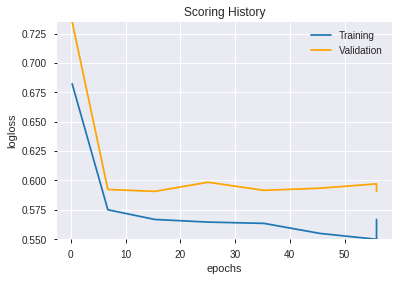

--2019-08-24 15:17:21--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.205.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.205.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_145305_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_145305_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a4a9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CDLENGULFING',
 'SUB',
 'DIV',
 'TRANGE',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLHANGINGMAN',
 'STOCHF_fastk',
 'hour',
 'Volume',
 'CDLADVANCEBLOCK',
 'STOCHRSI_fastk',
 'CDLMARUBOZU',
 'WILLR_8',
 'CDLSEPARATINGLINES',
 'aroondown_24',
 'CCI_8',
 'CDLBELTHOLD',
 'CCI_20',
 'WILLR_14',
 'ADOSC',
 'STOCHF_fastd',
 'ATR_12',
 'MFI_8',
 'CCI_12',
 'aroondown_20',
 'NATR_8',
 'ULTOSC',
 'CCI_24',
 'ATR_8',
 'WILLR_12',
 'STDDEV_12',
 'MFI_20',
 'MFI_30',
 'MACD_hist',
 'STDDEV_14',
 'PLUS_DI_12',
 'ATR_30',
 'MFI_24',
 'STOCH_slowk',
 'CMO_8',
 'MACDFIX_hist_8',
 'CCI_30',
 'ATR_14',
 'RSI_8',
 'ROCR100_8',
 'MINUS_DI_24',
 'MFI_12',
 'NATR_24',
 'NATR_20',
 'MOM_8',
 'ROC_8',
 'MINUS_DI_30',
 'CCI_14',
 'LINEARREG_ANGLE_8',
 'ROCR100_20',
 'ROCR100_12',
 'PLUS_DI_14',
 'ATR_20',
 'CDL3OUTSIDE',
 'LINEARREG_SLOPE_8',
 'STOCHRSI_fastd',
 'MINUS_DI_20',
 'MFI_14',
 'CMO_30',
 'ROCR_8',
 'MINUS_DI_8',
 'ATR_24',
 'MINUS_DM_30

In [50]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_151817_model_1  0.749525  0.598119              0.348869  0.452528  0.204781

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.689450           1.000000    0.068883
1          STOCHF_fastk             0.469457           0.680915    0.046903
2               WILLR_8             0.296443           0.429970    0.029617
3    CDLCLOSINGMARUBOZU             0.252744           0.366588    0.025252
4                 MFI_8             0.247073           0.358362    0.024685
..                  ...                  ...                ...         ...
115          ROCR100_30             0.007669           0.011123    0.000766
116             ROCP_30             0.007333           0.010635    0.000733
117             ROCR_30             0.007235           0.010494    0.000723
118              CMO_30             0.003786           0.005492    0.000378
119          PLUS_DI_14             0.001477           0.002142    0.000148

[120 rows x 4 columns]

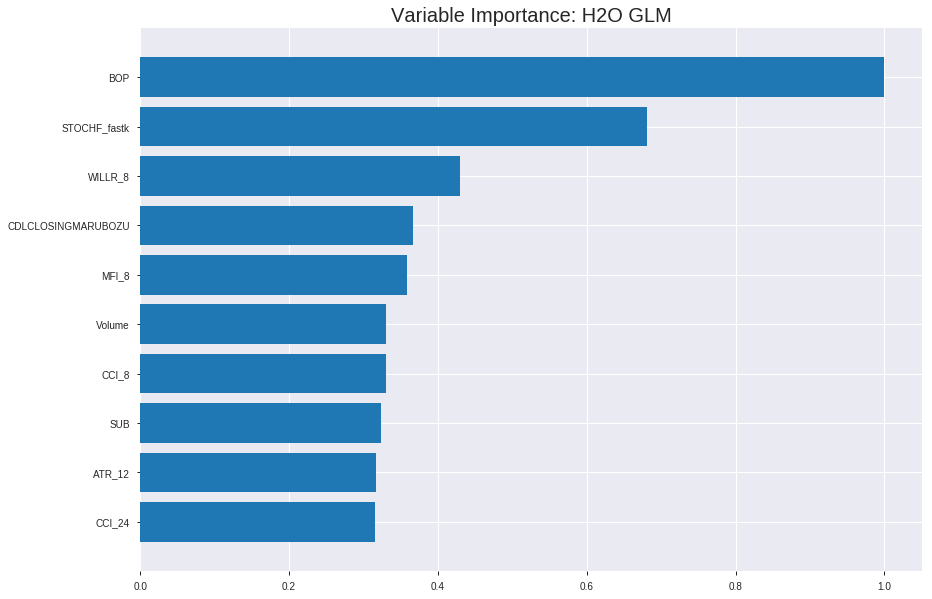

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_151817_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1880145051906507
RMSE: 0.4336063943147641
LogLoss: 0.5546600149040127
Null degrees of freedom: 4312
Residual degrees of freedom: 4192
Null deviance: 5978.985330091486
Residual deviance: 4784.497288562014
AIC: 5026.497288562014
AUC: 0.7874370320545709
pr_auc: 0.7824276254217466
Gini: 0.5748740641091419
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31497055115935374: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      954   1213  0.5598   (1213.0/2167.0)
1      196   1950  0.0913   (196.0/2146.0)
Total  1150  3163  0.3267   (1409.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.314971     0.734602  280
max f2                       0.191278     0.845773  333
max f0point5                 0.589125     0.720726  158
max accuracy                 0.519706     0.713425  189
max precision                0.969702     1         0
max recall                   0.0215905    1         396
max specificity              0.969702     1         0
max absolute_mcc             0.519706     0.426848  189
max min_per_class_accuracy   0.51271      0.710158  192
max mean_per_class_accuracy  0.519706     0.713377  189

Gains/Lift Table: Avg response rate: 49.76 %, avg score: 49.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.927549           2.00979   2.00979            1                0.94354    1                           0.94354             0.0205033       0.0205033                  100.979   100.979
    2        0.0201716                   0.905647           1.96305   1.98668            0.976744         0.917754   0.988506                    0.930796            0.0195713       0.0400746                  96.3046   98.6685
    3        0.0301414                   0.888602           1.86957   1.94795            0.930233         0.89662    0.969231                    0.919491            0.0186393       0.0587139                  86.9568   94.7946
    4        0.0401113                   0.875697           1.86957   1.92846            0.930233         0.882045   0.959538                    0.910184            0.0186393       0.0773532                  86.9568   92.8465
    5        0.0500812                   0.86539            1.82283   1.90744            0.906977         0.87053    0.949074                    0.90229             0.0181733       0.0955266                  82.2829   90.7435
    6        0.100162                    0.815288           1.66552   1.78648            0.828704         0.838256   0.888889                    0.870273            0.083411        0.178938                   66.5517   78.6476
    7        0.150012                    0.774048           1.64522   1.73954            0.818605         0.792504   0.865533                    0.84443             0.082013        0.260951                   64.522    73.9536
    8        0.200093                    0.73586            1.58178   1.70005            0.787037         0.754809   0.845886                    0.821999            0.0792171       0.340168                   58.1776   70.005
    9        0.300023                    0.66604            1.43623   1.61218            0.714617         0.702966   0.802164                    0.782352            0.143523        0.483691                   43.6227   61.2177
    10       0.399954                    0.594568           1.21706   1.51346            0.605568         0.631198   0.753043                    0.744585            0.121622        0.605312                   21.7063   51.3456
    11       0.500116                    0.509637           1.06072   1.42278            0.527778         0.552983   0.707928                    0.706211            0.106244        0.711556                   6.07202   42.2783
    12       0.600046                    0.425378           0.890647  1.33416            0.443155         0.467467   0.663833                    0.666451            0.0890028       0.800559                   -10.9353  33.4162
    13       0.699977                    0.340741           0.783397  1.25553            0.389791         0.383506   0.62471                     0.626057            0.0782852       0.878844                   -21.6603  25.5534
    14       0.799907                    0.251542           0.648168  1.17966            0.322506         0.297282   0.586957                    0.584984            0.0647717       0.943616                   -35.1832  17.9657
    15       0.899838                    0.155293           0.354394  1.08801            0.176334         0.204815   0.541355                    0.542765            0.0354147       0.979031                   -64.5606  8.80082
    16       1                           0.00585028         0.209353  1                  0.104167         0.0915019  0.497565                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1983012013428325
RMSE: 0.44531023044932677
LogLoss: 0.5784388108681703
Null degrees of freedom: 1231
Residual degrees of freedom: 1111
Null deviance: 1708.411288237215
Residual deviance: 1425.2732299791714
AIC: 1667.2732299791714
AUC: 0.7625356313344595
pr_auc: 0.7635185364779884
Gini: 0.5250712626689189
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24501142751191574: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      195  397  0.6706   (397.0/592.0)
1      38   602  0.0594   (38.0/640.0)
Total  233  999  0.3531   (435.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.245011     0.734594  316
max f2                       0.190883     0.856042  339
max f0point5                 0.599658     0.715634  155
max accuracy                 0.455716     0.69237   223
max precision                0.964706     1         0
max recall                   0.0628814    1         388
max specificity              0.964706     1         0
max absolute_mcc             0.599658     0.390877  155
max min_per_class_accuracy   0.51911      0.684122  193
max mean_per_class_accuracy  0.599658     0.692209  155

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 50.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.904136           1.77692   1.77692            0.923077         0.929433  0.923077                    0.929433            0.01875         0.01875                    77.6923   77.6923
    2        0.0202922                   0.888771           1.60417   1.694              0.833333         0.898136  0.88                        0.914411            0.015625        0.034375                   60.4167   69.4
    3        0.0300325                   0.88102            1.76458   1.71689            0.916667         0.885264  0.891892                    0.904958            0.0171875       0.0515625                  76.4583   71.6892
    4        0.0405844                   0.865121           1.77692   1.7325             0.923077         0.871834  0.9                         0.896346            0.01875         0.0703125                  77.6923   73.25
    5        0.0503247                   0.851814           1.76458   1.73871            0.916667         0.85926   0.903226                    0.889168            0.0171875       0.0875                     76.4583   73.871
    6        0.100649                    0.811099           1.58347   1.66109            0.822581         0.832507  0.862903                    0.860837            0.0796875       0.167187                   58.3468   66.1089
    7        0.150162                    0.77876            1.54631   1.62324            0.803279         0.795087  0.843243                    0.839158            0.0765625       0.24375                    54.6311   62.3243
    8        0.200487                    0.743765           1.49032   1.58988            0.774194         0.758275  0.825911                    0.818855            0.075           0.31875                    49.0323   58.9879
    9        0.300325                    0.677557           1.43984   1.54               0.747967         0.711274  0.8                         0.783091            0.14375         0.4625                     43.9837   54
    10       0.400162                    0.602882           1.18943   1.45254            0.617886         0.644212  0.754564                    0.748442            0.11875         0.58125                    18.9431   45.2535
    11       0.5                         0.522327           0.970325  1.35625            0.504065         0.561999  0.704545                    0.711214            0.096875        0.678125                   -2.96748  35.625
    12       0.599838                    0.443042           0.954675  1.28941            0.495935         0.487487  0.669824                    0.673977            0.0953125       0.773438                   -4.53252  28.9411
    13       0.699675                    0.345059           0.813821  1.22155            0.422764         0.395213  0.634571                    0.634199            0.08125         0.854688                   -18.6179  22.1549
    14       0.799513                    0.253846           0.75122   1.16282            0.390244         0.301718  0.604061                    0.592682            0.075           0.929688                   -24.878   16.2817
    15       0.899351                    0.162217           0.500813  1.08933            0.260163         0.206726  0.565884                    0.549836            0.05            0.979688                   -49.9187  8.93276
    16       1                           0.0131225          0.201815  1                  0.104839         0.103105  0.519481                    0.504873            0.0203125


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-24 15:18:18  0.000 sec   2            .21E2     121           1.3552786426611203  1.358995008067541
     2019-08-24 15:18:18  0.053 sec   4            .13E2     121           1.344053704222078   1.3491742824716315
     2019-08-24 15:18:18  0.122 sec   6            .82E1     121           1.3299470834998246  1.3369529456115303
     2019-08-24 15:18:18  0.211 sec   8            .51E1     121           1.3124190486731293  1.3218982221498388
     2019-08-24 15:18:18  0.303 sec   10           .32E1     121           1.2912634675814867  1.3038644689629921
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-24 15:18:20  1.740 sec   40           .25E-2    121           1.1080036455042561  1.1571039239264815
     2019-08-24 15:18:20  1.834 sec   42           .15E-2    121           1.107079920737377   1.1575126857921882
     2019-08-24 15:18:20  1.881 sec   43           .96E-3    121           1.1064974343442795  1.1579676503800616
     2019-08-24 15:18:20  1.930 sec   44           .6E-3     121           1.1059909627332707  1.158449780962987
     2019-08-24 15:18:20  1.982 sec   45           .37E-3    121           1.1056771416733133  1.1588777665258208


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6888168557536467)

('F1', 0.694708276797829)

('auc', 0.7495250759878419)

('logloss', 0.5981190046138536)

('mean_per_class_error', 0.3168904086457278)

('rmse', 0.4525275954435854)

('mse', 0.2047812246379533)

glm prediction progress: |████████████████████████████████████████████████| 100%


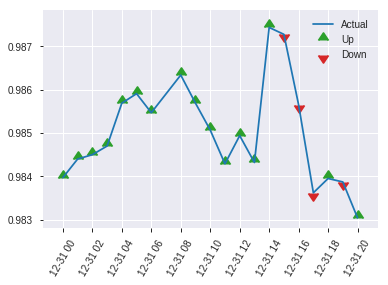


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2047812246379533
RMSE: 0.4525275954435854
LogLoss: 0.5981190046138536
Null degrees of freedom: 616
Residual degrees of freedom: 496
Null deviance: 854.9589870947052
Residual deviance: 738.0788516934952
AIC: 980.0788516934952
AUC: 0.7495250759878419
pr_auc: 0.7259208599240538
Gini: 0.4990501519756838
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3140142926893933: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      136  193  0.5866   (193.0/329.0)
1      32   256  0.1111   (32.0/288.0)
Total  168  449  0.3647   (225.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.314014     0.694708  286
max f2                       0.235306     0.821752  319
max f0point5                 0.626337     0.67637   139
max accuracy                 0.626337     0.688817  139
max precision                0.962226     1         0
max recall                   0.0161614    1         399
max specificity              0.962226     1         0
max absolute_mcc             0.626337     0.375132  139
max min_per_class_accuracy   0.513982     0.673611  190
max mean_per_class_accuracy  0.582313     0.68311   159

Gains/Lift Table: Avg response rate: 46.68 %, avg score: 49.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.929697           2.14236   2.14236            1                0.938586   1                           0.938586            0.0243056       0.0243056                  114.236   114.236
    2        0.0210697                   0.902402           1.7853    1.97756            0.833333         0.909341   0.923077                    0.925088            0.0173611       0.0416667                  78.5301   97.7564
    3        0.0307942                   0.889015           1.7853    1.91685            0.833333         0.894764   0.894737                    0.915512            0.0173611       0.0590278                  78.5301   91.6849
    4        0.0405186                   0.879448           2.14236   1.97097            1                0.883597   0.92                        0.907853            0.0208333       0.0798611                  114.236   97.0972
    5        0.0502431                   0.867669           1.7853    1.93504            0.833333         0.873824   0.903226                    0.901266            0.0173611       0.0972222                  78.5301   93.5036
    6        0.100486                    0.821026           1.79682   1.86593            0.83871          0.845513   0.870968                    0.87339             0.0902778       0.1875                     79.6819   86.5927
    7        0.150729                    0.778941           1.6586    1.79682            0.774194         0.803609   0.83871                     0.85013             0.0833333       0.270833                   65.8602   79.6819
    8        0.200972                    0.740952           1.45128   1.71043            0.677419         0.758459   0.798387                    0.827212            0.0729167       0.34375                    45.1277   71.0433
    9        0.299838                    0.668497           1.22922   1.55176            0.57377          0.709487   0.724324                    0.788395            0.121528        0.465278                   22.9224   55.1764
    10       0.400324                    0.58238            1.31306   1.49185            0.612903         0.628473   0.696356                    0.748252            0.131944        0.597222                   31.306    49.1847
    11       0.50081                     0.497127           0.863855  1.36584            0.403226         0.544099   0.63754                     0.707289            0.0868056       0.684028                   -13.6145  36.5842
    12       0.599676                    0.421341           0.948258  1.297              0.442623         0.459485   0.605405                    0.666435            0.09375         0.777778                   -5.17418  29.6997
    13       0.700162                    0.336551           0.863855  1.23483            0.403226         0.379929   0.576389                    0.625316            0.0868056       0.864583                   -13.6145  23.4833
    14       0.799028                    0.250195           0.632172  1.16026            0.295082         0.292508   0.541582                    0.584137            0.0625          0.927083                   -36.7828  16.0265
    15       0.899514                    0.162101           0.380096  1.07311            0.177419         0.206667   0.500901                    0.541969            0.0381944       0.965278                   -61.9904  7.31106
    16       1                           0.0161614          0.345542  1                  0.16129          0.0908586  0.466775                   

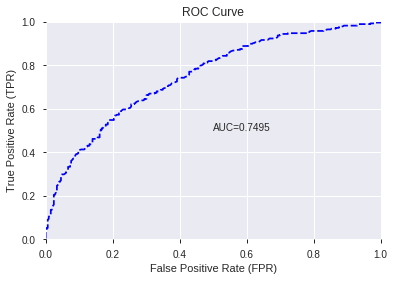

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


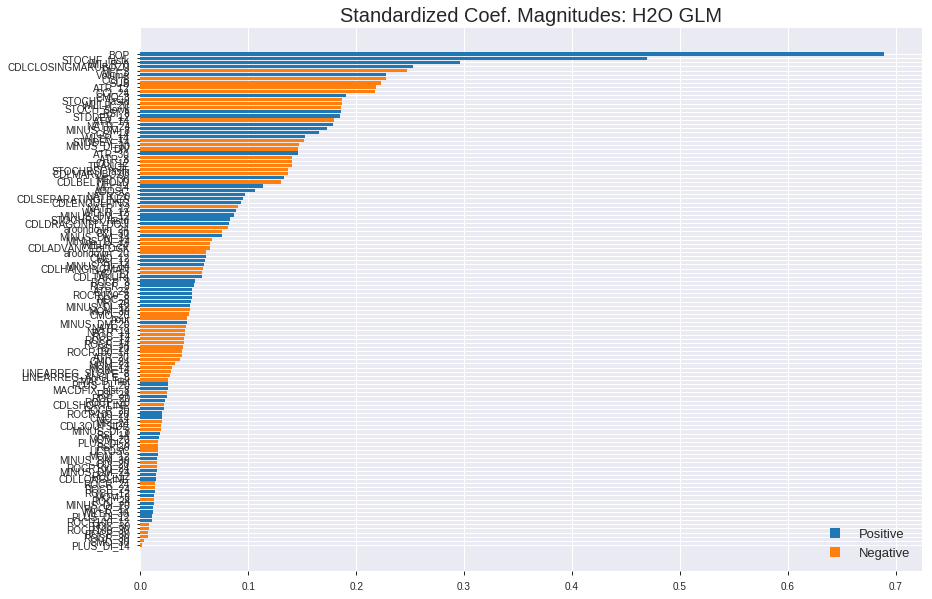

'log_likelihood'
--2019-08-24 15:18:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_151817_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_151817_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a4a9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'STOCHF_fastk',
 'WILLR_8',
 'CDLCLOSINGMARUBOZU',
 'MFI_8',
 'Volume',
 'CCI_8',
 'SUB',
 'ATR_12',
 'CCI_24',
 'CMO_8',
 'STOCHF_fastd',
 'WILLR_20',
 'STOCH_slowk',
 'RSI_8',
 'STDDEV_12',
 'ATR_14',
 'NATR_24',
 'MINUS_DM_8',
 'CCI_14',
 'WILLR_14',
 'STDDEV_14',
 'MINUS_DI_30',
 'DIV',
 'ATR_30',
 'ATR_8',
 'CCI_12',
 'TRANGE',
 'STOCHRSI_fastk',
 'CDLMARUBOZU',
 'MFI_30',
 'CDLBELTHOLD',
 'MFI_14',
 'ADOSC',
 'NATR_20',
 'CDLSEPARATINGLINES',
 'CDLENGULFING',
 'NATR_12',
 'WILLR_12',
 'MINUS_DM_12',
 'STOCHRSI_fastd',
 'CDLDRAGONFLYDOJI',
 'aroondown_24',
 'CCI_30',
 'MINUS_DM_14',
 'MINUS_DI_24',
 'WILLR_24',
 'CDLADVANCEBLOCK',
 'aroondown_20',
 'CMO_12',
 'RSI_12',
 'MINUS_DI_14',
 'CDLHANGINGMAN',
 'MFI_12',
 'CDLTAKURI',
 'ROCP_8',
 'ROCR_8',
 'ATR_24',
 'ROCR100_8',
 'ROC_8',
 'MFI_20',
 'MINUS_DI_12',
 'MOM_30',
 'CMO_20',
 'hour',
 'MINUS_DM_20',
 'NATR_8',
 'NATR_14',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'RSI_20',
 'ROCR100_14',
 'ATR_20',
 'CMO_24',
 'MOM_24',
 

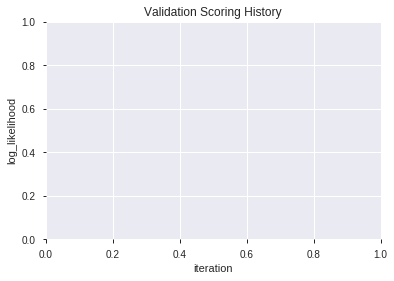

In [51]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_151927_model_2  0.758776  0.582234              0.314558  0.447155  0.199948
1  XGBoost_grid_1_AutoML_20190824_151927_model_3  0.758311  0.582730              0.318679  0.447150  0.199943
2  XGBoost_grid_1_AutoML_20190824_151927_model_6  0.756116  0.585102              0.327581  0.448465  0.201121
3               XGBoost_3_AutoML_20190824_151927  0.753620  0.586173              0.322157  0.448917  0.201526
4  XGBoost_grid_1_AutoML_20190824_151927_model_1  0.751958  0.588151              0.342141  0.449704  0.202233
5               XGBoost_1_AutoML_20190824_151927  0.751741  0.595105              0.308468  0.452228  0.204510
6               XGBoost_2_AutoML_20190824_151927  0.750607  0.594627              0.313244  0.451934  0.204245
7  XGBoost_grid_1_AutoML_20190824_151927_model_4  0.750559  0.591165              0.324985  0.450982  0.203385
8  XGBoost_grid_1_AutoML_20190824_151927_model_7  0.749694  0.595150              0.322589  0.452310  0.204584
9  XGBoost_grid_1_AutoML_20190824_151927_model_5  0.731051  0.625419              0.319539  0.465189  0.216401

variable  relative_importance  scaled_importance  percentage
0                BOP          6431.432129           1.000000    0.356736
1             TRANGE          1089.779907           0.169446    0.060447
2       STOCHF_fastk           920.761292           0.143166    0.051072
3               hour           806.756348           0.125440    0.044749
4                DIV           588.990479           0.091580    0.032670
..               ...                  ...                ...         ...
99           ROCP_12             4.660223           0.000725    0.000258
100           RSI_14             3.558166           0.000553    0.000197
101      CDL3OUTSIDE             3.139589           0.000488    0.000174
102      CDLMARUBOZU             3.100173           0.000482    0.000172
103  CDLADVANCEBLOCK             0.945212           0.000147    0.000052

[104 rows x 4 columns]

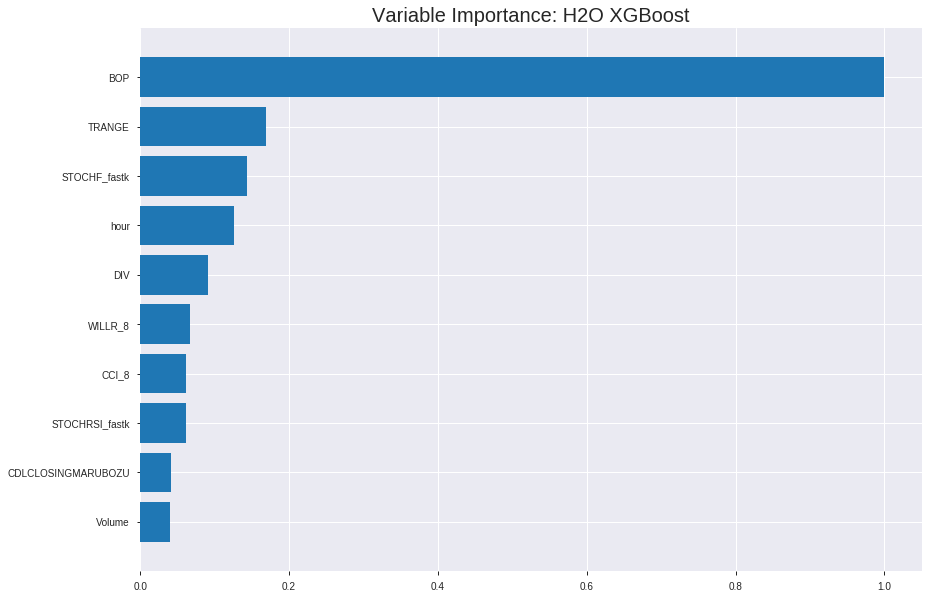

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_151927_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1589980641770605
RMSE: 0.398745613364035
LogLoss: 0.48915380156828975
Mean Per-Class Error: 0.2250896808047167
AUC: 0.8630694209636971
pr_auc: 0.8625255877100197
Gini: 0.7261388419273942
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4260920360684395: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1443  724   0.3341   (724.0/2167.0)
1      298   1848  0.1389   (298.0/2146.0)
Total  1741  2572  0.237    (1022.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426092     0.783383  233
max f2                       0.26723      0.872209  312
max f0point5                 0.57334      0.788061  162
max accuracy                 0.544979     0.775099  177
max precision                0.928778     1         0
max recall                   0.134096     1         372
max specificity              0.928778     1         0
max absolute_mcc             0.544979     0.551582  177
max min_per_class_accuracy   0.510881     0.768805  193
max mean_per_class_accuracy  0.544979     0.77491   177

Gains/Lift Table: Avg response rate: 49.76 %, avg score: 49.70 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.909751           2.00979    2.00979            1                0.918415  1                           0.918415            0.0205033       0.0205033                  100.979   100.979
    2        0.0201716                   0.892531           1.96305    1.98668            0.976744         0.90076   0.988506                    0.909689            0.0195713       0.0400746                  96.3046   98.6685
    3        0.0301414                   0.879279           1.91631    1.96341            0.953488         0.885761  0.976923                    0.901775            0.0191053       0.0591799                  91.6307   96.3406
    4        0.0401113                   0.865879           2.00979    1.97493            1                0.871577  0.982659                    0.894269            0.0200373       0.0792171                  100.979   97.4934
    5        0.0500812                   0.852919           1.96305    1.97257            0.976744         0.860308  0.981481                    0.887508            0.0195713       0.0987884                  96.3046   97.2567
    6        0.100162                    0.799587           1.96326    1.96792            0.976852         0.824502  0.979167                    0.856005            0.0983225       0.197111                   96.3263   96.7915
    7        0.150012                    0.754371           1.86022    1.93213            0.925581         0.775691  0.96136                     0.829317            0.0927307       0.289842                   86.022    93.2128
    8        0.200093                    0.721576           1.73995    1.88403            0.865741         0.737406  0.937428                    0.806312            0.0871389       0.37698                    73.9953   88.4028
    9        0.300023                    0.655127           1.59477    1.78768            0.793503         0.689486  0.88949                     0.7674              0.159366        0.536347                   59.4772   78.7684
    10       0.399954                    0.584891           1.26369    1.65676            0.62877          0.62126   0.824348                    0.730886            0.126281        0.662628                   26.3694   65.6762
    11       0.500116                    0.510111           1.09329    1.54391            0.543981         0.548458  0.768197                    0.69435             0.109506        0.772134                   9.32862   54.391
    12       0.600046                    0.422731           0.913963   1.439              0.454756         0.465487  0.715997                    0.656236            0.0913327       0.863467                   -8.60372  43.9
    13       0.699977                    0.333766           0.648168   1.3261             0.322506         0.378113  0.659821                    0.61653             0.0647717       0.928239                   -35.1832  32.6099
    14       0.799907                    0.260805           0.494286   1.22218            0.24594          0.298376  0.608116                    0.576784            0.0493942       0.977633                   -50.5714  22.2183
    15       0.899838                    0.185814           0.195849   1.1082             0.0974478        0.225574  0.551404                    0.537781            0.0195713       0.997204                   -80.4151  10.8204
    16       1                           0.0623249          0.0279137  1                  0.0138889        0.130939  0.497565                    0.4



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19735858412498428
RMSE: 0.44425058708456905
LogLoss: 0.5807541511613143
Mean Per-Class Error: 0.2881967905405405
AUC: 0.7632984058277027
pr_auc: 0.7419513811265471
Gini: 0.5265968116554054
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46930615107218426: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      369  223  0.3767   (223.0/592.0)
1      134  506  0.2094   (134.0/640.0)
Total  503  729  0.2898   (357.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.469306     0.739226  225
max f2                       0.216781     0.85463   337
max f0point5                 0.604143     0.728245  159
max accuracy                 0.497809     0.713474  211
max precision                0.87991      0.870968  15
max recall                   0.0813957    1         394
max specificity              0.929108     0.998311  0
max absolute_mcc             0.495729     0.425556  212
max min_per_class_accuracy   0.531459     0.695312  194
max mean_per_class_accuracy  0.497809     0.711803  211

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 51.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.903176           1.33269   1.33269            0.692308         0.914559  0.692308                    0.914559            0.0140625       0.0140625                  33.2692   33.2692
    2        0.0202922                   0.88898            1.925     1.617              1                0.894444  0.84                        0.904904            0.01875         0.0328125                  92.5      61.7
    3        0.0300325                   0.874834           1.60417   1.61284            0.833333         0.880207  0.837838                    0.896894            0.015625        0.0484375                  60.4167   61.2838
    4        0.0405844                   0.861737           1.62885   1.617              0.846154         0.868465  0.84                        0.889503            0.0171875       0.065625                   62.8846   61.7
    5        0.0503247                   0.853408           1.76458   1.64556            0.916667         0.857673  0.854839                    0.883342            0.0171875       0.0828125                  76.4583   64.5565
    6        0.100649                    0.809634           1.49032   1.56794            0.774194         0.829178  0.814516                    0.85626             0.075           0.157812                   49.0323   56.7944
    7        0.150162                    0.774996           1.42008   1.51919            0.737705         0.791289  0.789189                    0.834837            0.0703125       0.228125                   42.0082   51.9189
    8        0.200487                    0.741719           1.42823   1.49636            0.741935         0.757543  0.777328                    0.815435            0.071875        0.3                        42.8226   49.6356
    9        0.300325                    0.676938           1.45549   1.48277            0.756098         0.704458  0.77027                     0.778543            0.145313        0.445312                   45.5488   48.277
    10       0.400162                    0.620898           1.45549   1.47596            0.756098         0.647657  0.766734                    0.745888            0.145313        0.590625                   45.5488   47.5963
    11       0.5                         0.532696           1.01728   1.38438            0.528455         0.575908  0.719156                    0.711947            0.101562        0.692187                   1.72764   38.4375
    12       0.599838                    0.455266           1.03293   1.32588            0.536585         0.498503  0.688769                    0.676421            0.103125        0.795312                   3.29268   32.588
    13       0.699675                    0.359411           0.641667  1.22825            0.333333         0.40672   0.638051                    0.637937            0.0640625       0.859375                   -35.8333  22.8248
    14       0.799513                    0.280005           0.641667  1.155              0.333333         0.321578  0.6                         0.598433            0.0640625       0.923438                   -35.8333  15.5
    15       0.899351                    0.195137           0.547764  1.08759            0.284553         0.239609  0.564982                    0.558599            0.0546875       0.978125                   -45.2236  8.75903
    16       1                           0.0668425          0.217339  1                  0.112903         0.142582  0.519481                    0.516727            0.021875


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 15:19:39  1.690 sec   0                  0.5              0.693147            0.5             0                  1                0.502435                         0.5                0.693147              0.5               0                    1                  0.480519
    2019-08-24 15:19:39  1.845 sec   5                  0.477713         0.649364            0.804983        0.770068           1.95472          0.279156                         0.482203           0.658038              0.747539          0.716075             1.35882            0.316558
    2019-08-24 15:19:39  1.936 sec   10                 0.461143         0.61733             0.808933        0.775311           1.95067          0.273823                         0.470175           0.634489              0.747297          0.716652             1.44375            0.326299
    2019-08-24 15:19:39  2.131 sec   15                 0.449977         0.595538            0.814258        0.787067           2.00979          0.265013                         0.462647           0.619539              0.751288          0.725338             1.48077            0.321429
    2019-08-24 15:19:39  2.240 sec   20                 0.441143         0.577974            0.818361        0.799203           2.00979          0.257361                         0.457795           0.609575              0.751254          0.728511             1.48077            0.316558
    2019-08-24 15:19:39  2.358 sec   25                 0.434383         0.564234            0.822467        0.808868           2.00979          0.25597                          0.454381           0.602395              0.753341          0.732837             1.48077            0.31737
    2019-08-24 15:19:39  2.462 sec   30                 0.428561         0.55206             0.827084        0.818769           2.00979          0.281475                         0.451667           0.596552              0.755182          0.735705             1.48077            0.313312
    2019-08-24 15:19:39  2.566 sec   35                 0.424008         0.542387            0.830861        0.823963           2.00979          0.254579                         0.450079           0.592993              0.755457          0.736689             1.48077            0.3125
    2019-08-24 15:19:40  2.674 sec   40                 0.419925         0.533659            0.834815        0.83057            2.00979          0.267563                         0.44854            0.589587              0.757014          0.737003             1.48077            0.310877
    2019-08-24 15:19:40  2.785 sec   45                 0.41639          0.526024            0.838493        0.835261           2.00979          0.248783                         0.447344           0.587084              0.758713          0.737544             1.48077            0.311688
    2019-08-24 15:19:40  2.898 sec   50                 0.41305          0.51891             0.842808        0.840051           2.00979          0.244841                         0.446481           0.585136              0.759742          0.739961             1.48077            0.318994
    2019-08-24 15:19:40  3.011 sec   55                 0.409941         0.512274            0.846754        0.844709           2.00979          0.237654                         0.445806           0.583723              0.760671          0.74

Variable Importances: 


variable         relative_importance    scaled_importance       percentage
---------------  ---------------------  ----------------------  ----------------------
BOP              6431.43212890625       1.0                     0.35673615725774227
TRANGE           1089.7799072265625     0.1694459158370834      0.06044748487873994
STOCHF_fastk     920.7612915039062      0.143165825752171       0.05107242652946099
hour             806.75634765625        0.12543961150274155     0.0447488449753921
DIV              588.990478515625       0.09157998820642        0.032669893074467625
---              ---                    ---                     ---
ROCP_12          4.660223484039307      0.0007246012071081032   0.00025849145016806614
RSI_14           3.5581657886505127     0.0005532462626260547   0.00019736294574642638
CDL3OUTSIDE      3.1395885944366455     0.0004881632164515392   0.00017414546995150158
CDLMARUBOZU      3.100172996520996      0.0004820346284285863   0.00017195918101077753
CDLADVANCEBLOCK  0.9452124834060669     0.00014696765268777123  5.2428675661026e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6936790923824959)

('F1', 0.7099567099567099)

('auc', 0.7587755403579871)

('logloss', 0.582234144772832)

('mean_per_class_error', 0.30108071597433295)

('rmse', 0.44715494732888866)

('mse', 0.1999475469207012)

xgboost prediction progress: |████████████████████████████████████████████| 100%


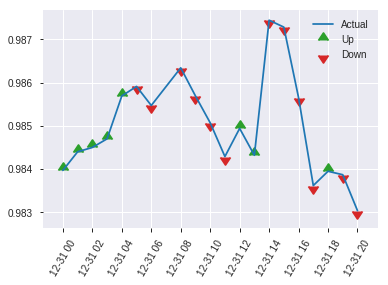


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1999475469207012
RMSE: 0.44715494732888866
LogLoss: 0.582234144772832
Mean Per-Class Error: 0.30108071597433295
AUC: 0.7587755403579871
pr_auc: 0.731919509889533
Gini: 0.5175510807159742
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3597494065761566: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      170  159  0.4833   (159.0/329.0)
1      42   246  0.1458   (42.0/288.0)
Total  212  405  0.3258   (201.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.359749     0.709957  266
max f2                       0.191448     0.831389  359
max f0point5                 0.642949     0.667293  128
max accuracy                 0.45092      0.693679  224
max precision                0.933524     1         0
max recall                   0.108166     1         391
max specificity              0.933524     1         0
max absolute_mcc             0.438353     0.400425  230
max min_per_class_accuracy   0.509013     0.671733  196
max mean_per_class_accuracy  0.438353     0.698919  230

Gains/Lift Table: Avg response rate: 46.68 %, avg score: 49.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.910866           2.14236   2.14236            1                0.921503  1                           0.921503            0.0243056       0.0243056                  114.236   114.236
    2        0.0210697                   0.898392           1.7853    1.97756            0.833333         0.903035  0.923077                    0.912979            0.0173611       0.0416667                  78.5301   97.7564
    3        0.0307942                   0.889669           2.14236   2.02961            1                0.893823  0.947368                    0.90693             0.0208333       0.0625                     114.236   102.961
    4        0.0405186                   0.872701           2.14236   2.05667            1                0.88157   0.96                        0.900844            0.0208333       0.0833333                  114.236   105.667
    5        0.0502431                   0.858544           1.7853    2.00414            0.833333         0.865483  0.935484                    0.894               0.0173611       0.100694                   78.5301   100.414
    6        0.100486                    0.805215           1.86593   1.93504            0.870968         0.83166   0.903226                    0.86283             0.09375         0.194444                   86.5927   93.5036
    7        0.150729                    0.773035           1.31306   1.72771            0.612903         0.787656  0.806452                    0.837772            0.0659722       0.260417                   31.306    72.7711
    8        0.200972                    0.734742           1.52039   1.67588            0.709677         0.754858  0.782258                    0.817043            0.0763889       0.336806                   52.0385   67.5879
    9        0.299838                    0.659117           1.29946   1.55176            0.606557         0.696387  0.724324                    0.777259            0.128472        0.465278                   29.9465   55.1764
    10       0.400324                    0.580843           1.14029   1.44848            0.532258         0.616923  0.676113                    0.737013            0.114583        0.579861                   14.0289   44.8479
    11       0.50081                     0.500113           1.07118   1.37278            0.5              0.542246  0.640777                    0.697934            0.107639        0.6875                     7.11806   37.2775
    12       0.599676                    0.405027           1.12386   1.33174            0.52459          0.449687  0.621622                    0.657007            0.111111        0.798611                   12.3862   33.1738
    13       0.700162                    0.330847           0.760193  1.24971            0.354839         0.363948  0.583333                    0.614947            0.0763889       0.875                      -23.9807  24.9711
    14       0.799028                    0.259916           0.52681   1.16026            0.245902         0.294211  0.541582                    0.575262            0.0520833       0.927083                   -47.319   16.0265
    15       0.899514                    0.194902           0.518313  1.08855            0.241935         0.226064  0.508108                    0.536252            0.0520833       0.979167                   -48.1687  8.85511
    16       1                           0.0715344          0.207325  1                  0.0967742        0.148044  0.466775                    0.497243         

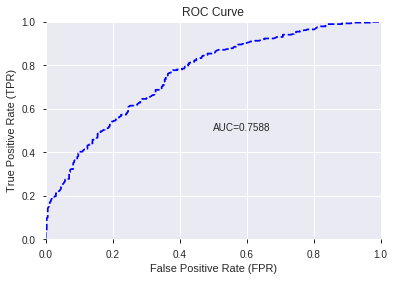

This function is available for GLM models only


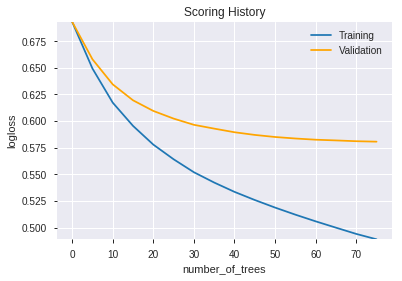

--2019-08-24 15:20:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.38.92
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.38.92|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.jav

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_151927_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_151927_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a4a9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'hour',
 'DIV',
 'WILLR_8',
 'CCI_8',
 'STOCHRSI_fastk',
 'CDLCLOSINGMARUBOZU',
 'Volume',
 'SUB',
 'ADOSC',
 'ULTOSC',
 'STOCHRSI_fastd',
 'MFI_8',
 'STOCH_slowk',
 'ATR_30',
 'LINEARREG_ANGLE_8',
 'MFI_20',
 'MINUS_DI_8',
 'CCI_12',
 'MACDFIX_hist_8',
 'MFI_24',
 'MFI_14',
 'PLUS_DI_8',
 'MFI_12',
 'ATR_8',
 'MINUS_DM_30',
 'CCI_24',
 'MACD_hist',
 'CCI_30',
 'MFI_30',
 'STDDEV_12',
 'MINUS_DI_30',
 'MOM_30',
 'WILLR_12',
 'STDDEV_14',
 'MOM_14',
 'CDLSHORTLINE',
 'NATR_8',
 'NATR_14',
 'CCI_20',
 'aroondown_24',
 'MOM_20',
 'CMO_14',
 'CCI_14',
 'MOM_12',
 'PLUS_DI_12',
 'MOM_8',
 'ATR_12',
 'CMO_8',
 'MINUS_DM_8',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'ROC_14',
 'ATR_20',
 'MOM_24',
 'MINUS_DI_14',
 'WILLR_14',
 'MINUS_DM_20',
 'MINUS_DM_14',
 'MINUS_DI_20',
 'NATR_20',
 'WILLR_20',
 'PLUS_DI_20',
 'aroondown_20',
 'MINUS_DM_24',
 'CMO_30',
 'PLUS_DI_14',
 'NATR_12',
 'ATR_24',
 'NATR_24',
 'CMO_20',
 'LINEARREG_SLOPE_8',
 'CDLBELTHOLD',
 'CMO_12'

In [52]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [53]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

75

['WMA_12',
 'BBANDS_lowerband_12_0_5',
 'BBANDS_middleband_12_4_5',
 'BBANDS_lowerband_12_6_2',
 'BBANDS_lowerband_20_0_4',
 'BOP',
 'aroondown_8',
 'aroonup_8',
 'AROONOSC_8',
 'CCI_8',
 'MINUS_DM_8',
 'MOM_8',
 'PLUS_DM_8',
 'WILLR_8',
 'aroondown_12',
 'aroonup_12',
 'MFI_12',
 'PLUS_DM_12',
 'ROCP_12',
 'ROCR_12',
 'TRIX_12',
 'WILLR_12',
 'ADX_14',
 'aroondown_14',
 'AROONOSC_14',
 'CCI_14',
 'MFI_14',
 'MINUS_DM_14',
 'MOM_14',
 'ROCR_14',
 'WILLR_14',
 'ADX_20',
 'MINUS_DI_20',
 'PLUS_DI_20',
 'WILLR_20',
 'aroonup_24',
 'CCI_24',
 'MACDFIX_hist_24',
 'ROCR_24',
 'WILLR_24',
 'aroondown_30',
 'aroonup_30',
 'AROONOSC_30',
 'CCI_30',
 'DX_30',
 'MFI_30',
 'MINUS_DI_30',
 'MINUS_DM_30',
 'MOM_30',
 'ROCR_30',
 'MACD',
 'STOCH_slowk',
 'STOCH_slowd',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'NATR_12',
 'ATR_30',
 'TRANGE',
 'HT_PHASOR_quadrature',
 'CDLCLOSINGMARUBOZU',
 'CDLSHORTLINE',
 'CDLSPINNINGTOP',
 'VAR_8',
 'LINEARREG_ANGLE_12',
 'LINEARREG_

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_152528_model_9  0.747515  0.597012              0.319328  0.451353  0.203720
1  DeepLearning_grid_1_AutoML_20190824_152528_model_6  0.741620  0.599630              0.371676  0.453950  0.206070
2  DeepLearning_grid_1_AutoML_20190824_152528_model_8  0.738982  0.613664              0.331703  0.459280  0.210938
3  DeepLearning_grid_1_AutoML_20190824_152528_model_5  0.738122  0.609060              0.325840  0.458813  0.210509
4               DeepLearning_1_AutoML_20190824_152528  0.734148  0.623526              0.304126  0.463017  0.214385
5  DeepLearning_grid_1_AutoML_20190824_152528_model_3  0.726533  0.652122              0.355813  0.467721  0.218763
6  DeepLearning_grid_1_AutoML_20190824_152528_model_4  0.722528  0.732779              0.328009  0.486057  0.236251
7  DeepLearning_grid_1_AutoML_20190824_152528_model_2  0.719299  0.725290              0.343433  0.481630  0.231968
8  DeepLearning_grid_1_AutoML_20190824_152528_model_7  0.712112  0.724516              0.384045  0.485751  0.235954
9  DeepLearning_grid_1_AutoML_20190824_152528_model_1  0.687996  0.847238              0.383385  0.512888  0.263054

variable  relative_importance  scaled_importance  percentage
0   CDLCLOSINGMARUBOZU             1.000000           1.000000    0.047560
1                  BOP             0.912972           0.912972    0.043421
2         CDLSHORTLINE             0.476522           0.476522    0.022664
3         STOCHF_fastk             0.472671           0.472671    0.022480
4                  DIV             0.396731           0.396731    0.018869
..                 ...                  ...                ...         ...
70              MOM_14             0.218044           0.218044    0.010370
71  LINEARREG_SLOPE_14             0.217199           0.217199    0.010330
72         MINUS_DI_20             0.217017           0.217017    0.010321
73  LINEARREG_ANGLE_12             0.215164           0.215164    0.010233
74             ROCR_14             0.212510           0.212510    0.010107

[75 rows x 4 columns]

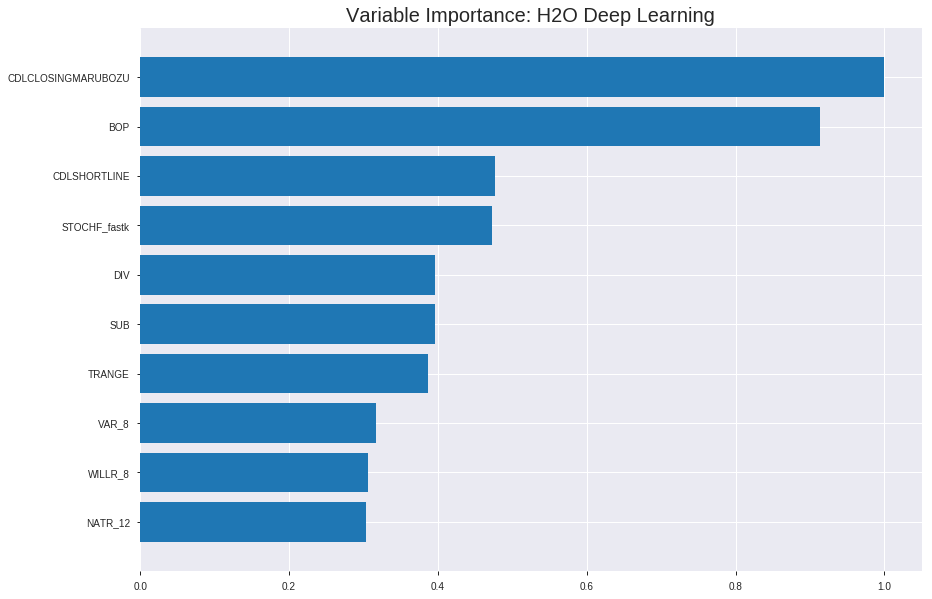

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_152528_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19409009787721135
RMSE: 0.44055657738502935
LogLoss: 0.5704119697495281
Mean Per-Class Error: 0.293144412652552
AUC: 0.7784197083164351
pr_auc: 0.7690829812813659
Gini: 0.5568394166328703
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35007255666923753: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1081  1086  0.5012   (1086.0/2167.0)
1      264   1882  0.123    (264.0/2146.0)
Total  1345  2968  0.313    (1350.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.350073     0.736019  251
max f2                       0.133459     0.844681  352
max f0point5                 0.496248     0.711046  176
max accuracy                 0.485463     0.706933  183
max precision                0.894031     1         0
max recall                   0.0454145    1         390
max specificity              0.894031     1         0
max absolute_mcc             0.451268     0.416922  204
max min_per_class_accuracy   0.480563     0.703635  186
max mean_per_class_accuracy  0.485463     0.706856  183

Gains/Lift Table: Avg response rate: 49.76 %, avg score: 45.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.869817           2.00979   2.00979            1                0.877694   1                           0.877694            0.0205033       0.0205033                  100.979   100.979
    2        0.0201716                   0.862502           1.77609   1.89428            0.883721         0.866244   0.942529                    0.872035            0.0177074       0.0382106                  77.609    89.4281
    3        0.0301414                   0.853426           1.86957   1.88611            0.930233         0.857439   0.938462                    0.867207            0.0186393       0.05685                    86.9568   88.6107
    4        0.0401113                   0.841131           1.86957   1.882              0.930233         0.847447   0.936416                    0.862295            0.0186393       0.0754893                  86.9568   88.1996
    5        0.0500812                   0.825728           1.72935   1.85161            0.860465         0.834202   0.921296                    0.856703            0.0172414       0.0927307                  72.935    85.1608
    6        0.100162                    0.723491           1.73995   1.79578            0.865741         0.756651   0.893519                    0.806677            0.0871389       0.17987                    73.9953   79.5781
    7        0.150012                    0.688031           1.55174   1.71469            0.772093         0.704933   0.853168                    0.772867            0.0773532       0.257223                   55.1741   71.4686
    8        0.200093                    0.656197           1.57247   1.67909            0.782407         0.672872   0.835458                    0.747839            0.0787512       0.335974                   57.2471   67.9091
    9        0.300023                    0.581132           1.30566   1.55471            0.649652         0.617627   0.77357                     0.704469            0.130475        0.466449                   30.5661   55.4711
    10       0.399954                    0.522385           1.27768   1.48549            0.635731         0.549954   0.73913                     0.665862            0.127679        0.594129                   27.7683   48.5494
    11       0.500116                    0.479344           1.1212    1.41253            0.55787          0.497857   0.702828                    0.632215            0.112302        0.706431                   12.12     41.2534
    12       0.600046                    0.435847           0.937278  1.33339            0.466357         0.46098    0.663447                    0.603698            0.0936626       0.800093                   -6.27218  33.3386
    13       0.699977                    0.334982           0.839354  1.26286            0.417633         0.389315   0.628354                    0.573092            0.083877        0.88397                    -16.0646  26.2856
    14       0.799907                    0.227007           0.540917  1.17267            0.269142         0.277477   0.583478                    0.536161            0.0540541       0.938024                   -45.9083  17.2666
    15       0.899838                    0.135597           0.429003  1.09008            0.213457         0.182154   0.542386                    0.496848            0.0428705       0.980895                   -57.0997  9.00796
    16       1                           0.0108367          0.190744  1                  0.0949074        0.0890408  0.497565                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20680991546628483
RMSE: 0.4547635819481204
LogLoss: 0.6007402513808199
Mean Per-Class Error: 0.307200168918919
AUC: 0.7482131545608108
pr_auc: 0.738537075386888
Gini: 0.49642630912162167
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2526268198332901: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      214  378  0.6385   (378.0/592.0)
1      55   585  0.0859   (55.0/640.0)
Total  269  963  0.3515   (433.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.252627     0.729881  301
max f2                       0.162242     0.851852  343
max f0point5                 0.502615     0.706967  180
max accuracy                 0.466207     0.694805  206
max precision                0.859874     0.888889  8
max recall                   0.0387183    1         395
max specificity              0.887691     0.998311  0
max absolute_mcc             0.466207     0.388061  206
max min_per_class_accuracy   0.488773     0.689063  190
max mean_per_class_accuracy  0.478406     0.6928    198

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 46.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.868363           1.62885   1.62885            0.846154         0.876719   0.846154                    0.876719            0.0171875       0.0171875                  62.8846   62.8846
    2        0.0202922                   0.853981           1.60417   1.617              0.833333         0.859775   0.84                        0.868586            0.015625        0.0328125                  60.4167   61.7
    3        0.0300325                   0.839556           1.60417   1.61284            0.833333         0.847807   0.837838                    0.861847            0.015625        0.0484375                  60.4167   61.2838
    4        0.0405844                   0.83305            1.77692   1.6555             0.923077         0.836953   0.86                        0.855374            0.01875         0.0671875                  77.6923   65.55
    5        0.0503247                   0.822127           1.60417   1.64556            0.833333         0.827843   0.854839                    0.850046            0.015625        0.0828125                  60.4167   64.5565
    6        0.100649                    0.725278           1.70766   1.67661            0.887097         0.761827   0.870968                    0.805936            0.0859375       0.16875                    70.7661   67.6613
    7        0.150162                    0.691827           1.32541   1.56081            0.688525         0.709063   0.810811                    0.773994            0.065625        0.234375                   32.541    56.0811
    8        0.200487                    0.661671           1.39718   1.51974            0.725806         0.677322   0.789474                    0.749728            0.0703125       0.304688                   39.7177   51.9737
    9        0.300325                    0.592149           1.37724   1.47236            0.715447         0.630049   0.764865                    0.709943            0.1375          0.442188                   37.7236   47.2365
    10       0.400162                    0.535983           1.23638   1.41349            0.642276         0.559991   0.73428                     0.672531            0.123438        0.565625                   23.6382   41.3489
    11       0.5                         0.489647           1.17378   1.36563            0.609756         0.510107   0.709416                    0.640099            0.117188        0.682813                   17.378    36.5625
    12       0.599838                    0.451824           0.892073  1.28681            0.463415         0.470928   0.668471                    0.611942            0.0890625       0.771875                   -10.7927  28.6806
    13       0.699675                    0.3552             0.76687   1.21262            0.398374         0.412144   0.62993                     0.583432            0.0765625       0.848437                   -23.313   21.2616
    14       0.799513                    0.23282            0.704268  1.14914            0.365854         0.287883   0.596954                    0.546526            0.0703125       0.91875                    -29.5732  14.9137
    15       0.899351                    0.140551           0.547764  1.08238            0.284553         0.187119   0.562274                    0.506628            0.0546875       0.973437                   -45.2236  8.23782
    16       1                           0.0232418          0.263911  1                  0.137097         0.0976353  0.519481                    0.46


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 15:41:12  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 15:41:16  7 min  3.404 sec   373 obs/sec       0.273823  1             1181       0.504636         0.805226            -0.0186523     0.743868        0.727              1.87275          0.322745                         0.521198           0.871399              -0.0882398       0.718984          0.716153             1.62885            0.366883
    2019-08-24 15:42:09  7 min 57.386 sec   568 obs/sec       6.82379   25            29431      0.452515         0.596773            0.180902       0.764586        0.756699           1.91843          0.33828                          0.46034            0.612399              0.151058         0.738384          0.737929             1.77692            0.346591
    2019-08-24 15:43:04  8 min 51.433 sec   667 obs/sec       15.5738   57            67170      0.440557         0.570412            0.223621       0.77842         0.769083           2.00979          0.313007                         0.454764           0.60074               0.171503         0.748213          0.738537             1.62885            0.351461
    2019-08-24 15:43:56  9 min 44.490 sec   727 obs/sec       24.9404   91            107568     0.436003         0.562767            0.239586       0.783969        0.772449           1.87275          0.311384                         0.455881           0.607538              0.167425         0.748069          0.73904              1.62885            0.339286
    2019-08-24 15:44:54  10 min 43.684 sec  772 obs/sec       35.9114   131           154886     0.434104         0.559161            0.246195       0.791896        0.781206           1.96411          0.293299                         0.458379           0.616321              0.158278         0.742574          0.736434             1.62885            0.356331
    2019-08-24 15:46:02  11 min 49.690 sec  811 obs/sec       49.1551   179           212006     0.428484         0.544249            0.265587       0.801213        0.792883           2.00979          0.281011                         0.454554           0.605444              0.172266         0.746123          0.73978              1.62885            0.304383
    2019-08-24 15:46:56  12 min 43.567 sec  836 obs/sec       60.0802   219           259126     0.426068         0.538612            0.273846       0.803786        0.790937           1.96411          0.294922                         0.459402           0.618621              0.154515         0.736958          0.723723             1.48077            0.327922
    2019-08-24 15:47:01  12 min 49.049 sec  836 obs/sec       60.0802   219           259126     0.440557         0.570412            0.223621       0.77842         0.769083           2.00979          0.313007                         0.454764           0.60074               0.171503         0.748213          0.738537             1.62885            0.351461

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.04756029878391466
BOP                 0.9129717350006104     0.9129717350006104   0.04342120849789799
CDLSHORTLINE        0.4765220284461975     0.4765220284461975   0.022663530050018237
STOCHF_fastk        0.47267135977745056    0.47267135977745056  0.022480391097614773
DIV                 0.39673134684562683    0.39673134684562683  0.018868661392922894
---                 ---                    ---                  ---
MOM_14              0.2180439531803131     0.2180439531803131   0.01037023556128159
LINEARREG_SLOPE_14  0.2171991467475891     0.2171991467475891   0.010330056314926665
MINUS_DI_20         0.2170170098543167     0.2170170098543167   0.010321393829863055
LINEARREG_ANGLE_12  0.21516422927379608    0.21516422927379608  0.01023327503187246
ROCR_14             0.21251045167446136    0.21251045167446136  0.010107060576342041


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6969205834683955)

('F1', 0.7010309278350516)

('auc', 0.7475145643363729)

('logloss', 0.5970118770310574)

('mean_per_class_error', 0.3086425616345829)

('rmse', 0.45135304900629347)

('mse', 0.20371957484727754)

deeplearning prediction progress: |███████████████████████████████████████| 100%


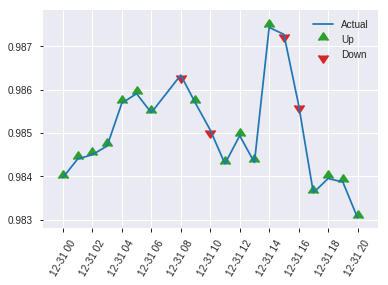


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20371957484727754
RMSE: 0.45135304900629347
LogLoss: 0.5970118770310574
Mean Per-Class Error: 0.3086425616345829
AUC: 0.7475145643363729
pr_auc: 0.7121774717656485
Gini: 0.49502912867274573
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36672843519281756: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      176  153  0.465    (153.0/329.0)
1      50   238  0.1736   (50.0/288.0)
Total  226  391  0.329    (203.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.366728     0.701031  246
max f2                       0.167013     0.822972  341
max f0point5                 0.515052     0.681464  162
max accuracy                 0.515052     0.696921  162
max precision                0.882664     1         0
max recall                   0.0127835    1         399
max specificity              0.882664     1         0
max absolute_mcc             0.515052     0.389176  162
max min_per_class_accuracy   0.483123     0.683891  188
max mean_per_class_accuracy  0.515052     0.691357  162

Gains/Lift Table: Avg response rate: 46.68 %, avg score: 44.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.868428           2.14236   2.14236            1                0.87494    1                           0.87494             0.0243056       0.0243056                  114.236   114.236
    2        0.0210697                   0.860527           1.7853    1.97756            0.833333         0.862639   0.923077                    0.869262            0.0173611       0.0416667                  78.5301   97.7564
    3        0.0307942                   0.853348           2.14236   2.02961            1                0.858262   0.947368                    0.865789            0.0208333       0.0625                     114.236   102.961
    4        0.0405186                   0.841583           1.7853    1.97097            0.833333         0.847055   0.92                        0.861292            0.0173611       0.0798611                  78.5301   97.0972
    5        0.0502431                   0.824234           1.7853    1.93504            0.833333         0.833723   0.903226                    0.855956            0.0173611       0.0972222                  78.5301   93.5036
    6        0.100486                    0.731246           1.58949   1.76226            0.741935         0.769657   0.822581                    0.812807            0.0798611       0.177083                   58.9494   76.2265
    7        0.150729                    0.699631           1.52039   1.68164            0.709677         0.717144   0.784946                    0.780919            0.0763889       0.253472                   52.0385   68.1638
    8        0.200972                    0.672572           1.72771   1.69316            0.806452         0.686872   0.790323                    0.757407            0.0868056       0.340278                   72.7711   69.3156
    9        0.299838                    0.585217           1.22922   1.54018            0.57377          0.625093   0.718919                    0.713779            0.121528        0.461806                   22.9224   54.0184
    10       0.400324                    0.515482           1.38217   1.50052            0.645161         0.546088   0.700405                    0.671687            0.138889        0.600694                   38.2168   50.052
    11       0.50081                     0.475767           0.932964  1.38664            0.435484         0.494125   0.647249                    0.636059            0.09375         0.694444                   -6.70363  38.6641
    12       0.599676                    0.397972           0.878017  1.30279            0.409836         0.441188   0.608108                    0.603932            0.0868056       0.78125                    -12.1983  30.2787
    13       0.700162                    0.305135           0.863855  1.23979            0.403226         0.351681   0.578704                    0.567729            0.0868056       0.868056                   -13.6145  23.9792
    14       0.799028                    0.207909           0.561931  1.15592            0.262295         0.2532     0.539554                    0.528812            0.0555556       0.923611                   -43.8069  15.5919
    15       0.899514                    0.136086           0.483759  1.08083            0.225806         0.177365   0.504505                    0.489551            0.0486111       0.972222                   -51.6241  8.08308
    16       1                           0.0127835          0.276434  1                  0.129032         0.0898795  0.466775                    

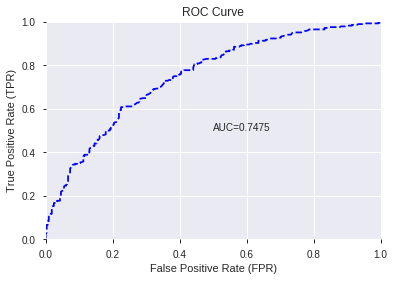

This function is available for GLM models only


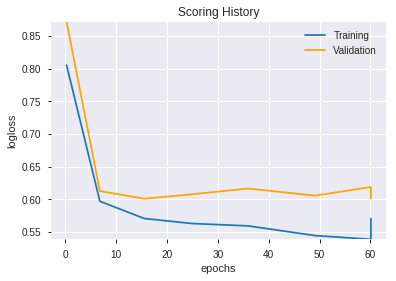

--2019-08-24 15:47:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_152528_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_152528_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a4a9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'CDLSHORTLINE',
 'STOCHF_fastk',
 'DIV',
 'SUB',
 'TRANGE',
 'VAR_8',
 'WILLR_8',
 'NATR_12',
 'CCI_8',
 'WILLR_12',
 'STOCHRSI_fastk',
 'ADX_20',
 'WILLR_14',
 'BETA_30',
 'aroonup_24',
 'aroondown_14',
 'MOM_8',
 'BBANDS_middleband_12_4_5',
 'VAR_14',
 'BETA_24',
 'CCI_30',
 'aroonup_12',
 'ADX_14',
 'STDDEV_14',
 'aroonup_30',
 'ATR_30',
 'aroonup_8',
 'CCI_24',
 'AROONOSC_30',
 'PLUS_DM_8',
 'MINUS_DM_30',
 'DX_30',
 'aroondown_8',
 'STOCH_slowd',
 'HT_PHASOR_quadrature',
 'MFI_14',
 'WMA_12',
 'aroondown_30',
 'MFI_30',
 'MFI_12',
 'AROONOSC_14',
 'BBANDS_lowerband_20_0_4',
 'STOCH_slowk',
 'STOCHRSI_fastd',
 'PLUS_DM_12',
 'aroondown_12',
 'CDLSPINNINGTOP',
 'STOCHF_fastd',
 'ROCP_12',
 'WILLR_24',
 'MINUS_DM_14',
 'MACD',
 'ROCR_30',
 'MOM_30',
 'CCI_14',
 'ROCR_12',
 'MINUS_DM_8',
 'PLUS_DI_20',
 'BBANDS_lowerband_12_6_2',
 'BBANDS_lowerband_12_0_5',
 'ROCR_24',
 'AROONOSC_8',
 'WILLR_20',
 'LINEARREG_SLOPE_20',
 'MACDFIX_hist_24',
 'MINUS_DI_30'

In [54]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_154814_model_1  0.740137  0.60828              0.355169  0.456779  0.208647

variable  relative_importance  scaled_importance  percentage
0   BBANDS_lowerband_12_6_2             1.112548           1.000000    0.057245
1                   NATR_12             0.932718           0.838362    0.047992
2                   TRIX_12             0.910813           0.818673    0.046865
3                    MOM_30             0.850066           0.764071    0.043739
4                   ROCR_30             0.807335           0.725663    0.041541
..                      ...                  ...                ...         ...
70     HT_PHASOR_quadrature             0.027899           0.025076    0.001435
71                    DX_30             0.026994           0.024263    0.001389
72              aroondown_8             0.015147           0.013615    0.000779
73             CDLSHORTLINE             0.008709           0.007828    0.000448
74                   TRANGE             0.006249           0.005617    0.000322

[75 rows x 4 columns]

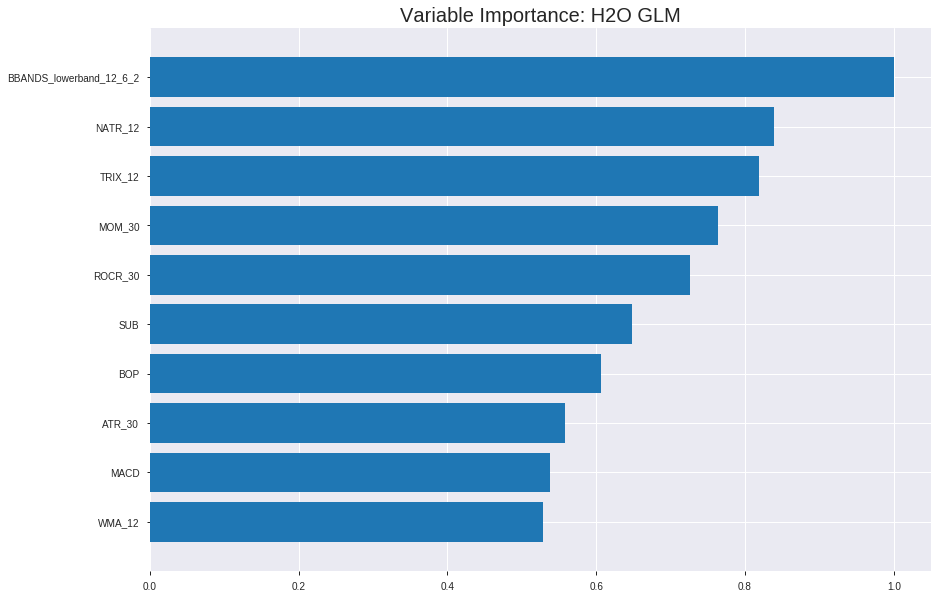

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_154814_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19057914516549881
RMSE: 0.4365537139522453
LogLoss: 0.5617965095443719
Null degrees of freedom: 4312
Residual degrees of freedom: 4237
Null deviance: 5978.985330091486
Residual deviance: 4846.056691329752
AIC: 4998.056691329752
AUC: 0.7812345308406923
pr_auc: 0.7700013447467562
Gini: 0.5624690616813846
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3284880802195905: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      982   1185  0.5468   (1185.0/2167.0)
1      212   1934  0.0988   (212.0/2146.0)
Total  1194  3119  0.3239   (1397.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.328488     0.734663  276
max f2                       0.144582     0.844411  352
max f0point5                 0.613112     0.715289  145
max accuracy                 0.508532     0.710179  193
max precision                0.968459     1         0
max recall                   0.0370042    1         392
max specificity              0.968459     1         0
max absolute_mcc             0.476293     0.421126  209
max min_per_class_accuracy   0.510751     0.708814  192
max mean_per_class_accuracy  0.508532     0.710199  193

Gains/Lift Table: Avg response rate: 49.76 %, avg score: 49.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.925384           2.00979   2.00979            1                0.940921   1                           0.940921            0.0205033       0.0205033                  100.979   100.979
    2        0.0201716                   0.904955           1.82283   1.91738            0.906977         0.912809   0.954023                    0.927026            0.0181733       0.0386766                  82.2829   91.7382
    3        0.0301414                   0.888952           1.96305   1.93249            0.976744         0.896108   0.961538                    0.916799            0.0195713       0.0582479                  96.3046   93.2486
    4        0.0401113                   0.874482           1.58913   1.84714            0.790698         0.880959   0.919075                    0.907891            0.0158434       0.0740913                  58.9133   84.7144
    5        0.0500812                   0.863963           1.72935   1.82369            0.860465         0.86978    0.907407                    0.900304            0.0172414       0.0913327                  72.935    82.3694
    6        0.100162                    0.817471           1.67482   1.74926            0.833333         0.841479   0.87037                     0.870892            0.083877        0.17521                    67.4821   74.9258
    7        0.150012                    0.774826           1.59848   1.69915            0.795349         0.794716   0.84544                     0.845578            0.0796831       0.254893                   59.8481   69.9154
    8        0.200093                    0.738329           1.60038   1.67443            0.796296         0.758165   0.83314                     0.8237              0.0801491       0.335042                   60.0385   67.4433
    9        0.300023                    0.666518           1.40359   1.58422            0.698376         0.701443   0.788253                    0.782979            0.140261        0.475303                   40.3586   58.4221
    10       0.399954                    0.589899           1.24038   1.49831            0.617169         0.627498   0.745507                    0.744131            0.123952        0.599254                   24.0378   49.831
    11       0.500116                    0.510204           1.11655   1.42185            0.555556         0.548782   0.707464                    0.705007            0.111836        0.71109                    11.6548   42.1851
    12       0.600046                    0.432971           0.904637  1.33572            0.450116         0.470097   0.664606                    0.665886            0.0904007       0.801491                   -9.53633  33.5715
    13       0.699977                    0.345924           0.820701  1.26219            0.408353         0.38967    0.628023                    0.626452            0.082013        0.883504                   -17.9299  26.2191
    14       0.799907                    0.249307           0.526928  1.17034            0.262181         0.300529   0.582319                    0.585736            0.0526561       0.93616                    -47.3072  17.0336
    15       0.899838                    0.147826           0.433666  1.08853            0.215777         0.200516   0.541613                    0.542955            0.0433364       0.979497                   -56.6334  8.8526
    16       1                           0.00706581         0.2047    1                  0.101852         0.0897925  0.497565                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20091890709899893
RMSE: 0.4482397875010639
LogLoss: 0.5873748845585841
Null degrees of freedom: 1231
Residual degrees of freedom: 1156
Null deviance: 1708.411288237215
Residual deviance: 1447.2917155523512
AIC: 1599.2917155523512
AUC: 0.7568900443412162
pr_auc: 0.7392328550654402
Gini: 0.5137800886824324
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.383919455037438: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      305  287  0.4848   (287.0/592.0)
1      103  537  0.1609   (103.0/640.0)
Total  408  824  0.3166   (390.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.383919     0.733607  252
max f2                       0.168044     0.859803  343
max f0point5                 0.531631     0.71452   180
max accuracy                 0.4989       0.70211   195
max precision                0.953798     1         0
max recall                   0.0561888    1         387
max specificity              0.953798     1         0
max absolute_mcc             0.4989       0.403139  195
max min_per_class_accuracy   0.512497     0.695946  188
max mean_per_class_accuracy  0.4989       0.701499  195

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 50.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.917716           1.33269   1.33269            0.692308         0.931472  0.692308                    0.931472            0.0140625       0.0140625                  33.2692   33.2692
    2        0.0202922                   0.897304           1.76458   1.54               0.916667         0.907922  0.8                         0.920168            0.0171875       0.03125                    76.4583   54
    3        0.0300325                   0.880374           1.76458   1.61284            0.916667         0.887719  0.837838                    0.909644            0.0171875       0.0484375                  76.4583   61.2838
    4        0.0405844                   0.867365           1.62885   1.617              0.846154         0.87361   0.84                        0.900275            0.0171875       0.065625                   62.8846   61.7
    5        0.0503247                   0.858762           1.60417   1.61452            0.833333         0.863418  0.83871                     0.893142            0.015625        0.08125                    60.4167   61.4516
    6        0.100649                    0.812204           1.52137   1.56794            0.790323         0.83517   0.814516                    0.864156            0.0765625       0.157812                   52.1371   56.7944
    7        0.150162                    0.776881           1.57787   1.57122            0.819672         0.793558  0.816216                    0.840878            0.078125        0.235937                   57.7869   57.1216
    8        0.200487                    0.738545           1.55242   1.5665             0.806452         0.758503  0.813765                    0.820201            0.078125        0.314063                   55.2419   56.6498
    9        0.300325                    0.672453           1.39289   1.50878            0.723577         0.705569  0.783784                    0.782093            0.139063        0.453125                   39.2886   50.8784
    10       0.400162                    0.601491           1.17378   1.4252             0.609756         0.638542  0.740365                    0.746278            0.117188        0.570312                   17.378    42.5203
    11       0.5                         0.518227           1.17378   1.375              0.609756         0.560971  0.714286                    0.709277            0.117188        0.6875                     17.378    37.5
    12       0.599838                    0.443049           0.876423  1.29202            0.455285         0.479246  0.671177                    0.67099             0.0875          0.775                      -12.3577  29.2016
    13       0.699675                    0.352431           0.829472  1.22602            0.430894         0.401161  0.636891                    0.632488            0.0828125       0.857812                   -17.0528  22.6015
    14       0.799513                    0.245949           0.704268  1.16086            0.365854         0.297175  0.603046                    0.590616            0.0703125       0.928125                   -29.5732  16.0863
    15       0.899351                    0.149944           0.547764  1.0928             0.284553         0.197969  0.56769                     0.547028            0.0546875       0.982812                   -45.2236  9.28023
    16       1                           0.0127881          0.170766  1                  0.0887097        0.096983  0.519481                    0.501732            0.017187


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-24 15:48:14  0.000 sec   2            .21E2     76            1.3653247089535592  1.368388790242798
     2019-08-24 15:48:14  0.028 sec   4            .13E2     76            1.3557550830593872  1.3601161628870502
     2019-08-24 15:48:14  0.055 sec   6            .82E1     76            1.3430159931803178  1.3491738455773072
     2019-08-24 15:48:14  0.082 sec   8            .51E1     76            1.3266165485199704  1.3351671399465421
     2019-08-24 15:48:14  0.108 sec   10           .32E1     76            1.3063369744047493  1.3179269167901646
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-24 15:48:15  0.643 sec   47           .14E-3    76            1.1240379191671368  1.175025534639094
     2019-08-24 15:48:15  0.661 sec   48           .89E-4    76            1.1239063472325888  1.174961494620861
     2019-08-24 15:48:15  0.676 sec   49           .55E-4    76            1.1237885523072662  1.1748897909942762
     2019-08-24 15:48:15  0.691 sec   50           .34E-4    76            1.1236840720076577  1.1748171062636454
     2019-08-24 15:48:15  0.707 sec   51           .21E-4    76            1.1235930190887438  1.1747497691171682


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6823338735818476)

('F1', 0.6949602122015915)

('auc', 0.7401374113475178)

('logloss', 0.6082796907639015)

('mean_per_class_error', 0.31323349375211085)

('rmse', 0.456778668246898)

('mse', 0.20864675176540973)

glm prediction progress: |████████████████████████████████████████████████| 100%


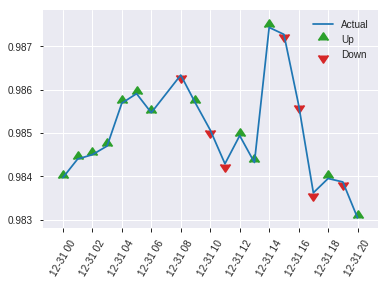


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20864675176540973
RMSE: 0.456778668246898
LogLoss: 0.6082796907639015
Null degrees of freedom: 616
Residual degrees of freedom: 541
Null deviance: 854.9589870947052
Residual deviance: 750.6171384026545
AIC: 902.6171384026545
AUC: 0.7401374113475178
pr_auc: 0.707843408687826
Gini: 0.4802748226950355
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2793553413019103: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      125  204  0.6201   (204.0/329.0)
1      26   262  0.0903   (26.0/288.0)
Total  151  466  0.3728   (230.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.279355     0.69496   297
max f2                       0.0512797    0.817198  390
max f0point5                 0.646093     0.666058  130
max accuracy                 0.493145     0.682334  204
max precision                0.879245     0.931034  18
max recall                   0.0204047    1         399
max specificity              0.951145     0.99696   0
max absolute_mcc             0.479272     0.374924  213
max min_per_class_accuracy   0.515583     0.673611  190
max mean_per_class_accuracy  0.479272     0.686767  213

Gains/Lift Table: Avg response rate: 46.68 %, avg score: 49.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.91934            1.83631   1.83631            0.857143         0.936294   0.857143                    0.936294            0.0208333       0.0208333                  83.631    83.631
    2        0.0210697                   0.906799           2.14236   1.97756            1                0.912735   0.923077                    0.92542             0.0208333       0.0416667                  114.236   97.7564
    3        0.0307942                   0.899177           1.7853    1.91685            0.833333         0.901111   0.894737                    0.917744            0.0173611       0.0590278                  78.5301   91.6849
    4        0.0405186                   0.885457           2.14236   1.97097            1                0.891348   0.92                        0.911409            0.0208333       0.0798611                  114.236   97.0972
    5        0.0502431                   0.868835           1.7853    1.93504            0.833333         0.880008   0.903226                    0.905331            0.0173611       0.0972222                  78.5301   93.5036
    6        0.100486                    0.820215           1.86593   1.90048            0.870968         0.842143   0.887097                    0.873737            0.09375         0.190972                   86.5927   90.0482
    7        0.150729                    0.781038           1.31306   1.70467            0.612903         0.801527   0.795699                    0.849667            0.0659722       0.256944                   31.306    70.4674
    8        0.200972                    0.734244           1.45128   1.64133            0.677419         0.759717   0.766129                    0.82718             0.0729167       0.329861                   45.1277   64.1325
    9        0.299838                    0.662385           1.43995   1.57492            0.672131         0.696182   0.735135                    0.783986            0.142361        0.472222                   43.9948   57.4925
    10       0.400324                    0.587355           1.07118   1.44848            0.5              0.626417   0.676113                    0.744434            0.107639        0.579861                   7.11806   44.8479
    11       0.50081                     0.508896           1.03663   1.36584            0.483871         0.548627   0.63754                     0.705146            0.104167        0.684028                   3.66263   36.5842
    12       0.599676                    0.431034           0.878017  1.28542            0.409836         0.474937   0.6                         0.667193            0.0868056       0.770833                   -12.1983  28.5417
    13       0.700162                    0.339077           0.794747  1.215              0.370968         0.377112   0.56713                     0.625561            0.0798611       0.850694                   -20.5253  21.4996
    14       0.799028                    0.24474            0.737534  1.15592            0.344262         0.28819    0.539554                    0.583817            0.0729167       0.923611                   -26.2466  15.5919
    15       0.899514                    0.147846           0.414651  1.07311            0.193548         0.194419   0.500901                    0.540317            0.0416667       0.965278                   -58.5349  7.31106
    16       1                           0.0199846          0.345542  1                  0.16129          0.0864387  0.466775                    

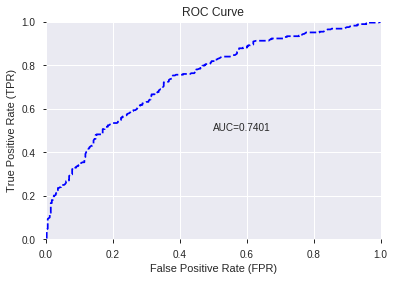

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


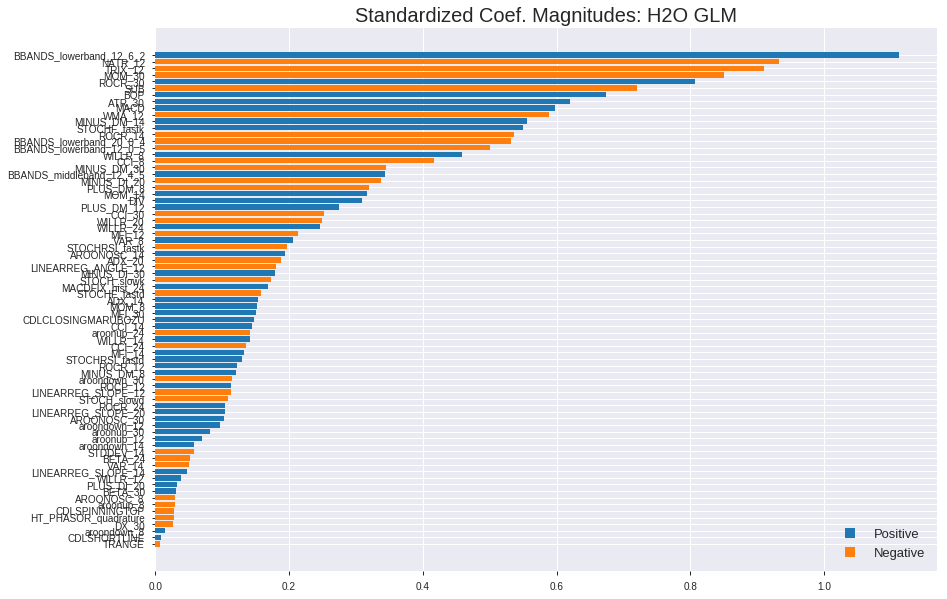

'log_likelihood'
--2019-08-24 15:48:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_154814_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_154814_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a4a9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BBANDS_lowerband_12_6_2',
 'NATR_12',
 'TRIX_12',
 'MOM_30',
 'ROCR_30',
 'SUB',
 'BOP',
 'ATR_30',
 'MACD',
 'WMA_12',
 'MINUS_DM_14',
 'STOCHF_fastk',
 'ROCR_14',
 'BBANDS_lowerband_20_0_4',
 'BBANDS_lowerband_12_0_5',
 'WILLR_8',
 'CCI_8',
 'MINUS_DM_30',
 'BBANDS_middleband_12_4_5',
 'MINUS_DI_20',
 'PLUS_DM_8',
 'MOM_14',
 'DIV',
 'PLUS_DM_12',
 'CCI_30',
 'WILLR_20',
 'WILLR_24',
 'MFI_12',
 'VAR_8',
 'STOCHRSI_fastk',
 'AROONOSC_14',
 'ADX_20',
 'LINEARREG_ANGLE_12',
 'MINUS_DI_30',
 'STOCH_slowk',
 'MACDFIX_hist_24',
 'STOCHF_fastd',
 'ADX_14',
 'MOM_8',
 'MFI_30',
 'CDLCLOSINGMARUBOZU',
 'CCI_14',
 'aroonup_24',
 'WILLR_14',
 'CCI_24',
 'MFI_14',
 'STOCHRSI_fastd',
 'ROCR_12',
 'MINUS_DM_8',
 'aroondown_30',
 'ROCP_12',
 'LINEARREG_SLOPE_12',
 'STOCH_slowd',
 'ROCR_24',
 'LINEARREG_SLOPE_20',
 'AROONOSC_30',
 'aroondown_12',
 'aroonup_30',
 'aroonup_12',
 'aroondown_14',
 'STDDEV_14',
 'BETA_24',
 'VAR_14',
 'LINEARREG_SLOPE_14',
 'WILLR_12',
 'PLUS_DI_20',
 'BETA_30',
 'ARO

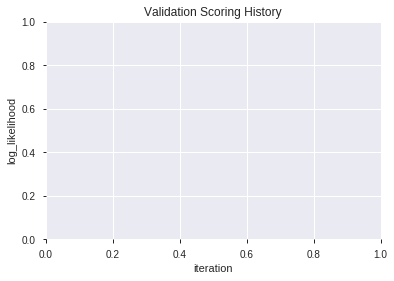

In [55]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190824_154922  0.752755  0.588121              0.329977  0.449498  0.202049
1  XGBoost_grid_1_AutoML_20190824_154922_model_2  0.749963  0.589860              0.307170  0.450283  0.202755
2  XGBoost_grid_1_AutoML_20190824_154922_model_6  0.748037  0.592097              0.328241  0.451616  0.203957
3  XGBoost_grid_1_AutoML_20190824_154922_model_4  0.746723  0.593054              0.313249  0.451427  0.203787
4  XGBoost_grid_1_AutoML_20190824_154922_model_1  0.746317  0.594570              0.314120  0.452139  0.204430
5  XGBoost_grid_1_AutoML_20190824_154922_model_7  0.743457  0.598670              0.327360  0.454227  0.206322
6               XGBoost_2_AutoML_20190824_154922  0.743304  0.599618              0.347787  0.454957  0.206986
7  XGBoost_grid_1_AutoML_20190824_154922_model_3  0.742670  0.596514              0.302822  0.453237  0.205424
8               XGBoost_1_AutoML_20190824_154922  0.742027  0.600390              0.344526  0.455247  0.207250
9  XGBoost_grid_1_AutoML_20190824_154922_model_5  0.729494  0.625378              0.328220  0.465022  0.216246

variable  relative_importance  scaled_importance  percentage
0                  BOP          5637.220215           1.000000    0.337985
1         STOCHF_fastk          1421.738525           0.252206    0.085242
2               TRANGE           665.429077           0.118042    0.039896
3                  DIV           563.593384           0.099977    0.033791
4       STOCHRSI_fastk           523.421082           0.092851    0.031382
..                 ...                  ...                ...         ...
70          AROONOSC_8            37.649757           0.006679    0.002257
71         MINUS_DI_20            28.143660           0.004992    0.001687
72              VAR_14            19.341080           0.003431    0.001160
73  LINEARREG_SLOPE_12            12.503299           0.002218    0.000750
74      CDLSPINNINGTOP             3.937190           0.000698    0.000236

[75 rows x 4 columns]

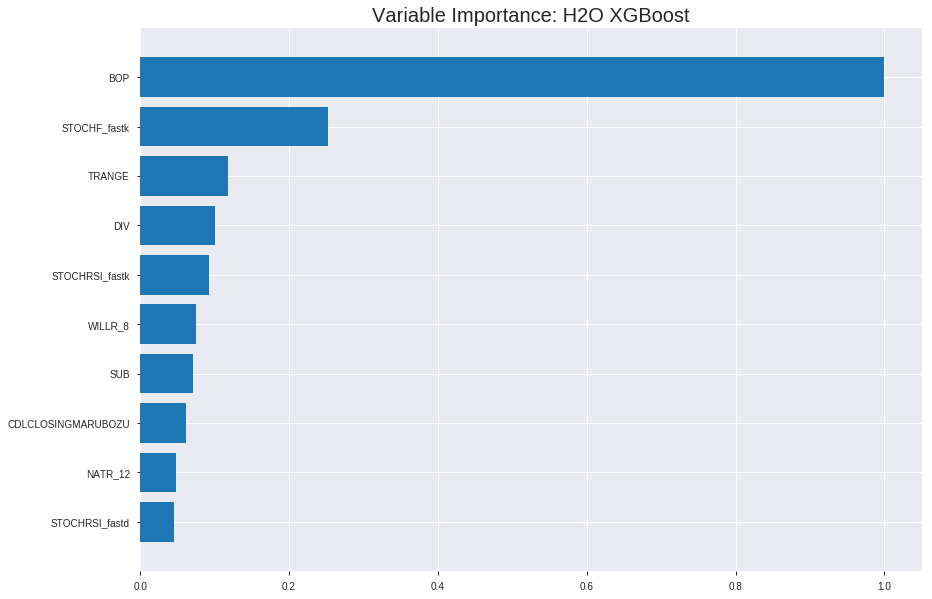

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190824_154922


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1573000120774181
RMSE: 0.3966106555268253
LogLoss: 0.4838344412756036
Mean Per-Class Error: 0.22378473424333745
AUC: 0.8688558273277335
pr_auc: 0.8722342896244818
Gini: 0.737711654655467
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45866506960656905: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1520  647   0.2986   (647.0/2167.0)
1      354   1792  0.165    (354.0/2146.0)
Total  1874  2439  0.2321   (1001.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458665     0.781679  222
max f2                       0.281875     0.877222  304
max f0point5                 0.616695     0.798196  146
max accuracy                 0.522909     0.776258  193
max precision                0.947083     1         0
max recall                   0.137376     1         363
max specificity              0.947083     1         0
max absolute_mcc             0.522909     0.552536  193
max min_per_class_accuracy   0.517682     0.773532  196
max mean_per_class_accuracy  0.522909     0.776215  193

Gains/Lift Table: Avg response rate: 49.76 %, avg score: 49.70 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.917692           2.00979    2.00979            1                0.930251  1                           0.930251            0.0205033       0.0205033                  100.979   100.979
    2        0.0201716                   0.905473           2.00979    2.00979            1                0.911032  1                           0.920752            0.0200373       0.0405405                  100.979   100.979
    3        0.0301414                   0.888713           2.00979    2.00979            1                0.8971    1                           0.912929            0.0200373       0.0605778                  100.979   100.979
    4        0.0401113                   0.873151           2.00979    2.00979            1                0.879797  1                           0.904694            0.0200373       0.0806151                  100.979   100.979
    5        0.0500812                   0.860225           1.96305    2.00048            0.976744         0.866653  0.99537                     0.897121            0.0195713       0.100186                   96.3046   100.048
    6        0.100162                    0.79998            1.97257    1.98652            0.981481         0.83018   0.988426                    0.86365             0.0987884       0.198975                   97.2567   98.6524
    7        0.150012                    0.751009           1.90696    1.96008            0.948837         0.774864  0.97527                     0.834146            0.0950606       0.294035                   90.6959   96.0085
    8        0.200093                    0.709416           1.73995    1.90499            0.865741         0.729034  0.947856                    0.807838            0.0871389       0.381174                   73.9953   90.4988
    9        0.300023                    0.644543           1.59943    1.80322            0.795824         0.676244  0.897218                    0.764007            0.159832        0.541007                   59.9435   80.3216
    10       0.399954                    0.585665           1.27302    1.67074            0.633411         0.615642  0.831304                    0.726937            0.127213        0.66822                    27.302    67.0744
    11       0.500116                    0.515366           1.06072    1.54857            0.527778         0.550464  0.770515                    0.691594            0.106244        0.774464                   6.07202   54.8569
    12       0.600046                    0.424955           0.862669   1.43434            0.429234         0.470217  0.713679                    0.654726            0.0862069       0.860671                   -13.7331  43.4341
    13       0.699977                    0.341019           0.746092   1.33608            0.37123          0.381219  0.66479                     0.615679            0.0745573       0.935228                   -25.3908  33.6085
    14       0.799907                    0.270029           0.470971   1.22801            0.234339         0.306642  0.611014                    0.577072            0.0470643       0.982293                   -52.9029  22.8008
    15       0.899838                    0.184062           0.153881   1.10872            0.0765661        0.232971  0.551662                    0.538858            0.0153774       0.99767                    -84.6119  10.8722
    16       1                           0.0363611          0.0232614  1                  0.0115741        0.120906  0.497565                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.200784042339868
RMSE: 0.44808932406370494
LogLoss: 0.5873735769224915
Mean Per-Class Error: 0.2974239864864865
AUC: 0.7553143475506756
pr_auc: 0.7461058346649487
Gini: 0.5106286951013512
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3935657814145088: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      315  277  0.4679   (277.0/592.0)
1      108  532  0.1688   (108.0/640.0)
Total  423  809  0.3125   (385.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.393566     0.7343    252
max f2                       0.187117     0.850572  350
max f0point5                 0.585072     0.716808  164
max accuracy                 0.552222     0.70211   184
max precision                0.941587     1         0
max recall                   0.0692644    1         392
max specificity              0.941587     1         0
max absolute_mcc             0.552222     0.404858  184
max min_per_class_accuracy   0.545039     0.701014  189
max mean_per_class_accuracy  0.552222     0.702576  184

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 51.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.912017           1.62885   1.62885            0.846154         0.926536  0.846154                    0.926536            0.0171875       0.0171875                  62.8846   62.8846
    2        0.0202922                   0.892337           1.925     1.771              1                0.901356  0.92                        0.91445             0.01875         0.0359375                  92.5      77.1
    3        0.0300325                   0.87644            1.60417   1.71689            0.833333         0.88509   0.891892                    0.904928            0.015625        0.0515625                  60.4167   71.6892
    4        0.0405844                   0.87026            1.62885   1.694              0.846154         0.873463  0.88                        0.896747            0.0171875       0.06875                    62.8846   69.4
    5        0.0503247                   0.857004           1.76458   1.70766            0.916667         0.863907  0.887097                    0.890391            0.0171875       0.0859375                  76.4583   70.7661
    6        0.100649                    0.807753           1.45927   1.58347            0.758065         0.830002  0.822581                    0.860197            0.0734375       0.159375                   45.9274   58.3468
    7        0.150162                    0.768075           1.60943   1.59203            0.836066         0.787705  0.827027                    0.836294            0.0796875       0.239063                   60.9426   59.2027
    8        0.200487                    0.732514           1.36613   1.53532            0.709677         0.750646  0.797571                    0.814795            0.06875         0.307812                   36.6129   53.5324
    9        0.300325                    0.67133            1.36159   1.47757            0.707317         0.700619  0.767568                    0.776839            0.135937        0.44375                    36.1585   47.7568
    10       0.400162                    0.618314           1.34593   1.44473            0.699187         0.642217  0.750507                    0.743252            0.134375        0.578125                   34.5935   44.4726
    11       0.5                         0.549174           1.17378   1.39062            0.609756         0.582645  0.722403                    0.711183            0.117188        0.695312                   17.378    39.0625
    12       0.599838                    0.446769           0.813821  1.29462            0.422764         0.50108   0.67253                     0.676213            0.08125         0.776563                   -18.6179  29.4621
    13       0.699675                    0.351411           0.813821  1.22602            0.422764         0.398929  0.636891                    0.636647            0.08125         0.857812                   -18.6179  22.6015
    14       0.799513                    0.275883           0.688618  1.15891            0.357724         0.312032  0.60203                     0.596111            0.06875         0.926562                   -31.1382  15.8909
    15       0.899351                    0.190998           0.469512  1.08238            0.243902         0.23665   0.562274                    0.556207            0.046875        0.973437                   -53.0488  8.23782
    16       1                           0.0407131          0.263911  1                  0.137097         0.127183  0.519481                    0.513026            0.0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 15:49:28  0.002 sec   0                  0.5              0.693147            0.5             0                  1                0.502435                         0.5                0.693147              0.5               0                    1                  0.480519
    2019-08-24 15:49:29  0.114 sec   5                  0.475348         0.644741            0.808428        0.792278           1.97572          0.293531                         0.481191           0.656011              0.739815          0.72336              1.60417            0.331169
    2019-08-24 15:49:29  0.190 sec   10                 0.457886         0.610914            0.819401        0.817053           2.00979          0.274287                         0.469115           0.632236              0.745641          0.732718             1.62885            0.321429
    2019-08-24 15:49:29  0.267 sec   15                 0.444451         0.584576            0.824909        0.82602            2.00979          0.270114                         0.461391           0.616691              0.747336          0.732927             1.62885            0.336851
    2019-08-24 15:49:29  0.357 sec   20                 0.435002         0.565455            0.828576        0.829569           2.00979          0.268954                         0.456475           0.606375              0.749188          0.736952             1.62885            0.340909
    2019-08-24 15:49:29  0.439 sec   25                 0.42795          0.550642            0.832537        0.833148           2.00979          0.269882                         0.453681           0.600208              0.750017          0.739157             1.62885            0.329545
    2019-08-24 15:49:29  0.545 sec   30                 0.422105         0.538187            0.837815        0.838194           2.00979          0.252492                         0.451551           0.595408              0.751321          0.740809             1.62885            0.327922
    2019-08-24 15:49:29  0.646 sec   35                 0.416457         0.526295            0.844356        0.846387           2.00979          0.252724                         0.45066            0.593304              0.751198          0.739312             1.62885            0.321429
    2019-08-24 15:49:29  0.736 sec   40                 0.412599         0.517749            0.848125        0.851354           2.00979          0.251101                         0.449648           0.590901              0.752472          0.743424             1.62885            0.31737
    2019-08-24 15:49:29  0.824 sec   45                 0.409123         0.510145            0.852127        0.852926           2.00979          0.243218                         0.449074           0.589566              0.753097          0.743427             1.62885            0.346591
    2019-08-24 15:49:29  0.928 sec   50                 0.405856         0.502988            0.855976        0.857708           2.00979          0.245305                         0.44864            0.588651              0.754016          0.743406             1.62885            0.3125
    2019-08-24 15:49:30  1.048 sec   55                 0.402558         0.495894            0.859925        0.862855           2.00979          0.246928                         0.44832            0.587965              0.754408          0.74

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ---------------------
BOP                 5637.22021484375       1.0                    0.33798487273443195
STOCHF_fastk        1421.738525390625      0.25220560333033437    0.08524167874451369
TRANGE              665.4290771484375      0.11804205828189054    0.03989643004571518
DIV                 563.5933837890625      0.09997718065102836    0.03379077467868513
STOCHRSI_fastk      523.4210815429688      0.0928509197076802     0.03138220628067525
---                 ---                    ---                    ---
AROONOSC_8          37.649757385253906     0.0066787806667754     0.002257326833681268
MINUS_DI_20         28.143659591674805     0.004992471203726938   0.0016873797444219654
VAR_14              19.341079711914062     0.003430960468953429   0.0011596127374560916
LINEARREG_SLOPE_12  12.50329875946045      0.002217990123312401   0.000749647109553969
CDLSPINNINGTOP      3.937190055847168      0.0006984275770316518  0.0002360579557372605


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6904376012965965)

('F1', 0.7039106145251396)

('auc', 0.7527545592705167)

('logloss', 0.5881205037081652)

('mean_per_class_error', 0.30650540357987177)

('rmse', 0.44949827292228167)

('mse', 0.20204869736011402)

xgboost prediction progress: |████████████████████████████████████████████| 100%


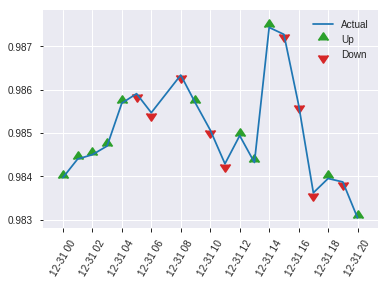


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20204869736011402
RMSE: 0.44949827292228167
LogLoss: 0.5881205037081652
Mean Per-Class Error: 0.30650540357987177
AUC: 0.7527545592705167
pr_auc: 0.7276755902821326
Gini: 0.5055091185410334
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3243969529867172: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      153  176  0.535    (176.0/329.0)
1      36   252  0.125    (36.0/288.0)
Total  189  428  0.3436   (212.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.324397     0.703911  279
max f2                       0.153271     0.823258  374
max f0point5                 0.627178     0.681818  134
max accuracy                 0.627178     0.690438  134
max precision                0.955786     1         0
max recall                   0.0750584    1         392
max specificity              0.955786     1         0
max absolute_mcc             0.462866     0.388716  225
max min_per_class_accuracy   0.529057     0.666667  196
max mean_per_class_accuracy  0.462866     0.693495  225

Gains/Lift Table: Avg response rate: 46.68 %, avg score: 49.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.914966           2.14236   2.14236            1                0.925818  1                           0.925818            0.0243056       0.0243056                  114.236   114.236
    2        0.0210697                   0.892682           2.14236   2.14236            1                0.904184  1                           0.915833            0.0208333       0.0451389                  114.236   114.236
    3        0.0307942                   0.880833           1.7853    2.02961            0.833333         0.889293  0.947368                    0.907452            0.0173611       0.0625                     78.5301   102.961
    4        0.0405186                   0.867959           1.7853    1.97097            0.833333         0.873721  0.92                        0.899356            0.0173611       0.0798611                  78.5301   97.0972
    5        0.0502431                   0.858464           1.7853    1.93504            0.833333         0.864159  0.903226                    0.892544            0.0173611       0.0972222                  78.5301   93.5036
    6        0.100486                    0.807366           1.72771   1.83137            0.806452         0.83438   0.854839                    0.863462            0.0868056       0.184028                   72.7711   83.1373
    7        0.150729                    0.758081           1.6586    1.77378            0.774194         0.778842  0.827957                    0.835255            0.0833333       0.267361                   65.8602   77.3783
    8        0.200972                    0.722686           1.45128   1.69316            0.677419         0.738038  0.790323                    0.810951            0.0729167       0.340278                   45.1277   69.3156
    9        0.299838                    0.65212            1.36971   1.58651            0.639344         0.682785  0.740541                    0.768691            0.135417        0.475694                   36.9706   58.6505
    10       0.400324                    0.586535           1.07118   1.45715            0.5              0.614581  0.680162                    0.730007            0.107639        0.583333                   7.11806   45.7152
    11       0.50081                     0.508772           0.932964  1.35198            0.435484         0.553213  0.631068                    0.694534            0.09375         0.677083                   -6.70363  35.1975
    12       0.599676                    0.408428           1.22922   1.33174            0.57377          0.462976  0.621622                    0.656358            0.121528        0.798611                   22.9224   33.1738
    13       0.700162                    0.320761           0.760193  1.24971            0.354839         0.359692  0.583333                    0.613781            0.0763889       0.875                      -23.9807  24.9711
    14       0.799028                    0.264128           0.491689  1.15592            0.229508         0.294634  0.539554                    0.574292            0.0486111       0.923611                   -50.8311  15.5919
    15       0.899514                    0.194159           0.449205  1.07697            0.209677         0.230009  0.502703                    0.535832            0.0451389       0.96875                    -55.0795  7.69707
    16       1                           0.0567345          0.310988  1                  0.145161         0.136017  0.466775                    0.495656         

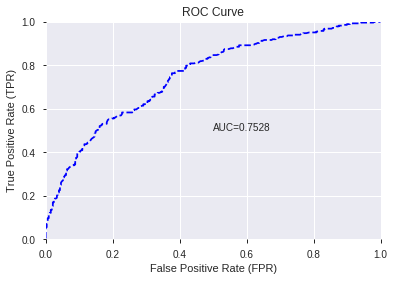

This function is available for GLM models only


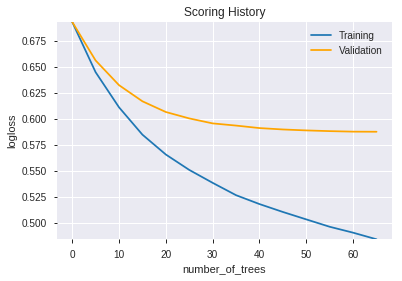

--2019-08-24 15:49:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.84.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.84.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190824_154922',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190824_154922',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a4a9',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_a4a9',
   'ty

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'DIV',
 'STOCHRSI_fastk',
 'WILLR_8',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'NATR_12',
 'STOCHRSI_fastd',
 'aroonup_8',
 'CCI_8',
 'LINEARREG_SLOPE_20',
 'DX_30',
 'CCI_24',
 'WILLR_12',
 'STOCH_slowd',
 'HT_PHASOR_quadrature',
 'PLUS_DM_8',
 'STDDEV_14',
 'ATR_30',
 'BETA_30',
 'BETA_24',
 'VAR_8',
 'CCI_30',
 'MFI_30',
 'MACDFIX_hist_24',
 'aroondown_14',
 'CCI_14',
 'MFI_14',
 'MINUS_DM_30',
 'BBANDS_lowerband_12_0_5',
 'STOCH_slowk',
 'BBANDS_middleband_12_4_5',
 'BBANDS_lowerband_12_6_2',
 'MINUS_DM_14',
 'ADX_14',
 'aroondown_8',
 'PLUS_DM_12',
 'aroondown_30',
 'MOM_8',
 'BBANDS_lowerband_20_0_4',
 'MFI_12',
 'MOM_30',
 'CDLSHORTLINE',
 'AROONOSC_30',
 'WILLR_20',
 'MINUS_DM_8',
 'WILLR_24',
 'MACD',
 'aroondown_12',
 'ROCR_24',
 'ADX_20',
 'ROCP_12',
 'WILLR_14',
 'TRIX_12',
 'MINUS_DI_30',
 'LINEARREG_ANGLE_12',
 'WMA_12',
 'aroonup_24',
 'STOCHF_fastd',
 'LINEARREG_SLOPE_14',
 'PLUS_DI_20',
 'ROCR_14',
 'ROCR_30',
 'ROCR_12',
 'AROONOSC_14',
 'a

In [56]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [57]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.703
GLM             0.702
XGBoost         0.703
dtype: float64

DeepLearning    GLM  XGBoost
All          0.692  0.697    0.699
DLF          0.703  0.702    0.703
Fwe          0.697  0.689    0.694
RFE          0.697  0.682    0.690
XGBF         0.699  0.702    0.703





F1


DeepLearning    0.701
GLM             0.701
XGBoost         0.713
dtype: float64

DeepLearning    GLM  XGBoost
All          0.701  0.701    0.707
DLF          0.701  0.691    0.713
Fwe          0.701  0.695    0.710
RFE          0.701  0.695    0.704
XGBF         0.701  0.691    0.713





auc


DeepLearning    0.755
GLM             0.751
XGBoost         0.764
dtype: float64

DeepLearning    GLM  XGBoost
All          0.749  0.751    0.763
DLF          0.755  0.743    0.764
Fwe          0.750  0.750    0.759
RFE          0.748  0.740    0.753
XGBF         0.753  0.743    0.764





logloss


DeepLearning    0.708
GLM             0.608
XGBoost         0.588
dtype: float64

DeepLearning    GLM  XGBoost
All          0.708  0.595    0.577
DLF          0.596  0.605    0.582
Fwe          0.600  0.598    0.582
RFE          0.597  0.608    0.588
XGBF         0.598  0.605    0.582





mean_per_class_error


DeepLearning    0.312
GLM             0.317
XGBoost         0.307
dtype: float64

DeepLearning    GLM  XGBoost
All          0.312  0.302    0.304
DLF          0.299  0.302    0.303
Fwe          0.301  0.317    0.301
RFE          0.309  0.313    0.307
XGBF         0.303  0.302    0.303





rmse


DeepLearning    0.472
GLM             0.457
XGBoost         0.449
dtype: float64

DeepLearning    GLM  XGBoost
All          0.472  0.451    0.444
DLF          0.452  0.455    0.445
Fwe          0.454  0.453    0.447
RFE          0.451  0.457    0.449
XGBF         0.453  0.455    0.445





mse


DeepLearning    0.223
GLM             0.209
XGBoost         0.202
dtype: float64

DeepLearning    GLM  XGBoost
All          0.223  0.203    0.197
DLF          0.205  0.207    0.198
Fwe          0.206  0.205    0.200
RFE          0.204  0.209    0.202
XGBF         0.205  0.207    0.198

{'F1':       DeepLearning    GLM  XGBoost
 All          0.701    NaN      NaN
 DLF          0.701    NaN      NaN
 DLF            NaN  0.691      NaN
 DLF            NaN    NaN    0.713
 All            NaN  0.701      NaN
 All            NaN    NaN    0.707
 XGBF         0.701    NaN      NaN
 XGBF           NaN  0.691      NaN
 XGBF           NaN    NaN    0.713
 Fwe          0.701    NaN      NaN
 Fwe            NaN  0.695      NaN
 Fwe            NaN    NaN    0.710
 RFE          0.701    NaN      NaN
 RFE            NaN  0.695      NaN
 RFE            NaN    NaN    0.704,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.692    NaN      NaN
 DLF          0.703    NaN      NaN
 DLF            NaN  0.702      NaN
 DLF            NaN    NaN    0.703
 All            NaN  0.697      NaN
 All            NaN    NaN    0.699
 XGBF         0.699    NaN      NaN
 XGBF           NaN  0.702      NaN
 XGBF           NaN    NaN    0.703
 Fwe          0.697    NaN      NaN
 Fwe     